# Importing Necessary Packages for Basic Demonstration of Data  

http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html 

In [1]:
import numpy as np  
import pandas as pd 
import math

In [2]:
# Tells matplotlib to display images inline instead of a new window
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#Demonstrates Display of dataframe in a better way 
from IPython.display import display, HTML

# Training and Test Data Subset 

In [4]:
import random 
random.seed(1)

In [5]:
def subsetData(df, percentage): 
    msk = np.random.rand(len(df)) < percentage
    train = df[msk]
    test = df[~msk]
    return train, test

# Choosing Training & Test data 

In [6]:
def chooseData(columnName, df):
    selectedData = df[columnName].values
    return selectedData

# Tokenizing text with scikit-learn

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer

In [9]:
def tokenizeText(train_x, test_x):
    count_vect = CountVectorizer()
    train_counts = count_vect.fit_transform(train_x)
    tfidf_transformer = TfidfTransformer()
    train_x_tfidf = tfidf_transformer.fit_transform(train_counts)
    test_counts = count_vect.transform(test_x)
    test_x_tfidf = tfidf_transformer.transform(test_counts)
    
    return count_vect, train_counts, tfidf_transformer, train_x_tfidf, test_counts, test_x_tfidf

# Training a Classifier

In [10]:
from sklearn.naive_bayes import MultinomialNB

In [11]:
def trainClassifier(train_x_tfidf, train_y, test_x_tfidf):
    clf = MultinomialNB().fit(train_x_tfidf, train_y)
    predicted = clf.predict(test_x_tfidf)
    #for test_row, cluster in zip(test_x, predicted): 
    #print('%r => %s' % (test_row, train_y[cluster]))
    
    return clf, predicted

# Evaluation of the Performance on the Test Set

In [12]:
def evaluateTestPerformance(predicted, test_y):
    print("The test has an accuracy of: ")
    print((np.mean(predicted == test_y)))

# Visualizing The Results
https://buhrmann.github.io/tfidf-analysis.html

In [13]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [14]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [15]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=10):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [16]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [17]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right= 10, left=0.15, top=0.8, wspace=0.52)
    plt.show()

In [18]:
def visualizeTfidf(count_vect, train_x_tfidf, train_y):
    features=count_vect.get_feature_names()
    dfs = top_feats_by_class(train_x_tfidf, train_y, features)
    plot_tfidf_classfeats_h(dfs)

In [19]:
pd.set_option('display.max_columns', None)

# Looking at District Description 

In [20]:
def analyzeTfidf(train_x, test_x, train_y, test_y, centroidLabels):
    tokenizeInfo = tokenizeText(train_x, test_x)
    count_vect  = tokenizeInfo[0]
    train_counts  = tokenizeInfo[1]
    tfidf_transformer  = tokenizeInfo[2]
    train_x_tfidf  = tokenizeInfo[3]
    test_counts  = tokenizeInfo[4]
    test_x_tfidf  = tokenizeInfo[5]
    classifierInfo  = trainClassifier(train_x_tfidf, train_y, test_x_tfidf)
    clf  = classifierInfo[0]
    predicted  = classifierInfo[1]
    evaluateTestPerformance(predicted, test_y)
    visualizeTfidf(count_vect, train_x_tfidf, train_y)
    display(centroidLabels)

In [21]:
def importClusters(datasetFilePath):
    clusters = pd.read_csv(datasetFilePath)
    clusters = clusters.drop(['Unnamed: 0', 'index'], axis =1 )
    print(clusters.head())
    print(clusters.shape)
    
    return clusters

In [48]:
def importClusters_2(datasetFilePath):
    clusters = pd.read_csv(datasetFilePath)
    clusters = clusters.drop(['Unnamed: 0'], axis =1 )
    print(clusters.head())
    print(clusters.shape)
    
    return clusters

In [31]:
localPath = "../../../Project/Unsupervised-MachineLearning/finalProject/"

In [71]:
def getTfidf(year):
    clusters = importClusters(localPath + "year" + str(year) + "_10clusters.csv")
    centroids = importClusters(localPath + "year" + str(year) + "_10clusterCentroids.csv")
    splitData = subsetData(clusters, 0.7)
    train = splitData[0]
    test = splitData[1]
    train_cluster = chooseData('clusters_10', train) 
    test_cluster = chooseData('clusters_10', test)
    train_dscrptn = chooseData('Description', train)
    test_dscrptn = chooseData('Description', test)
    train_location = chooseData('Location Description', train)
    test_location = chooseData('Location Description', test)
    train_pType = chooseData('Primary Type', train) 
    test_pType = chooseData('Primary Type', test)
    train_district = chooseData('District', train).astype('str')
    test_district = chooseData('District', test).astype('str')
    train_day = chooseData('Day', train).astype('str')
    test_day = chooseData('Day', test).astype('str')
    train_hour = chooseData('Hour', train).astype('str')
    test_hour = chooseData('Hour', test).astype('str')
    print("Description")
    analyzeTfidf(train_dscrptn, test_dscrptn, train_cluster, test_cluster, centroids)
    print("Location Description")
    analyzeTfidf(train_location, test_location, train_cluster, test_cluster, centroids)
    print("Primary Type")
    analyzeTfidf(train_pType, test_pType, train_cluster, test_cluster, centroids)
    print("District")
    analyzeTfidf(train_district, test_district, train_cluster, test_cluster, centroids)
    print("Day")
    analyzeTfidf(train_day, test_day, train_cluster, test_cluster, centroids)
    print("Hour")
    analyzeTfidf(train_hour, test_hour, train_cluster, test_cluster, centroids)

   IUCR                Primary Type                     Description  \
0  0266         CRIM SEXUAL ASSAULT                       PREDATORY   
1  1753  OFFENSE INVOLVING CHILDREN   SEX ASSLT OF CHILD BY FAM MBR   
2  0840                       THEFT   FINANCIAL ID THEFT: OVER $300   
3  1754  OFFENSE INVOLVING CHILDREN  AGG SEX ASSLT OF CHILD FAM MBR   
4  1563                 SEX OFFENSE           CRIMINAL SEXUAL ABUSE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  \
0            RESIDENCE   True     True       5.0  2001.0      1    1    11   
1            RESIDENCE   True    False       8.0  2001.0      1    1     0   
2                OTHER  False    False       9.0  2001.0      1    1     0   
3            RESIDENCE   True    False       7.0  2001.0      6   16     8   
4            RESIDENCE  False    False      15.0  2001.0      6    1     8   

   index.1  clusters_10  
0        0            0  
1        1            4  
2        2            8  


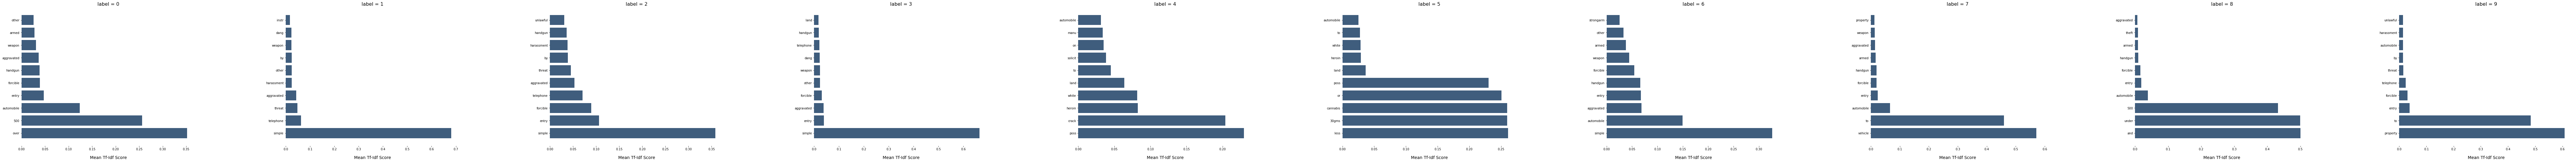

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500               STREET   
1   460          BATTERY                        SIMPLE            RESIDENCE   
2   560          ASSAULT                        SIMPLE            RESIDENCE   
3   460          BATTERY                        SIMPLE            RESIDENCE   
4  2027        NARCOTICS                   POSS: CRACK               STREET   
5  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
6   560          ASSAULT                        SIMPLE               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   820            THEFT                $500 AND UNDER               STREET   
9  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       5.0  2001.0      6   29    22  
1  False     True      25.0  2001.0      7   21    21  
2  False    False       7.0  2001.0      2    6    17  
3  False    False      18.0  2001.0     12    4     9  
4   True    False       2.0  2001.0      2   26    19  
5   True    False       7.0  2001.0      4   18    20  
6  False    False      14.0  2001.0     11   20    16  
7  False    False       3.0  2001.0      5    6     0  
8  False    False       8.0  2001.0      1   19    15  
9  False    False      10.0  2001.0     10    1    21

Location Description
The test has an accuracy of: 
0.275049841679


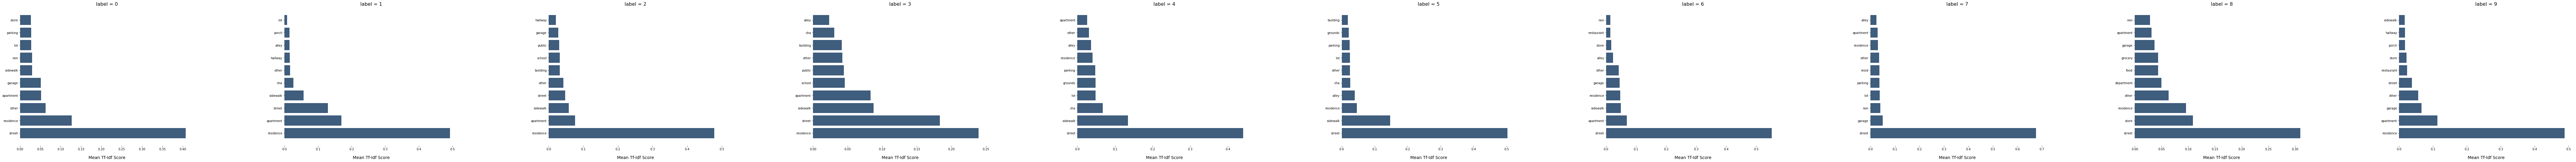

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500               STREET   
1   460          BATTERY                        SIMPLE            RESIDENCE   
2   560          ASSAULT                        SIMPLE            RESIDENCE   
3   460          BATTERY                        SIMPLE            RESIDENCE   
4  2027        NARCOTICS                   POSS: CRACK               STREET   
5  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
6   560          ASSAULT                        SIMPLE               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   820            THEFT                $500 AND UNDER               STREET   
9  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       5.0  2001.0      6   29    22  
1  False     True      25.0  2001.0      7   21    21  
2  False    False       7.0  2001.0      2    6    17  
3  False    False      18.0  2001.0     12    4     9  
4   True    False       2.0  2001.0      2   26    19  
5   True    False       7.0  2001.0      4   18    20  
6  False    False      14.0  2001.0     11   20    16  
7  False    False       3.0  2001.0      5    6     0  
8  False    False       8.0  2001.0      1   19    15  
9  False    False      10.0  2001.0     10    1    21

Primary Type
The test has an accuracy of: 
0.4853758649


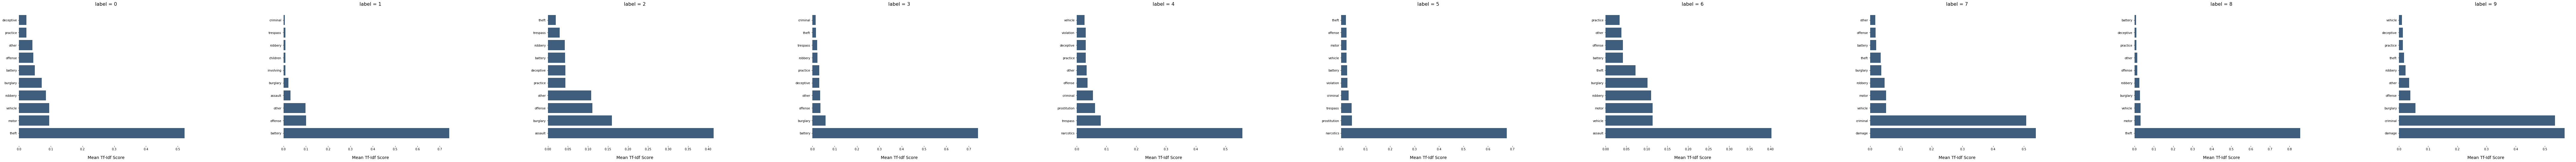

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500               STREET   
1   460          BATTERY                        SIMPLE            RESIDENCE   
2   560          ASSAULT                        SIMPLE            RESIDENCE   
3   460          BATTERY                        SIMPLE            RESIDENCE   
4  2027        NARCOTICS                   POSS: CRACK               STREET   
5  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
6   560          ASSAULT                        SIMPLE               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   820            THEFT                $500 AND UNDER               STREET   
9  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       5.0  2001.0      6   29    22  
1  False     True      25.0  2001.0      7   21    21  
2  False    False       7.0  2001.0      2    6    17  
3  False    False      18.0  2001.0     12    4     9  
4   True    False       2.0  2001.0      2   26    19  
5   True    False       7.0  2001.0      4   18    20  
6  False    False      14.0  2001.0     11   20    16  
7  False    False       3.0  2001.0      5    6     0  
8  False    False       8.0  2001.0      1   19    15  
9  False    False      10.0  2001.0     10    1    21

District
The test has an accuracy of: 
0.182444001407


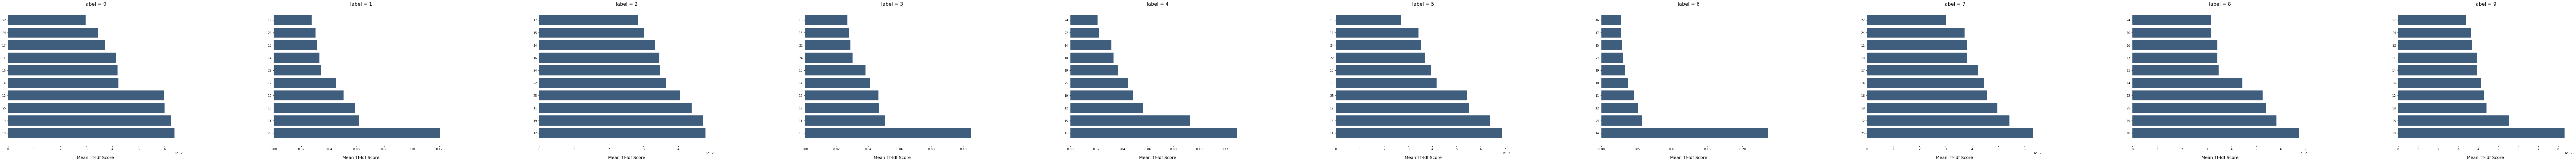

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500               STREET   
1   460          BATTERY                        SIMPLE            RESIDENCE   
2   560          ASSAULT                        SIMPLE            RESIDENCE   
3   460          BATTERY                        SIMPLE            RESIDENCE   
4  2027        NARCOTICS                   POSS: CRACK               STREET   
5  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
6   560          ASSAULT                        SIMPLE               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   820            THEFT                $500 AND UNDER               STREET   
9  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       5.0  2001.0      6   29    22  
1  False     True      25.0  2001.0      7   21    21  
2  False    False       7.0  2001.0      2    6    17  
3  False    False      18.0  2001.0     12    4     9  
4   True    False       2.0  2001.0      2   26    19  
5   True    False       7.0  2001.0      4   18    20  
6  False    False      14.0  2001.0     11   20    16  
7  False    False       3.0  2001.0      5    6     0  
8  False    False       8.0  2001.0      1   19    15  
9  False    False      10.0  2001.0     10    1    21

Day
The test has an accuracy of: 
0.168564559634


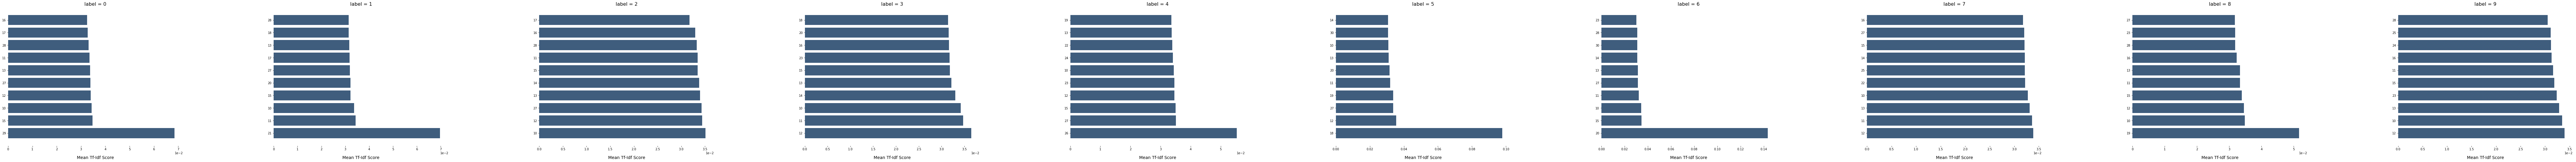

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500               STREET   
1   460          BATTERY                        SIMPLE            RESIDENCE   
2   560          ASSAULT                        SIMPLE            RESIDENCE   
3   460          BATTERY                        SIMPLE            RESIDENCE   
4  2027        NARCOTICS                   POSS: CRACK               STREET   
5  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
6   560          ASSAULT                        SIMPLE               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   820            THEFT                $500 AND UNDER               STREET   
9  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       5.0  2001.0      6   29    22  
1  False     True      25.0  2001.0      7   21    21  
2  False    False       7.0  2001.0      2    6    17  
3  False    False      18.0  2001.0     12    4     9  
4   True    False       2.0  2001.0      2   26    19  
5   True    False       7.0  2001.0      4   18    20  
6  False    False      14.0  2001.0     11   20    16  
7  False    False       3.0  2001.0      5    6     0  
8  False    False       8.0  2001.0      1   19    15  
9  False    False      10.0  2001.0     10    1    21

Hour
The test has an accuracy of: 
0.201254837575


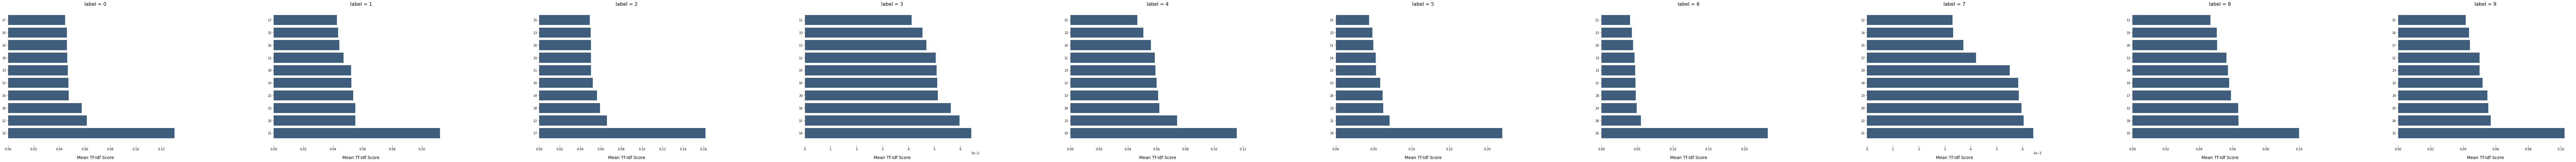

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500               STREET   
1   460          BATTERY                        SIMPLE            RESIDENCE   
2   560          ASSAULT                        SIMPLE            RESIDENCE   
3   460          BATTERY                        SIMPLE            RESIDENCE   
4  2027        NARCOTICS                   POSS: CRACK               STREET   
5  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
6   560          ASSAULT                        SIMPLE               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   820            THEFT                $500 AND UNDER               STREET   
9  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       5.0  2001.0      6   29    22  
1  False     True      25.0  2001.0      7   21    21  
2  False    False       7.0  2001.0      2    6    17  
3  False    False      18.0  2001.0     12    4     9  
4   True    False       2.0  2001.0      2   26    19  
5   True    False       7.0  2001.0      4   18    20  
6  False    False      14.0  2001.0     11   20    16  
7  False    False       3.0  2001.0      5    6     0  
8  False    False       8.0  2001.0      1   19    15  
9  False    False      10.0  2001.0     10    1    21

In [72]:
getTfidf(2001)

   IUCR                Primary Type                     Description  \
0  0266         CRIM SEXUAL ASSAULT                       PREDATORY   
1  0840                       THEFT   FINANCIAL ID THEFT: OVER $300   
2  1752  OFFENSE INVOLVING CHILDREN   AGG CRIM SEX ABUSE FAM MEMBER   
3  1754  OFFENSE INVOLVING CHILDREN  AGG SEX ASSLT OF CHILD FAM MBR   
4  0840                       THEFT   FINANCIAL ID THEFT: OVER $300   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  \
0            APARTMENT  False    False      14.0  2002.0      6   14    16   
1            RESIDENCE  False    False      10.0  2002.0      7    1     0   
2            RESIDENCE  False    False      25.0  2002.0      1    1     0   
3          HOTEL/MOTEL  False     True      18.0  2002.0      1    1     0   
4                 BANK  False    False       4.0  2002.0      1    9    12   

   index.1  clusters_10  
0        0            0  
1        1            5  
2        2            5  


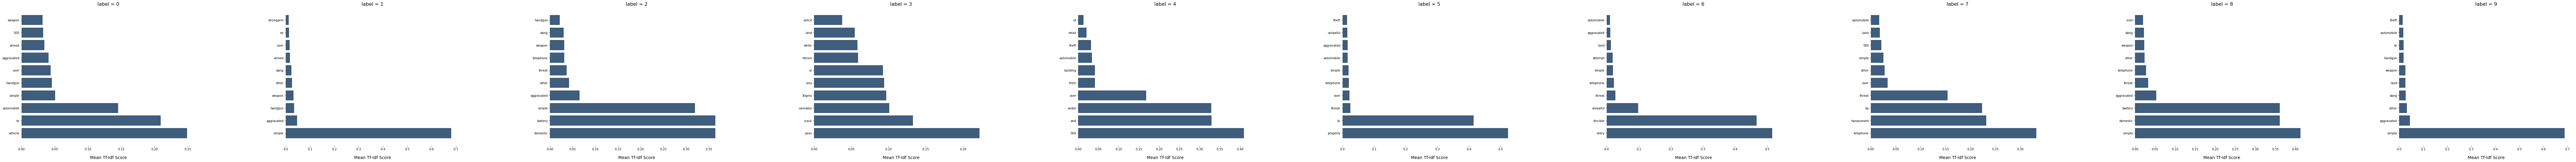

IUCR     Primary Type                   Description Location Description  \
0  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
1   460          BATTERY                        SIMPLE             SIDEWALK   
2   486          BATTERY       DOMESTIC BATTERY SIMPLE               STREET   
3  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
4   820            THEFT                $500 AND UNDER               STREET   
5  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
6   610         BURGLARY                FORCIBLE ENTRY            RESIDENCE   
7  2825    OTHER OFFENSE       HARASSMENT BY TELEPHONE            RESIDENCE   
8   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
9   460          BATTERY                        SIMPLE               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       8.0  2002.0      7   13    16  
1  False    False      15.0  2002.0      8    3    10  
2  False     True       8.0  2002.0      5    8    14  
3   True    False      11.0  2002.0      5   30    18  
4  False    False       2.0  2002.0      8   14    20  
5  False    False      14.0  2002.0      2    2     0  
6  False    False       3.0  2002.0      8    7    17  
7  False    False      18.0  2002.0      6   18    12  
8  False     True       2.0  2002.0      3   24    18  
9   True    False      17.0  2002.0      5   15     9

Location Description
The test has an accuracy of: 
0.328862303159


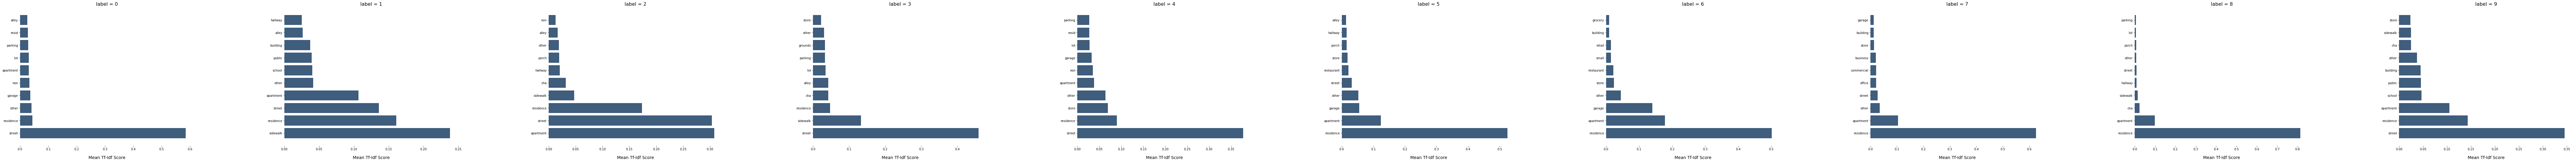

IUCR     Primary Type                   Description Location Description  \
0  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
1   460          BATTERY                        SIMPLE             SIDEWALK   
2   486          BATTERY       DOMESTIC BATTERY SIMPLE               STREET   
3  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
4   820            THEFT                $500 AND UNDER               STREET   
5  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
6   610         BURGLARY                FORCIBLE ENTRY            RESIDENCE   
7  2825    OTHER OFFENSE       HARASSMENT BY TELEPHONE            RESIDENCE   
8   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
9   460          BATTERY                        SIMPLE               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       8.0  2002.0      7   13    16  
1  False    False      15.0  2002.0      8    3    10  
2  False     True       8.0  2002.0      5    8    14  
3   True    False      11.0  2002.0      5   30    18  
4  False    False       2.0  2002.0      8   14    20  
5  False    False      14.0  2002.0      2    2     0  
6  False    False       3.0  2002.0      8    7    17  
7  False    False      18.0  2002.0      6   18    12  
8  False     True       2.0  2002.0      3   24    18  
9   True    False      17.0  2002.0      5   15     9

Primary Type
The test has an accuracy of: 
0.607331945068


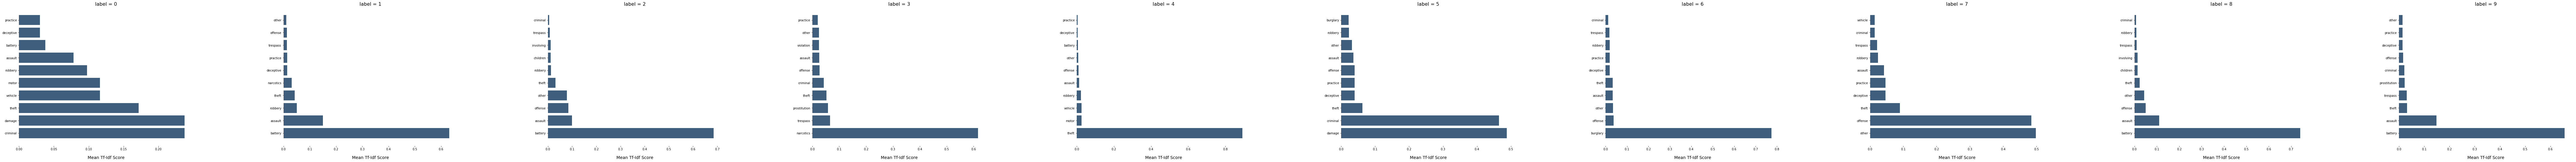

IUCR     Primary Type                   Description Location Description  \
0  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
1   460          BATTERY                        SIMPLE             SIDEWALK   
2   486          BATTERY       DOMESTIC BATTERY SIMPLE               STREET   
3  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
4   820            THEFT                $500 AND UNDER               STREET   
5  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
6   610         BURGLARY                FORCIBLE ENTRY            RESIDENCE   
7  2825    OTHER OFFENSE       HARASSMENT BY TELEPHONE            RESIDENCE   
8   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
9   460          BATTERY                        SIMPLE               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       8.0  2002.0      7   13    16  
1  False    False      15.0  2002.0      8    3    10  
2  False     True       8.0  2002.0      5    8    14  
3   True    False      11.0  2002.0      5   30    18  
4  False    False       2.0  2002.0      8   14    20  
5  False    False      14.0  2002.0      2    2     0  
6  False    False       3.0  2002.0      8    7    17  
7  False    False      18.0  2002.0      6   18    12  
8  False     True       2.0  2002.0      3   24    18  
9   True    False      17.0  2002.0      5   15     9

District
The test has an accuracy of: 
0.227702693506


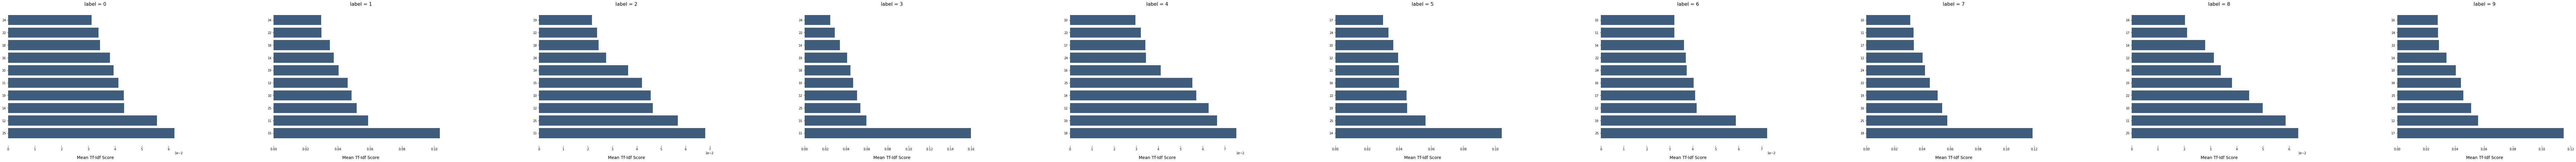

IUCR     Primary Type                   Description Location Description  \
0  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
1   460          BATTERY                        SIMPLE             SIDEWALK   
2   486          BATTERY       DOMESTIC BATTERY SIMPLE               STREET   
3  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
4   820            THEFT                $500 AND UNDER               STREET   
5  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
6   610         BURGLARY                FORCIBLE ENTRY            RESIDENCE   
7  2825    OTHER OFFENSE       HARASSMENT BY TELEPHONE            RESIDENCE   
8   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
9   460          BATTERY                        SIMPLE               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       8.0  2002.0      7   13    16  
1  False    False      15.0  2002.0      8    3    10  
2  False     True       8.0  2002.0      5    8    14  
3   True    False      11.0  2002.0      5   30    18  
4  False    False       2.0  2002.0      8   14    20  
5  False    False      14.0  2002.0      2    2     0  
6  False    False       3.0  2002.0      8    7    17  
7  False    False      18.0  2002.0      6   18    12  
8  False     True       2.0  2002.0      3   24    18  
9   True    False      17.0  2002.0      5   15     9

Day
The test has an accuracy of: 
0.193989628843


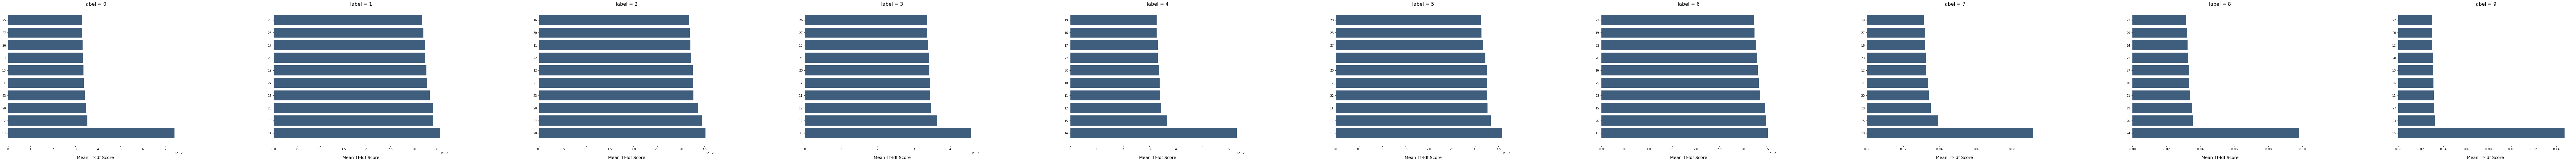

IUCR     Primary Type                   Description Location Description  \
0  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
1   460          BATTERY                        SIMPLE             SIDEWALK   
2   486          BATTERY       DOMESTIC BATTERY SIMPLE               STREET   
3  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
4   820            THEFT                $500 AND UNDER               STREET   
5  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
6   610         BURGLARY                FORCIBLE ENTRY            RESIDENCE   
7  2825    OTHER OFFENSE       HARASSMENT BY TELEPHONE            RESIDENCE   
8   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
9   460          BATTERY                        SIMPLE               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       8.0  2002.0      7   13    16  
1  False    False      15.0  2002.0      8    3    10  
2  False     True       8.0  2002.0      5    8    14  
3   True    False      11.0  2002.0      5   30    18  
4  False    False       2.0  2002.0      8   14    20  
5  False    False      14.0  2002.0      2    2     0  
6  False    False       3.0  2002.0      8    7    17  
7  False    False      18.0  2002.0      6   18    12  
8  False     True       2.0  2002.0      3   24    18  
9   True    False      17.0  2002.0      5   15     9

Hour
The test has an accuracy of: 
0.23090114736


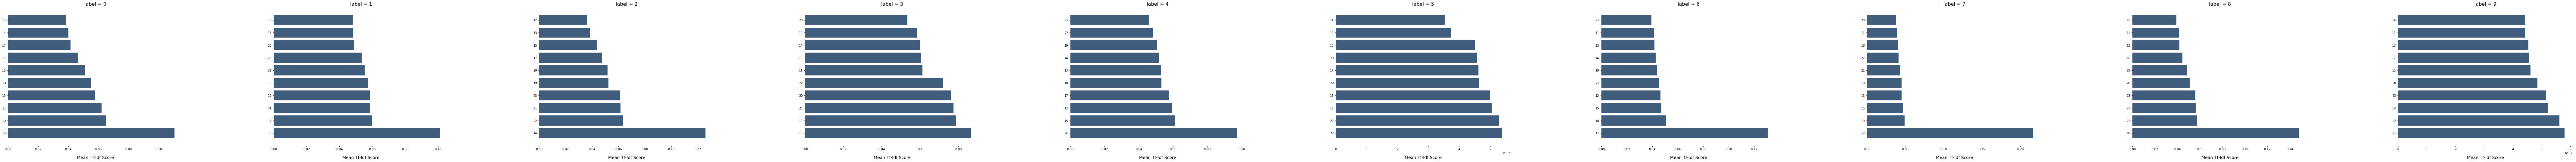

IUCR     Primary Type                   Description Location Description  \
0  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
1   460          BATTERY                        SIMPLE             SIDEWALK   
2   486          BATTERY       DOMESTIC BATTERY SIMPLE               STREET   
3  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
4   820            THEFT                $500 AND UNDER               STREET   
5  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
6   610         BURGLARY                FORCIBLE ENTRY            RESIDENCE   
7  2825    OTHER OFFENSE       HARASSMENT BY TELEPHONE            RESIDENCE   
8   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
9   460          BATTERY                        SIMPLE               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       8.0  2002.0      7   13    16  
1  False    False      15.0  2002.0      8    3    10  
2  False     True       8.0  2002.0      5    8    14  
3   True    False      11.0  2002.0      5   30    18  
4  False    False       2.0  2002.0      8   14    20  
5  False    False      14.0  2002.0      2    2     0  
6  False    False       3.0  2002.0      8    7    17  
7  False    False      18.0  2002.0      6   18    12  
8  False     True       2.0  2002.0      3   24    18  
9   True    False      17.0  2002.0      5   15     9

In [73]:
getTfidf(2002)

   IUCR   Primary Type                     Description  \
0  2825  OTHER OFFENSE         HARASSMENT BY TELEPHONE   
1  0841          THEFT  FINANCIAL ID THEFT:$300 &UNDER   
2  5007  OTHER OFFENSE         OTHER WEAPONS VIOLATION   
3  0840          THEFT   FINANCIAL ID THEFT: OVER $300   
4  0840          THEFT   FINANCIAL ID THEFT: OVER $300   

      Location Description Arrest Domestic  District    Year  Month  Day  \
0                RESIDENCE  False     True       9.0  2003.0      3    1   
1                RESIDENCE  False    False      22.0  2003.0      5    1   
2  RESIDENCE PORCH/HALLWAY  False    False      22.0  2003.0      3   15   
3                RESIDENCE  False    False      11.0  2003.0      1    1   
4                RESIDENCE  False    False      22.0  2003.0      6    5   

   Hour  index.1  clusters_10  
0     0        0            3  
1     1        1            4  
2     0        2            0  
3     0        3            7  
4     0        4            7  
(4

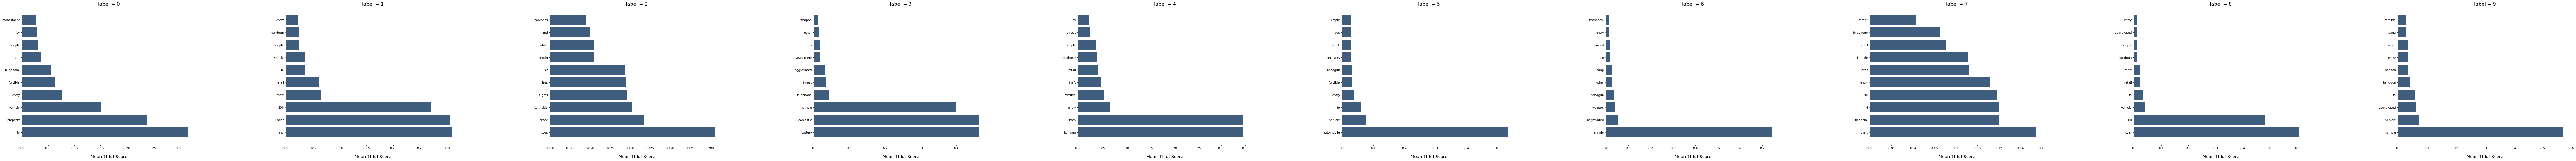

IUCR         Primary Type                    Description  \
0  1310      CRIMINAL DAMAGE                    TO PROPERTY   
1   820                THEFT                 $500 AND UNDER   
2  1811            NARCOTICS   POSS: CANNABIS 30GMS OR LESS   
3   486              BATTERY        DOMESTIC BATTERY SIMPLE   
4   890                THEFT                  FROM BUILDING   
5   910  MOTOR VEHICLE THEFT                     AUTOMOBILE   
6   460              BATTERY                         SIMPLE   
7   840                THEFT  FINANCIAL ID THEFT: OVER $300   
8   810                THEFT                      OVER $500   
9   460              BATTERY                         SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0            RESIDENCE  False    False      16.0  2003.0      1   16    23  
1               STREET  False    False       1.0  2003.0     10   19     9  
2               STREET   True    False      11.0  2003.0     11    5    20  
3            RESIDENCE  False     True       7.0  2003.0      7   20    18  
4            RESIDENCE  False    False      12.0  2003.0      8   18    12  
5               STREET  False    False       6.0  2003.0     11   15    21  
6             SIDEWALK  False    False       7.0  2003.0     11    7    14  
7            RESIDENCE  False    False       8.0  2003.0      9    2     0  
8               STREET  False    False      12.0  2003.0     10   29    14  
9               STREET  False    False       9.0  2003.0      5   17    18

Location Description
The test has an accuracy of: 
0.311334350034


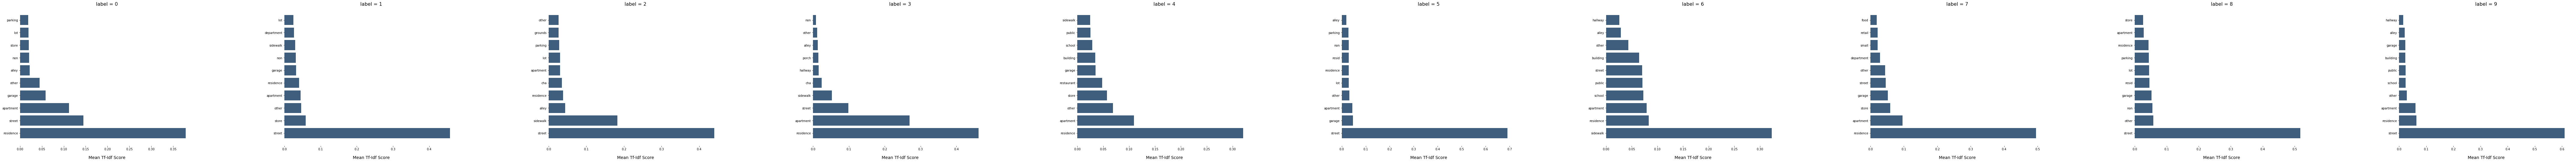

IUCR         Primary Type                    Description  \
0  1310      CRIMINAL DAMAGE                    TO PROPERTY   
1   820                THEFT                 $500 AND UNDER   
2  1811            NARCOTICS   POSS: CANNABIS 30GMS OR LESS   
3   486              BATTERY        DOMESTIC BATTERY SIMPLE   
4   890                THEFT                  FROM BUILDING   
5   910  MOTOR VEHICLE THEFT                     AUTOMOBILE   
6   460              BATTERY                         SIMPLE   
7   840                THEFT  FINANCIAL ID THEFT: OVER $300   
8   810                THEFT                      OVER $500   
9   460              BATTERY                         SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0            RESIDENCE  False    False      16.0  2003.0      1   16    23  
1               STREET  False    False       1.0  2003.0     10   19     9  
2               STREET   True    False      11.0  2003.0     11    5    20  
3            RESIDENCE  False     True       7.0  2003.0      7   20    18  
4            RESIDENCE  False    False      12.0  2003.0      8   18    12  
5               STREET  False    False       6.0  2003.0     11   15    21  
6             SIDEWALK  False    False       7.0  2003.0     11    7    14  
7            RESIDENCE  False    False       8.0  2003.0      9    2     0  
8               STREET  False    False      12.0  2003.0     10   29    14  
9               STREET  False    False       9.0  2003.0      5   17    18

Primary Type
The test has an accuracy of: 
0.534845326207


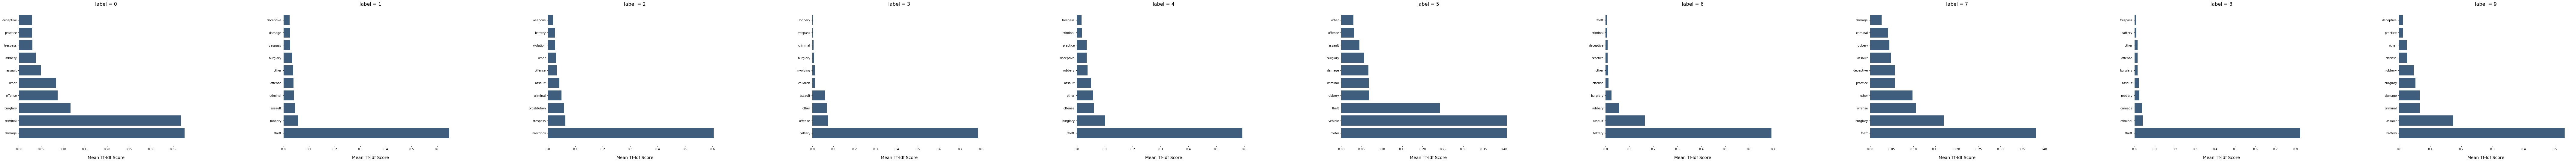

IUCR         Primary Type                    Description  \
0  1310      CRIMINAL DAMAGE                    TO PROPERTY   
1   820                THEFT                 $500 AND UNDER   
2  1811            NARCOTICS   POSS: CANNABIS 30GMS OR LESS   
3   486              BATTERY        DOMESTIC BATTERY SIMPLE   
4   890                THEFT                  FROM BUILDING   
5   910  MOTOR VEHICLE THEFT                     AUTOMOBILE   
6   460              BATTERY                         SIMPLE   
7   840                THEFT  FINANCIAL ID THEFT: OVER $300   
8   810                THEFT                      OVER $500   
9   460              BATTERY                         SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0            RESIDENCE  False    False      16.0  2003.0      1   16    23  
1               STREET  False    False       1.0  2003.0     10   19     9  
2               STREET   True    False      11.0  2003.0     11    5    20  
3            RESIDENCE  False     True       7.0  2003.0      7   20    18  
4            RESIDENCE  False    False      12.0  2003.0      8   18    12  
5               STREET  False    False       6.0  2003.0     11   15    21  
6             SIDEWALK  False    False       7.0  2003.0     11    7    14  
7            RESIDENCE  False    False       8.0  2003.0      9    2     0  
8               STREET  False    False      12.0  2003.0     10   29    14  
9               STREET  False    False       9.0  2003.0      5   17    18

District
The test has an accuracy of: 
0.213437242035


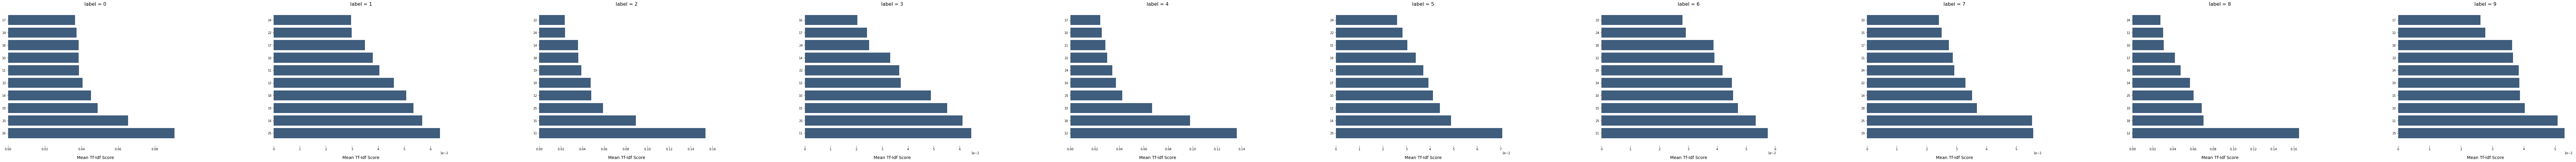

IUCR         Primary Type                    Description  \
0  1310      CRIMINAL DAMAGE                    TO PROPERTY   
1   820                THEFT                 $500 AND UNDER   
2  1811            NARCOTICS   POSS: CANNABIS 30GMS OR LESS   
3   486              BATTERY        DOMESTIC BATTERY SIMPLE   
4   890                THEFT                  FROM BUILDING   
5   910  MOTOR VEHICLE THEFT                     AUTOMOBILE   
6   460              BATTERY                         SIMPLE   
7   840                THEFT  FINANCIAL ID THEFT: OVER $300   
8   810                THEFT                      OVER $500   
9   460              BATTERY                         SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0            RESIDENCE  False    False      16.0  2003.0      1   16    23  
1               STREET  False    False       1.0  2003.0     10   19     9  
2               STREET   True    False      11.0  2003.0     11    5    20  
3            RESIDENCE  False     True       7.0  2003.0      7   20    18  
4            RESIDENCE  False    False      12.0  2003.0      8   18    12  
5               STREET  False    False       6.0  2003.0     11   15    21  
6             SIDEWALK  False    False       7.0  2003.0     11    7    14  
7            RESIDENCE  False    False       8.0  2003.0      9    2     0  
8               STREET  False    False      12.0  2003.0     10   29    14  
9               STREET  False    False       9.0  2003.0      5   17    18

Day
The test has an accuracy of: 
0.20600086746


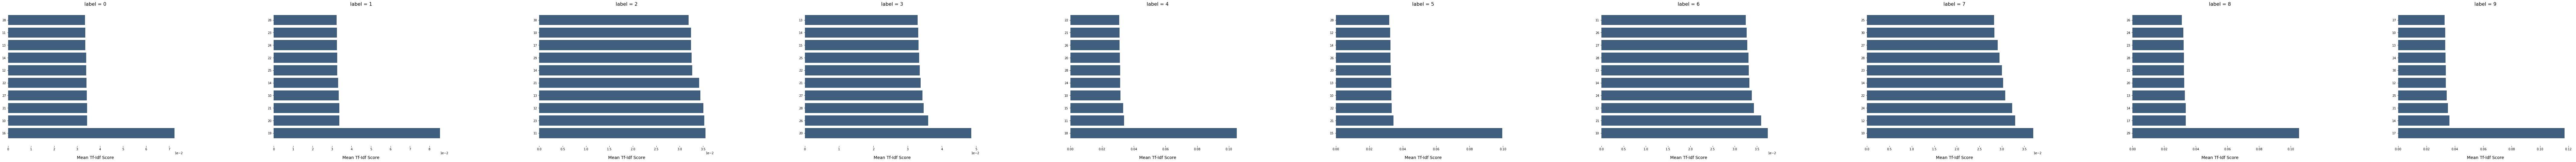

IUCR         Primary Type                    Description  \
0  1310      CRIMINAL DAMAGE                    TO PROPERTY   
1   820                THEFT                 $500 AND UNDER   
2  1811            NARCOTICS   POSS: CANNABIS 30GMS OR LESS   
3   486              BATTERY        DOMESTIC BATTERY SIMPLE   
4   890                THEFT                  FROM BUILDING   
5   910  MOTOR VEHICLE THEFT                     AUTOMOBILE   
6   460              BATTERY                         SIMPLE   
7   840                THEFT  FINANCIAL ID THEFT: OVER $300   
8   810                THEFT                      OVER $500   
9   460              BATTERY                         SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0            RESIDENCE  False    False      16.0  2003.0      1   16    23  
1               STREET  False    False       1.0  2003.0     10   19     9  
2               STREET   True    False      11.0  2003.0     11    5    20  
3            RESIDENCE  False     True       7.0  2003.0      7   20    18  
4            RESIDENCE  False    False      12.0  2003.0      8   18    12  
5               STREET  False    False       6.0  2003.0     11   15    21  
6             SIDEWALK  False    False       7.0  2003.0     11    7    14  
7            RESIDENCE  False    False       8.0  2003.0      9    2     0  
8               STREET  False    False      12.0  2003.0     10   29    14  
9               STREET  False    False       9.0  2003.0      5   17    18

Hour
The test has an accuracy of: 
0.200691170092


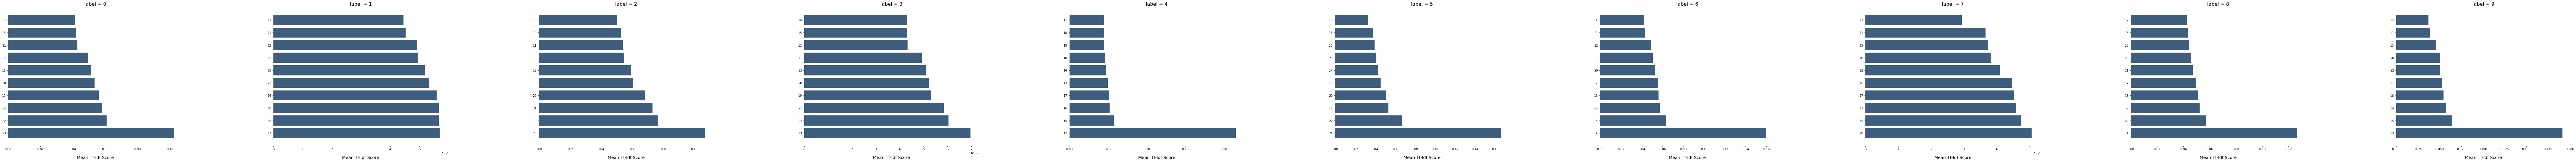

IUCR         Primary Type                    Description  \
0  1310      CRIMINAL DAMAGE                    TO PROPERTY   
1   820                THEFT                 $500 AND UNDER   
2  1811            NARCOTICS   POSS: CANNABIS 30GMS OR LESS   
3   486              BATTERY        DOMESTIC BATTERY SIMPLE   
4   890                THEFT                  FROM BUILDING   
5   910  MOTOR VEHICLE THEFT                     AUTOMOBILE   
6   460              BATTERY                         SIMPLE   
7   840                THEFT  FINANCIAL ID THEFT: OVER $300   
8   810                THEFT                      OVER $500   
9   460              BATTERY                         SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0            RESIDENCE  False    False      16.0  2003.0      1   16    23  
1               STREET  False    False       1.0  2003.0     10   19     9  
2               STREET   True    False      11.0  2003.0     11    5    20  
3            RESIDENCE  False     True       7.0  2003.0      7   20    18  
4            RESIDENCE  False    False      12.0  2003.0      8   18    12  
5               STREET  False    False       6.0  2003.0     11   15    21  
6             SIDEWALK  False    False       7.0  2003.0     11    7    14  
7            RESIDENCE  False    False       8.0  2003.0      9    2     0  
8               STREET  False    False      12.0  2003.0     10   29    14  
9               STREET  False    False       9.0  2003.0      5   17    18

In [74]:
getTfidf(2003)

   IUCR                Primary Type                     Description  \
0  0840                       THEFT   FINANCIAL ID THEFT: OVER $300   
1  1752  OFFENSE INVOLVING CHILDREN   AGG CRIM SEX ABUSE FAM MEMBER   
2  0840                       THEFT   FINANCIAL ID THEFT: OVER $300   
3  0841                       THEFT  FINANCIAL ID THEFT:$300 &UNDER   
4  0890                       THEFT                   FROM BUILDING   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  \
0            RESIDENCE  False    False       4.0  2004.0      1    1     0   
1            RESIDENCE  False    False      14.0  2004.0      6   20    11   
2                OTHER  False    False      25.0  2004.0     12   30    20   
3            APARTMENT  False    False      10.0  2004.0      8    1     0   
4            RESIDENCE  False    False      18.0  2004.0      9   16    10   

   index.1  clusters_10  
0        0            1  
1        1            1  
2        2            1  


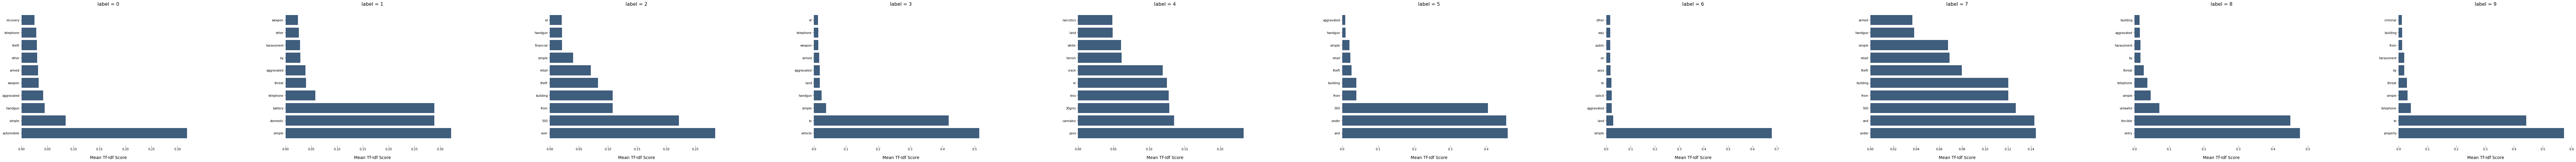

IUCR         Primary Type                   Description  \
0   910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
1   486              BATTERY       DOMESTIC BATTERY SIMPLE   
2   810                THEFT                     OVER $500   
3  1320      CRIMINAL DAMAGE                    TO VEHICLE   
4  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
5   820                THEFT                $500 AND UNDER   
6   460              BATTERY                        SIMPLE   
7   820                THEFT                $500 AND UNDER   
8   610             BURGLARY                FORCIBLE ENTRY   
9  1310      CRIMINAL DAMAGE                   TO PROPERTY   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0               STREET  False    False      15.0  2004.0      5   19    21  
1            RESIDENCE  False    False      25.0  2004.0      6   10    16  
2               STREET  False    False       6.0  2004.0      8   12    12  
3               STREET  False    False       5.0  2004.0      1    6    22  
4             SIDEWALK   True    False      11.0  2004.0      7    8    19  
5               STREET  False    False      12.0  2004.0      6   14    22  
6               STREET   True    False       6.0  2004.0     12   18    22  
7             SIDEWALK  False    False      19.0  2004.0     11   19    22  
8            APARTMENT  False    False       3.0  2004.0      9   18    15  
9            RESIDENCE  False    False       8.0  2004.0      9   11    20

Location Description
The test has an accuracy of: 
0.327624010112


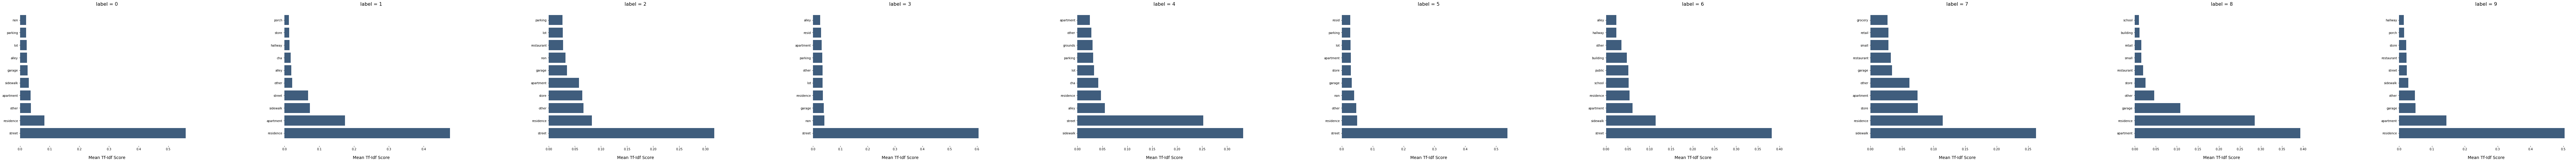

IUCR         Primary Type                   Description  \
0   910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
1   486              BATTERY       DOMESTIC BATTERY SIMPLE   
2   810                THEFT                     OVER $500   
3  1320      CRIMINAL DAMAGE                    TO VEHICLE   
4  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
5   820                THEFT                $500 AND UNDER   
6   460              BATTERY                        SIMPLE   
7   820                THEFT                $500 AND UNDER   
8   610             BURGLARY                FORCIBLE ENTRY   
9  1310      CRIMINAL DAMAGE                   TO PROPERTY   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0               STREET  False    False      15.0  2004.0      5   19    21  
1            RESIDENCE  False    False      25.0  2004.0      6   10    16  
2               STREET  False    False       6.0  2004.0      8   12    12  
3               STREET  False    False       5.0  2004.0      1    6    22  
4             SIDEWALK   True    False      11.0  2004.0      7    8    19  
5               STREET  False    False      12.0  2004.0      6   14    22  
6               STREET   True    False       6.0  2004.0     12   18    22  
7             SIDEWALK  False    False      19.0  2004.0     11   19    22  
8            APARTMENT  False    False       3.0  2004.0      9   18    15  
9            RESIDENCE  False    False       8.0  2004.0      9   11    20

Primary Type
The test has an accuracy of: 
0.512532136439


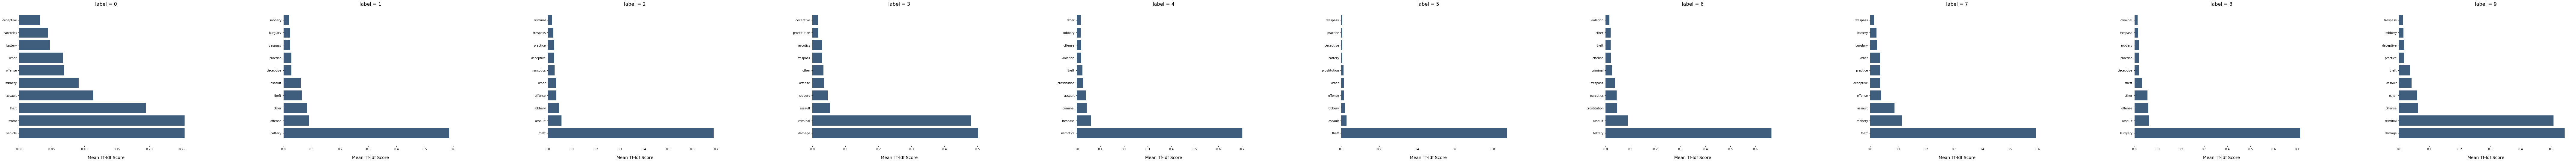

IUCR         Primary Type                   Description  \
0   910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
1   486              BATTERY       DOMESTIC BATTERY SIMPLE   
2   810                THEFT                     OVER $500   
3  1320      CRIMINAL DAMAGE                    TO VEHICLE   
4  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
5   820                THEFT                $500 AND UNDER   
6   460              BATTERY                        SIMPLE   
7   820                THEFT                $500 AND UNDER   
8   610             BURGLARY                FORCIBLE ENTRY   
9  1310      CRIMINAL DAMAGE                   TO PROPERTY   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0               STREET  False    False      15.0  2004.0      5   19    21  
1            RESIDENCE  False    False      25.0  2004.0      6   10    16  
2               STREET  False    False       6.0  2004.0      8   12    12  
3               STREET  False    False       5.0  2004.0      1    6    22  
4             SIDEWALK   True    False      11.0  2004.0      7    8    19  
5               STREET  False    False      12.0  2004.0      6   14    22  
6               STREET   True    False       6.0  2004.0     12   18    22  
7             SIDEWALK  False    False      19.0  2004.0     11   19    22  
8            APARTMENT  False    False       3.0  2004.0      9   18    15  
9            RESIDENCE  False    False       8.0  2004.0      9   11    20

District
The test has an accuracy of: 
0.225182930499


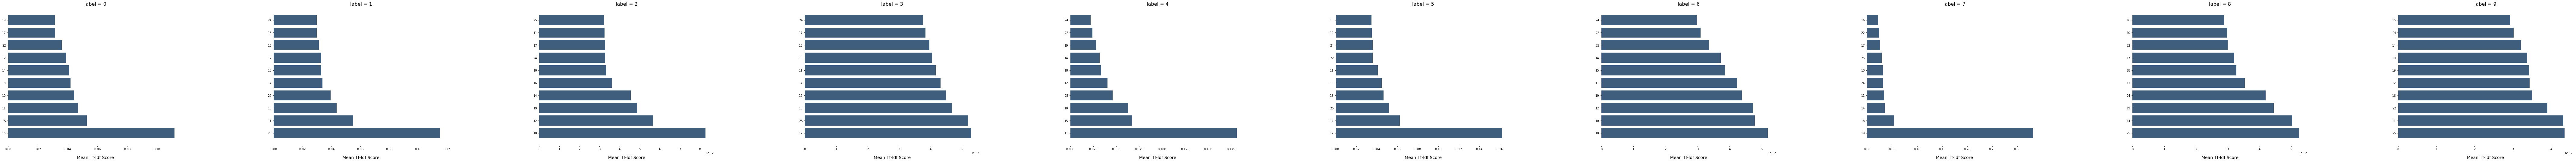

IUCR         Primary Type                   Description  \
0   910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
1   486              BATTERY       DOMESTIC BATTERY SIMPLE   
2   810                THEFT                     OVER $500   
3  1320      CRIMINAL DAMAGE                    TO VEHICLE   
4  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
5   820                THEFT                $500 AND UNDER   
6   460              BATTERY                        SIMPLE   
7   820                THEFT                $500 AND UNDER   
8   610             BURGLARY                FORCIBLE ENTRY   
9  1310      CRIMINAL DAMAGE                   TO PROPERTY   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0               STREET  False    False      15.0  2004.0      5   19    21  
1            RESIDENCE  False    False      25.0  2004.0      6   10    16  
2               STREET  False    False       6.0  2004.0      8   12    12  
3               STREET  False    False       5.0  2004.0      1    6    22  
4             SIDEWALK   True    False      11.0  2004.0      7    8    19  
5               STREET  False    False      12.0  2004.0      6   14    22  
6               STREET   True    False       6.0  2004.0     12   18    22  
7             SIDEWALK  False    False      19.0  2004.0     11   19    22  
8            APARTMENT  False    False       3.0  2004.0      9   18    15  
9            RESIDENCE  False    False       8.0  2004.0      9   11    20

Day
The test has an accuracy of: 
0.200686150592


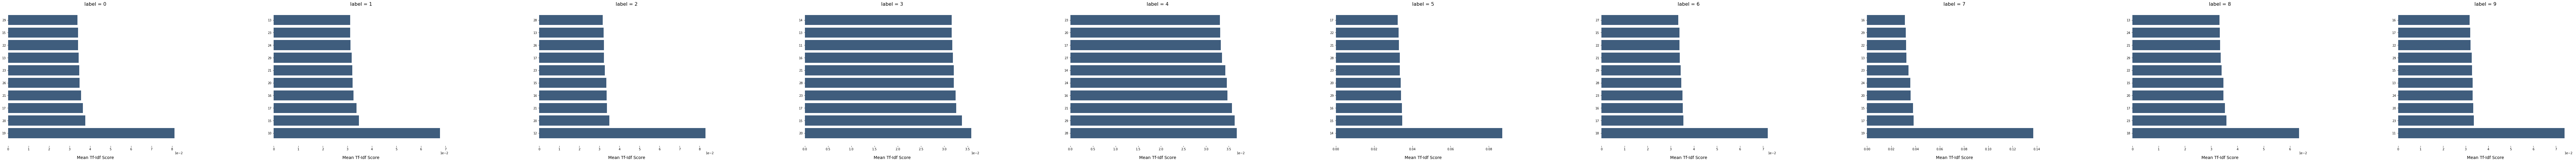

IUCR         Primary Type                   Description  \
0   910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
1   486              BATTERY       DOMESTIC BATTERY SIMPLE   
2   810                THEFT                     OVER $500   
3  1320      CRIMINAL DAMAGE                    TO VEHICLE   
4  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
5   820                THEFT                $500 AND UNDER   
6   460              BATTERY                        SIMPLE   
7   820                THEFT                $500 AND UNDER   
8   610             BURGLARY                FORCIBLE ENTRY   
9  1310      CRIMINAL DAMAGE                   TO PROPERTY   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0               STREET  False    False      15.0  2004.0      5   19    21  
1            RESIDENCE  False    False      25.0  2004.0      6   10    16  
2               STREET  False    False       6.0  2004.0      8   12    12  
3               STREET  False    False       5.0  2004.0      1    6    22  
4             SIDEWALK   True    False      11.0  2004.0      7    8    19  
5               STREET  False    False      12.0  2004.0      6   14    22  
6               STREET   True    False       6.0  2004.0     12   18    22  
7             SIDEWALK  False    False      19.0  2004.0     11   19    22  
8            APARTMENT  False    False       3.0  2004.0      9   18    15  
9            RESIDENCE  False    False       8.0  2004.0      9   11    20

Hour
The test has an accuracy of: 
0.22465842942


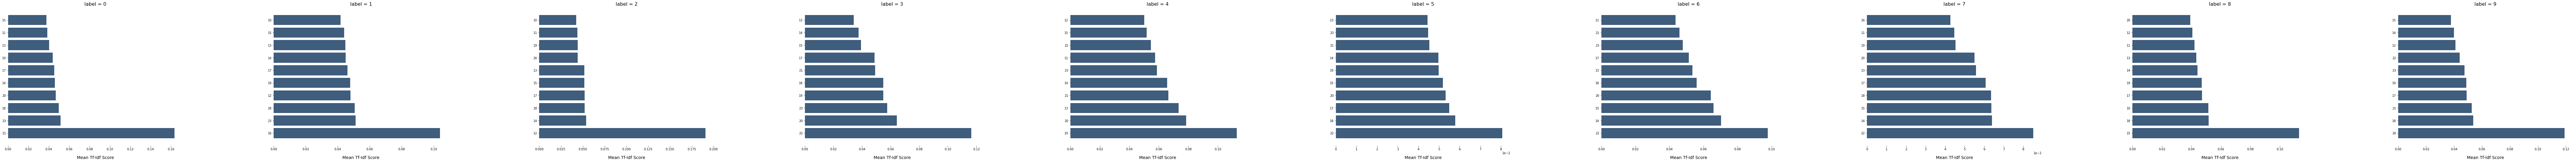

IUCR         Primary Type                   Description  \
0   910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
1   486              BATTERY       DOMESTIC BATTERY SIMPLE   
2   810                THEFT                     OVER $500   
3  1320      CRIMINAL DAMAGE                    TO VEHICLE   
4  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
5   820                THEFT                $500 AND UNDER   
6   460              BATTERY                        SIMPLE   
7   820                THEFT                $500 AND UNDER   
8   610             BURGLARY                FORCIBLE ENTRY   
9  1310      CRIMINAL DAMAGE                   TO PROPERTY   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0               STREET  False    False      15.0  2004.0      5   19    21  
1            RESIDENCE  False    False      25.0  2004.0      6   10    16  
2               STREET  False    False       6.0  2004.0      8   12    12  
3               STREET  False    False       5.0  2004.0      1    6    22  
4             SIDEWALK   True    False      11.0  2004.0      7    8    19  
5               STREET  False    False      12.0  2004.0      6   14    22  
6               STREET   True    False       6.0  2004.0     12   18    22  
7             SIDEWALK  False    False      19.0  2004.0     11   19    22  
8            APARTMENT  False    False       3.0  2004.0      9   18    15  
9            RESIDENCE  False    False       8.0  2004.0      9   11    20

In [75]:
getTfidf(2004)

   IUCR Primary Type                     Description  \
0  0560      ASSAULT                          SIMPLE   
1  0840        THEFT   FINANCIAL ID THEFT: OVER $300   
2  0841        THEFT  FINANCIAL ID THEFT:$300 &UNDER   
3  1811    NARCOTICS    POSS: CANNABIS 30GMS OR LESS   
4  2027    NARCOTICS                     POSS: CRACK   

       Location Description Arrest Domestic  District    Year  Month  Day  \
0  SCHOOL, PUBLIC, BUILDING  False    False       9.0  2005.0     10   21   
1                 RESIDENCE  False    False      15.0  2005.0      7   14   
2                 RESIDENCE  False    False       2.0  2005.0     12   26   
3                    STREET   True    False       6.0  2005.0      3   24   
4                    STREET   True    False       6.0  2005.0      3   30   

   Hour  clusters_10  
0    11            0  
1     0            0  
2    15            0  
3    15            2  
4     0            9  
(455811, 12)
   IUCR Primary Type                   Descriptio

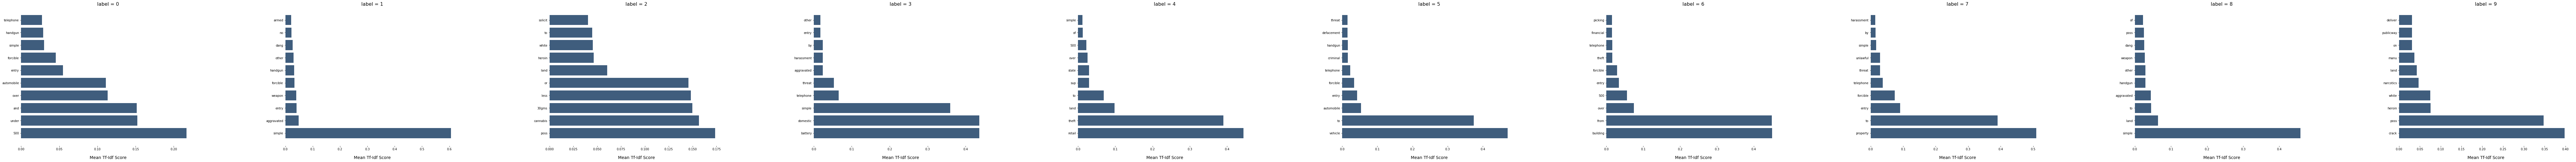

IUCR     Primary Type                   Description Location Description  \
0   820            THEFT                $500 AND UNDER               STREET   
1   460          BATTERY                        SIMPLE             SIDEWALK   
2  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
3   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
4   860            THEFT                  RETAIL THEFT   GROCERY FOOD STORE   
5  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
6   890            THEFT                 FROM BUILDING                OTHER   
7  1310  CRIMINAL DAMAGE                   TO PROPERTY            APARTMENT   
8   460          BATTERY                        SIMPLE             SIDEWALK   
9  2027        NARCOTICS                   POSS: CRACK             SIDEWALK   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       9.0  2005.0     11   23     0  
1  False    False       5.0  2005.0      9   15    10  
2   True    False      15.0  2005.0      4   28    14  
3  False     True       7.0  2005.0      7    7    21  
4   True    False      12.0  2005.0      9    3    13  
5  False    False      10.0  2005.0      6    1    12  
6  False    False       1.0  2005.0      9   20     0  
7  False    False       4.0  2005.0      4   27    20  
8   True    False      10.0  2005.0      8   19    20  
9   True    False      11.0  2005.0     11    1    21

Location Description
The test has an accuracy of: 
0.359441754486


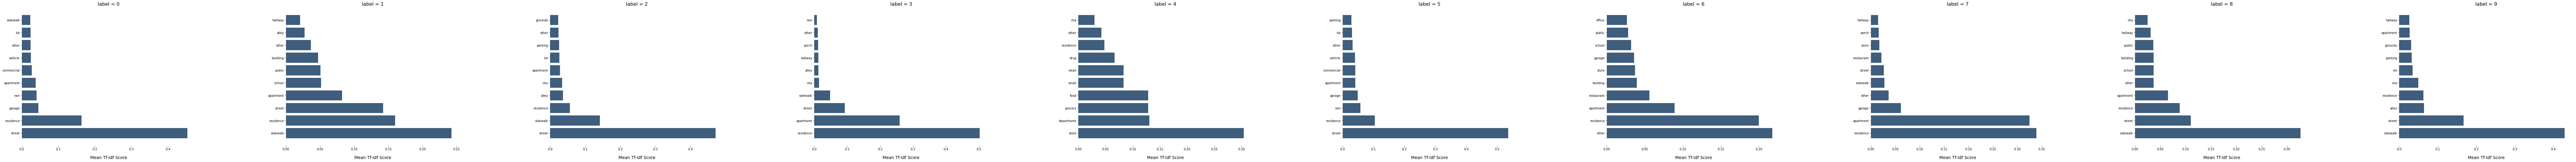

IUCR     Primary Type                   Description Location Description  \
0   820            THEFT                $500 AND UNDER               STREET   
1   460          BATTERY                        SIMPLE             SIDEWALK   
2  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
3   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
4   860            THEFT                  RETAIL THEFT   GROCERY FOOD STORE   
5  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
6   890            THEFT                 FROM BUILDING                OTHER   
7  1310  CRIMINAL DAMAGE                   TO PROPERTY            APARTMENT   
8   460          BATTERY                        SIMPLE             SIDEWALK   
9  2027        NARCOTICS                   POSS: CRACK             SIDEWALK   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       9.0  2005.0     11   23     0  
1  False    False       5.0  2005.0      9   15    10  
2   True    False      15.0  2005.0      4   28    14  
3  False     True       7.0  2005.0      7    7    21  
4   True    False      12.0  2005.0      9    3    13  
5  False    False      10.0  2005.0      6    1    12  
6  False    False       1.0  2005.0      9   20     0  
7  False    False       4.0  2005.0      4   27    20  
8   True    False      10.0  2005.0      8   19    20  
9   True    False      11.0  2005.0     11    1    21

Primary Type
The test has an accuracy of: 
0.489888920535


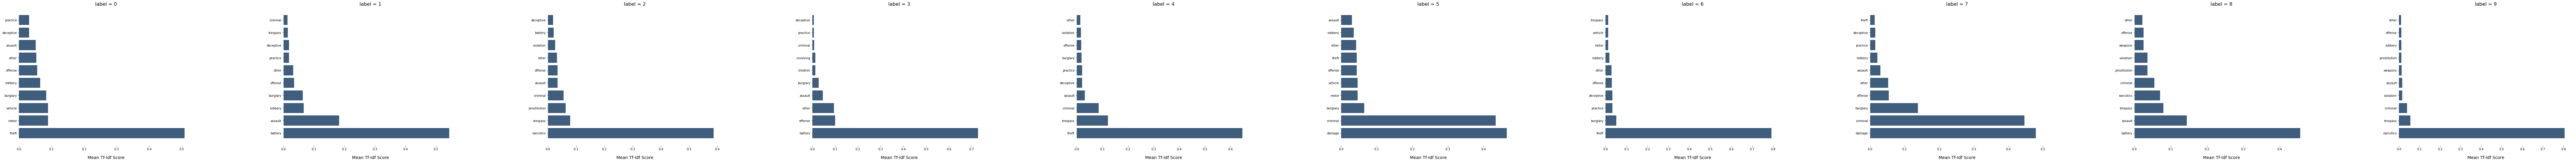

IUCR     Primary Type                   Description Location Description  \
0   820            THEFT                $500 AND UNDER               STREET   
1   460          BATTERY                        SIMPLE             SIDEWALK   
2  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
3   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
4   860            THEFT                  RETAIL THEFT   GROCERY FOOD STORE   
5  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
6   890            THEFT                 FROM BUILDING                OTHER   
7  1310  CRIMINAL DAMAGE                   TO PROPERTY            APARTMENT   
8   460          BATTERY                        SIMPLE             SIDEWALK   
9  2027        NARCOTICS                   POSS: CRACK             SIDEWALK   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       9.0  2005.0     11   23     0  
1  False    False       5.0  2005.0      9   15    10  
2   True    False      15.0  2005.0      4   28    14  
3  False     True       7.0  2005.0      7    7    21  
4   True    False      12.0  2005.0      9    3    13  
5  False    False      10.0  2005.0      6    1    12  
6  False    False       1.0  2005.0      9   20     0  
7  False    False       4.0  2005.0      4   27    20  
8   True    False      10.0  2005.0      8   19    20  
9   True    False      11.0  2005.0     11    1    21

District
The test has an accuracy of: 
0.26055108852


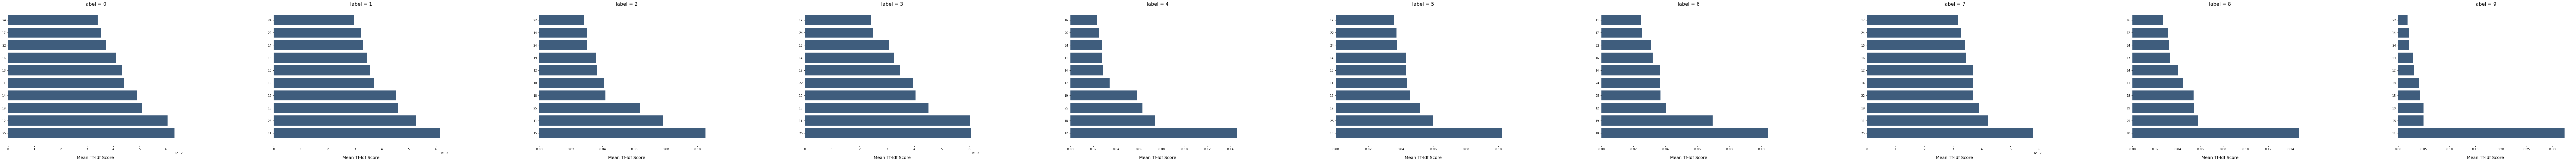

IUCR     Primary Type                   Description Location Description  \
0   820            THEFT                $500 AND UNDER               STREET   
1   460          BATTERY                        SIMPLE             SIDEWALK   
2  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
3   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
4   860            THEFT                  RETAIL THEFT   GROCERY FOOD STORE   
5  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
6   890            THEFT                 FROM BUILDING                OTHER   
7  1310  CRIMINAL DAMAGE                   TO PROPERTY            APARTMENT   
8   460          BATTERY                        SIMPLE             SIDEWALK   
9  2027        NARCOTICS                   POSS: CRACK             SIDEWALK   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       9.0  2005.0     11   23     0  
1  False    False       5.0  2005.0      9   15    10  
2   True    False      15.0  2005.0      4   28    14  
3  False     True       7.0  2005.0      7    7    21  
4   True    False      12.0  2005.0      9    3    13  
5  False    False      10.0  2005.0      6    1    12  
6  False    False       1.0  2005.0      9   20     0  
7  False    False       4.0  2005.0      4   27    20  
8   True    False      10.0  2005.0      8   19    20  
9   True    False      11.0  2005.0     11    1    21

Day
The test has an accuracy of: 
0.250502085022


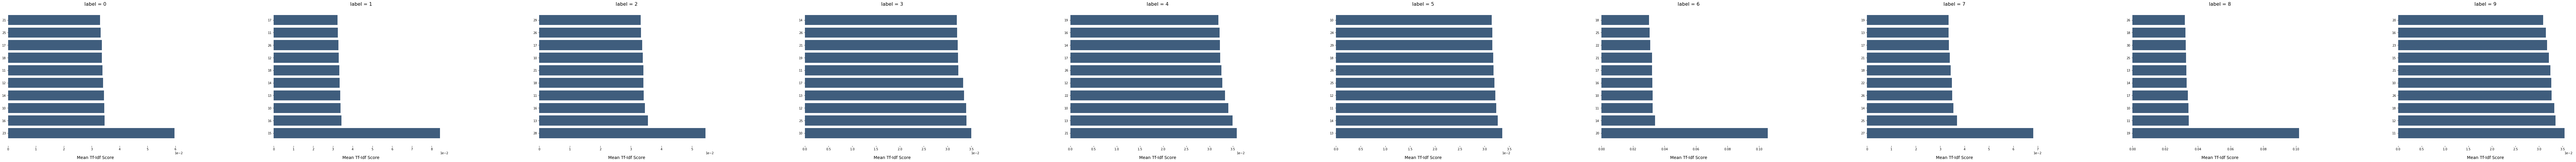

IUCR     Primary Type                   Description Location Description  \
0   820            THEFT                $500 AND UNDER               STREET   
1   460          BATTERY                        SIMPLE             SIDEWALK   
2  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
3   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
4   860            THEFT                  RETAIL THEFT   GROCERY FOOD STORE   
5  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
6   890            THEFT                 FROM BUILDING                OTHER   
7  1310  CRIMINAL DAMAGE                   TO PROPERTY            APARTMENT   
8   460          BATTERY                        SIMPLE             SIDEWALK   
9  2027        NARCOTICS                   POSS: CRACK             SIDEWALK   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       9.0  2005.0     11   23     0  
1  False    False       5.0  2005.0      9   15    10  
2   True    False      15.0  2005.0      4   28    14  
3  False     True       7.0  2005.0      7    7    21  
4   True    False      12.0  2005.0      9    3    13  
5  False    False      10.0  2005.0      6    1    12  
6  False    False       1.0  2005.0      9   20     0  
7  False    False       4.0  2005.0      4   27    20  
8   True    False      10.0  2005.0      8   19    20  
9   True    False      11.0  2005.0     11    1    21

Hour
The test has an accuracy of: 
0.256475983904


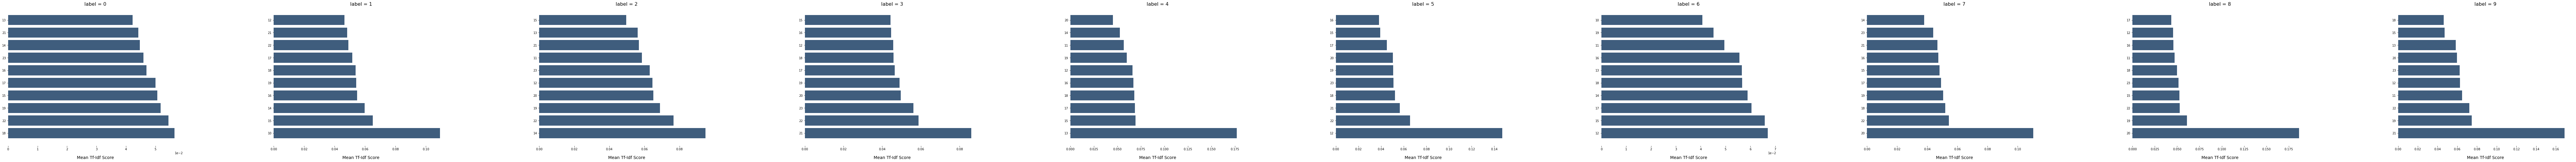

IUCR     Primary Type                   Description Location Description  \
0   820            THEFT                $500 AND UNDER               STREET   
1   460          BATTERY                        SIMPLE             SIDEWALK   
2  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
3   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
4   860            THEFT                  RETAIL THEFT   GROCERY FOOD STORE   
5  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
6   890            THEFT                 FROM BUILDING                OTHER   
7  1310  CRIMINAL DAMAGE                   TO PROPERTY            APARTMENT   
8   460          BATTERY                        SIMPLE             SIDEWALK   
9  2027        NARCOTICS                   POSS: CRACK             SIDEWALK   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       9.0  2005.0     11   23     0  
1  False    False       5.0  2005.0      9   15    10  
2   True    False      15.0  2005.0      4   28    14  
3  False     True       7.0  2005.0      7    7    21  
4   True    False      12.0  2005.0      9    3    13  
5  False    False      10.0  2005.0      6    1    12  
6  False    False       1.0  2005.0      9   20     0  
7  False    False       4.0  2005.0      4   27    20  
8   True    False      10.0  2005.0      8   19    20  
9   True    False      11.0  2005.0     11    1    21

In [76]:
getTfidf(2005)

   IUCR   Primary Type                   Description Location Description  \
0  2825  OTHER OFFENSE       HARASSMENT BY TELEPHONE            RESIDENCE   
1  2017      NARCOTICS            MANU/DELIVER:CRACK             SIDEWALK   
2  051A        ASSAULT           AGGRAVATED: HANDGUN                OTHER   
3  0460        BATTERY                        SIMPLE            RESIDENCE   
4  1811      NARCOTICS  POSS: CANNABIS 30GMS OR LESS                ALLEY   

  Arrest Domestic  District    Year  Month  Day  Hour  clusters_10  
0  False    False      16.0  2006.0      4    2    13            1  
1   True    False       3.0  2006.0      2   26    13            5  
2  False    False       3.0  2006.0      1    8    23            0  
3  False    False      16.0  2006.0      4    5    18            3  
4   True    False       8.0  2006.0      2   17    21            5  
(794684, 12)
   IUCR     Primary Type              Description Location Description Arrest  \
0  1310  CRIMINAL DAMAGE     

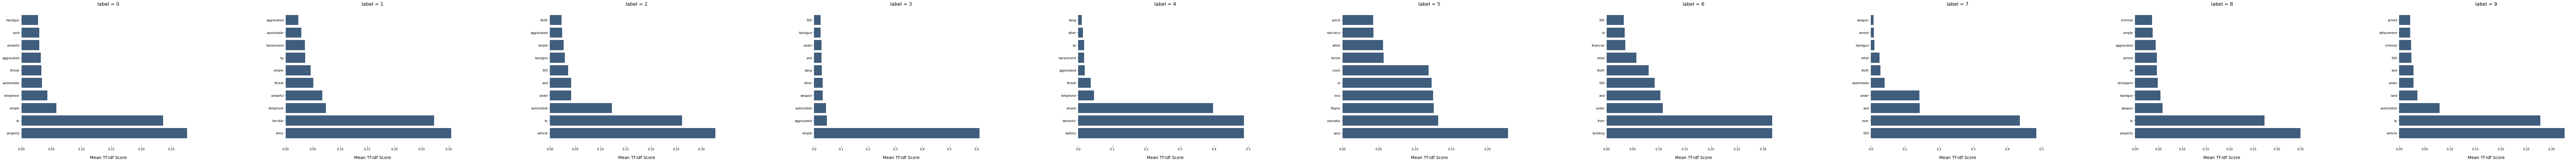

IUCR     Primary Type                   Description  \
0  1310  CRIMINAL DAMAGE                   TO PROPERTY   
1   610         BURGLARY                FORCIBLE ENTRY   
2  1320  CRIMINAL DAMAGE                    TO VEHICLE   
3   460          BATTERY                        SIMPLE   
4   486          BATTERY       DOMESTIC BATTERY SIMPLE   
5  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
6   890            THEFT                 FROM BUILDING   
7   810            THEFT                     OVER $500   
8  1310  CRIMINAL DAMAGE                   TO PROPERTY   
9  1320  CRIMINAL DAMAGE                    TO VEHICLE   

             Location Description Arrest Domestic  District    Year  Month  \
0                       APARTMENT  False    False      25.0  2006.0      7   
1                       RESIDENCE  False    False      12.0  2006.0      7   
2                          STREET  False    False       8.0  2006.0     11   
3                          STREET  False    False       7.0  2006.0      6   
4                       RESIDENCE  False     True       7.0  2006.0      4   
5                          STREET   True    False      11.0  2006.0     10   
6                       RESIDENCE  False    False       5.0  2006.0     12   
7                          STREET  False    False      17.0  2006.0      7   
8                        SIDEWALK  False    False       8.0  2006.0      6   
9  PARKING LOT/GARAGE(NON.RESID.)  False    False      18.0  2006.0      2   

   Day  Hour  
0   10    18  
1   30    22  
2    6     0  
3   22    17  
4    1     0  
5   20    21  
6   12    15  
7   17     1  
8   14    15  
9   16     8

Location Description
The test has an accuracy of: 
0.330644722695


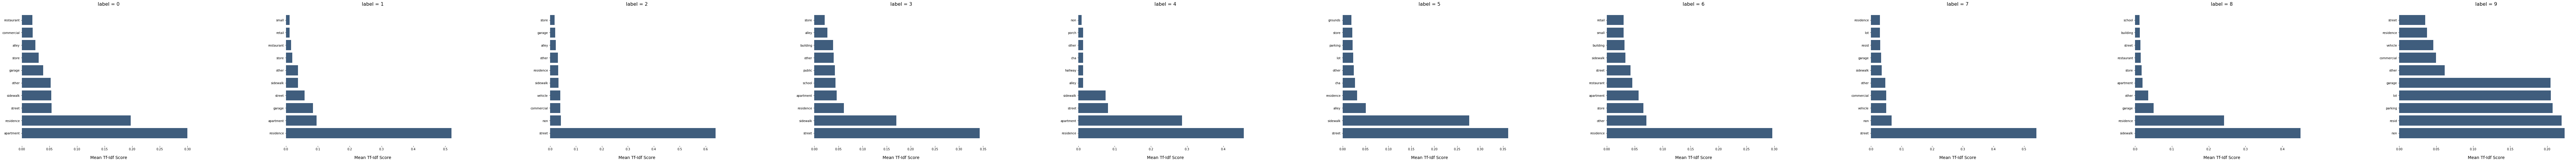

IUCR     Primary Type                   Description  \
0  1310  CRIMINAL DAMAGE                   TO PROPERTY   
1   610         BURGLARY                FORCIBLE ENTRY   
2  1320  CRIMINAL DAMAGE                    TO VEHICLE   
3   460          BATTERY                        SIMPLE   
4   486          BATTERY       DOMESTIC BATTERY SIMPLE   
5  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
6   890            THEFT                 FROM BUILDING   
7   810            THEFT                     OVER $500   
8  1310  CRIMINAL DAMAGE                   TO PROPERTY   
9  1320  CRIMINAL DAMAGE                    TO VEHICLE   

             Location Description Arrest Domestic  District    Year  Month  \
0                       APARTMENT  False    False      25.0  2006.0      7   
1                       RESIDENCE  False    False      12.0  2006.0      7   
2                          STREET  False    False       8.0  2006.0     11   
3                          STREET  False    False       7.0  2006.0      6   
4                       RESIDENCE  False     True       7.0  2006.0      4   
5                          STREET   True    False      11.0  2006.0     10   
6                       RESIDENCE  False    False       5.0  2006.0     12   
7                          STREET  False    False      17.0  2006.0      7   
8                        SIDEWALK  False    False       8.0  2006.0      6   
9  PARKING LOT/GARAGE(NON.RESID.)  False    False      18.0  2006.0      2   

   Day  Hour  
0   10    18  
1   30    22  
2    6     0  
3   22    17  
4    1     0  
5   20    21  
6   12    15  
7   17     1  
8   14    15  
9   16     8

Primary Type
The test has an accuracy of: 
0.491212510407


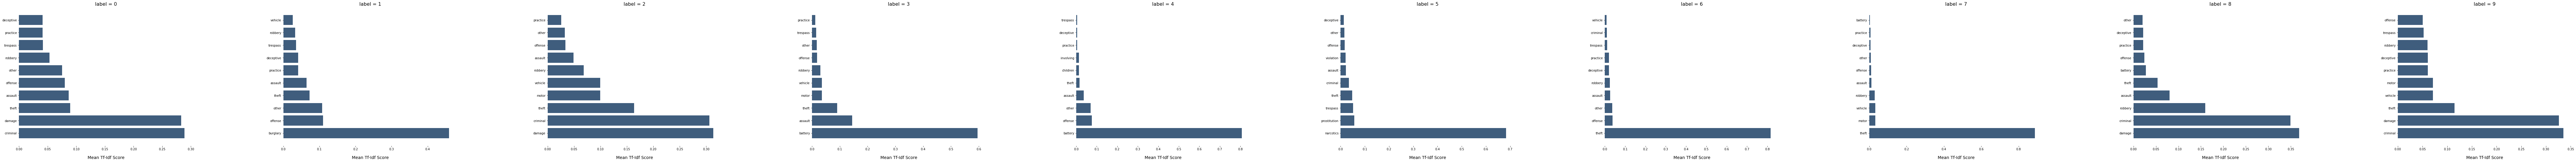

IUCR     Primary Type                   Description  \
0  1310  CRIMINAL DAMAGE                   TO PROPERTY   
1   610         BURGLARY                FORCIBLE ENTRY   
2  1320  CRIMINAL DAMAGE                    TO VEHICLE   
3   460          BATTERY                        SIMPLE   
4   486          BATTERY       DOMESTIC BATTERY SIMPLE   
5  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
6   890            THEFT                 FROM BUILDING   
7   810            THEFT                     OVER $500   
8  1310  CRIMINAL DAMAGE                   TO PROPERTY   
9  1320  CRIMINAL DAMAGE                    TO VEHICLE   

             Location Description Arrest Domestic  District    Year  Month  \
0                       APARTMENT  False    False      25.0  2006.0      7   
1                       RESIDENCE  False    False      12.0  2006.0      7   
2                          STREET  False    False       8.0  2006.0     11   
3                          STREET  False    False       7.0  2006.0      6   
4                       RESIDENCE  False     True       7.0  2006.0      4   
5                          STREET   True    False      11.0  2006.0     10   
6                       RESIDENCE  False    False       5.0  2006.0     12   
7                          STREET  False    False      17.0  2006.0      7   
8                        SIDEWALK  False    False       8.0  2006.0      6   
9  PARKING LOT/GARAGE(NON.RESID.)  False    False      18.0  2006.0      2   

   Day  Hour  
0   10    18  
1   30    22  
2    6     0  
3   22    17  
4    1     0  
5   20    21  
6   12    15  
7   17     1  
8   14    15  
9   16     8

District
The test has an accuracy of: 
0.216237925307


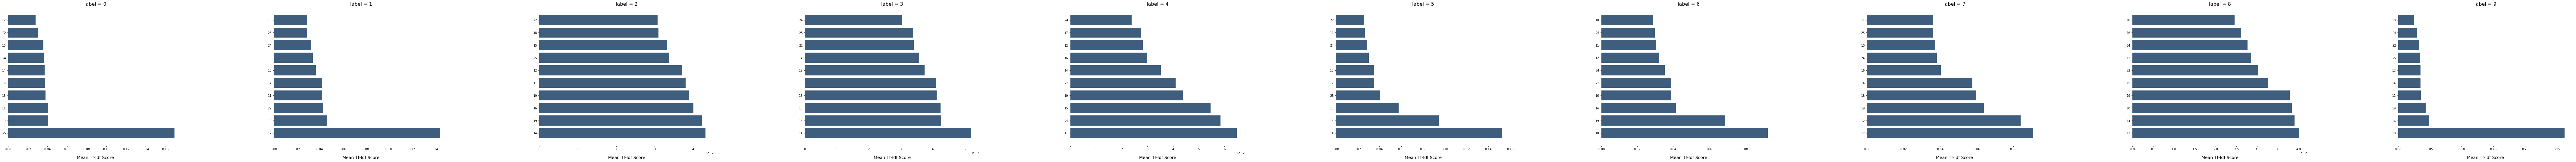

IUCR     Primary Type                   Description  \
0  1310  CRIMINAL DAMAGE                   TO PROPERTY   
1   610         BURGLARY                FORCIBLE ENTRY   
2  1320  CRIMINAL DAMAGE                    TO VEHICLE   
3   460          BATTERY                        SIMPLE   
4   486          BATTERY       DOMESTIC BATTERY SIMPLE   
5  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
6   890            THEFT                 FROM BUILDING   
7   810            THEFT                     OVER $500   
8  1310  CRIMINAL DAMAGE                   TO PROPERTY   
9  1320  CRIMINAL DAMAGE                    TO VEHICLE   

             Location Description Arrest Domestic  District    Year  Month  \
0                       APARTMENT  False    False      25.0  2006.0      7   
1                       RESIDENCE  False    False      12.0  2006.0      7   
2                          STREET  False    False       8.0  2006.0     11   
3                          STREET  False    False       7.0  2006.0      6   
4                       RESIDENCE  False     True       7.0  2006.0      4   
5                          STREET   True    False      11.0  2006.0     10   
6                       RESIDENCE  False    False       5.0  2006.0     12   
7                          STREET  False    False      17.0  2006.0      7   
8                        SIDEWALK  False    False       8.0  2006.0      6   
9  PARKING LOT/GARAGE(NON.RESID.)  False    False      18.0  2006.0      2   

   Day  Hour  
0   10    18  
1   30    22  
2    6     0  
3   22    17  
4    1     0  
5   20    21  
6   12    15  
7   17     1  
8   14    15  
9   16     8

Day
The test has an accuracy of: 
0.207829044525


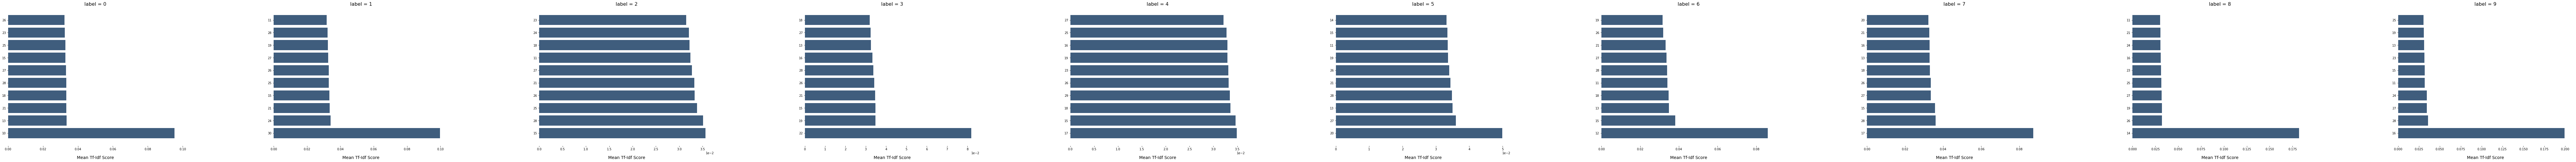

IUCR     Primary Type                   Description  \
0  1310  CRIMINAL DAMAGE                   TO PROPERTY   
1   610         BURGLARY                FORCIBLE ENTRY   
2  1320  CRIMINAL DAMAGE                    TO VEHICLE   
3   460          BATTERY                        SIMPLE   
4   486          BATTERY       DOMESTIC BATTERY SIMPLE   
5  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
6   890            THEFT                 FROM BUILDING   
7   810            THEFT                     OVER $500   
8  1310  CRIMINAL DAMAGE                   TO PROPERTY   
9  1320  CRIMINAL DAMAGE                    TO VEHICLE   

             Location Description Arrest Domestic  District    Year  Month  \
0                       APARTMENT  False    False      25.0  2006.0      7   
1                       RESIDENCE  False    False      12.0  2006.0      7   
2                          STREET  False    False       8.0  2006.0     11   
3                          STREET  False    False       7.0  2006.0      6   
4                       RESIDENCE  False     True       7.0  2006.0      4   
5                          STREET   True    False      11.0  2006.0     10   
6                       RESIDENCE  False    False       5.0  2006.0     12   
7                          STREET  False    False      17.0  2006.0      7   
8                        SIDEWALK  False    False       8.0  2006.0      6   
9  PARKING LOT/GARAGE(NON.RESID.)  False    False      18.0  2006.0      2   

   Day  Hour  
0   10    18  
1   30    22  
2    6     0  
3   22    17  
4    1     0  
5   20    21  
6   12    15  
7   17     1  
8   14    15  
9   16     8

Hour
The test has an accuracy of: 
0.218312952605


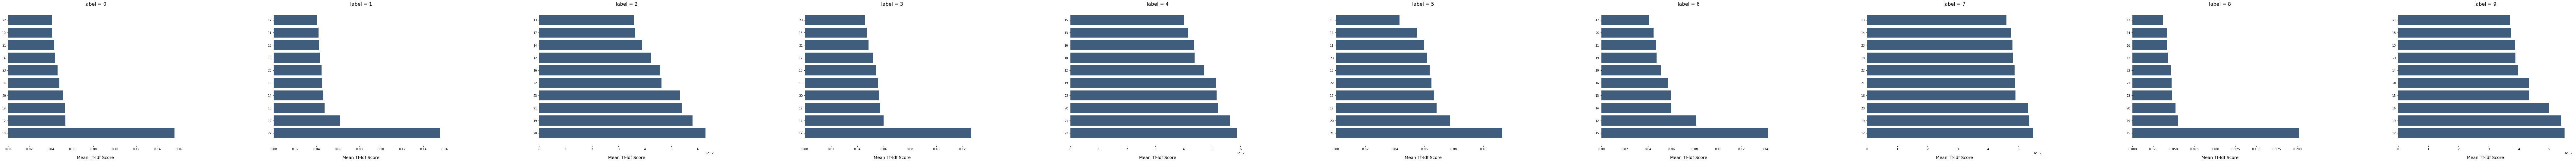

IUCR     Primary Type                   Description  \
0  1310  CRIMINAL DAMAGE                   TO PROPERTY   
1   610         BURGLARY                FORCIBLE ENTRY   
2  1320  CRIMINAL DAMAGE                    TO VEHICLE   
3   460          BATTERY                        SIMPLE   
4   486          BATTERY       DOMESTIC BATTERY SIMPLE   
5  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
6   890            THEFT                 FROM BUILDING   
7   810            THEFT                     OVER $500   
8  1310  CRIMINAL DAMAGE                   TO PROPERTY   
9  1320  CRIMINAL DAMAGE                    TO VEHICLE   

             Location Description Arrest Domestic  District    Year  Month  \
0                       APARTMENT  False    False      25.0  2006.0      7   
1                       RESIDENCE  False    False      12.0  2006.0      7   
2                          STREET  False    False       8.0  2006.0     11   
3                          STREET  False    False       7.0  2006.0      6   
4                       RESIDENCE  False     True       7.0  2006.0      4   
5                          STREET   True    False      11.0  2006.0     10   
6                       RESIDENCE  False    False       5.0  2006.0     12   
7                          STREET  False    False      17.0  2006.0      7   
8                        SIDEWALK  False    False       8.0  2006.0      6   
9  PARKING LOT/GARAGE(NON.RESID.)  False    False      18.0  2006.0      2   

   Day  Hour  
0   10    18  
1   30    22  
2    6     0  
3   22    17  
4    1     0  
5   20    21  
6   12    15  
7   17     1  
8   14    15  
9   16     8

In [77]:
getTfidf(2006)

   IUCR     Primary Type              Description Location Description Arrest  \
0  2825    OTHER OFFENSE  HARASSMENT BY TELEPHONE            RESIDENCE  False   
1  1320  CRIMINAL DAMAGE               TO VEHICLE               STREET  False   
2  5002    OTHER OFFENSE    OTHER VEHICLE OFFENSE               STREET   True   
3  1320  CRIMINAL DAMAGE               TO VEHICLE               STREET  False   
4  2024        NARCOTICS      POSS: HEROIN(WHITE)               STREET   True   

  Domestic  District    Year  Month  Day  Hour  clusters_10  
0     True       2.0  2007.0      1    3    10            0  
1    False      12.0  2007.0      1    4    18            7  
2    False       1.0  2007.0      1    5     9            1  
3    False       1.0  2007.0      1    5    19            7  
4    False      19.0  2007.0      1    4    14            1  
(621848, 12)
   IUCR   Primary Type                   Description Location Description  \
0  2820  OTHER OFFENSE              TELEPHONE THREA

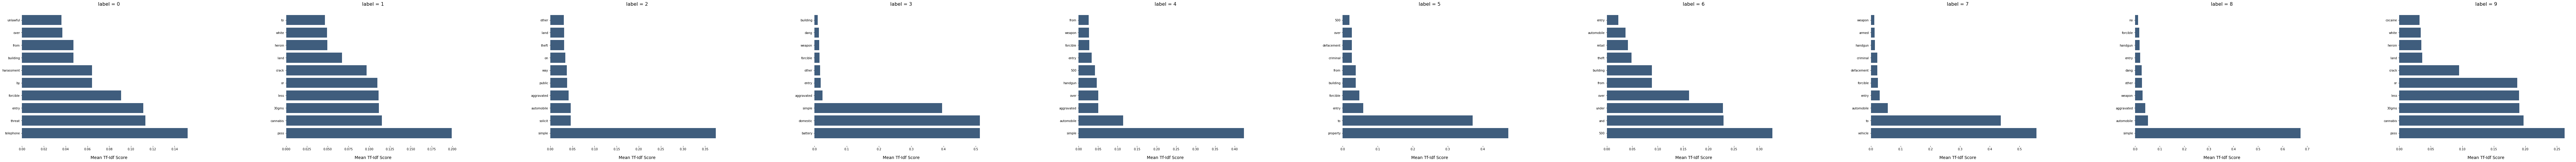

IUCR     Primary Type                   Description Location Description  \
0  2820    OTHER OFFENSE              TELEPHONE THREAT            RESIDENCE   
1  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
2   460          BATTERY                        SIMPLE               STREET   
3   486          BATTERY       DOMESTIC BATTERY SIMPLE            APARTMENT   
4   560          ASSAULT                        SIMPLE               STREET   
5  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
6   820            THEFT                $500 AND UNDER               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   460          BATTERY                        SIMPLE               STREET   
9  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      16.0  2007.0      4    9    20  
1   True    False      11.0  2007.0      1    2    19  
2   True    False      25.0  2007.0      4   17    19  
3  False     True      25.0  2007.0      2   17    18  
4  False    False      15.0  2007.0      1   20    23  
5  False    False       3.0  2007.0      6   12    19  
6  False    False       6.0  2007.0      5    6    16  
7  False    False       8.0  2007.0     12   23     0  
8  False    False      12.0  2007.0      2   28    15  
9   True    False       7.0  2007.0      6   28    13

Location Description
The test has an accuracy of: 
0.331540949892


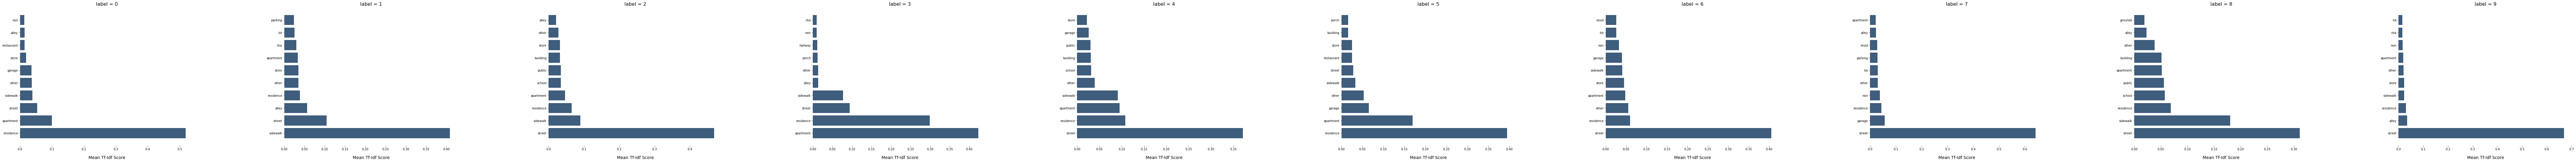

IUCR     Primary Type                   Description Location Description  \
0  2820    OTHER OFFENSE              TELEPHONE THREAT            RESIDENCE   
1  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
2   460          BATTERY                        SIMPLE               STREET   
3   486          BATTERY       DOMESTIC BATTERY SIMPLE            APARTMENT   
4   560          ASSAULT                        SIMPLE               STREET   
5  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
6   820            THEFT                $500 AND UNDER               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   460          BATTERY                        SIMPLE               STREET   
9  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      16.0  2007.0      4    9    20  
1   True    False      11.0  2007.0      1    2    19  
2   True    False      25.0  2007.0      4   17    19  
3  False     True      25.0  2007.0      2   17    18  
4  False    False      15.0  2007.0      1   20    23  
5  False    False       3.0  2007.0      6   12    19  
6  False    False       6.0  2007.0      5    6    16  
7  False    False       8.0  2007.0     12   23     0  
8  False    False      12.0  2007.0      2   28    15  
9   True    False       7.0  2007.0      6   28    13

Primary Type
The test has an accuracy of: 
0.548276526918


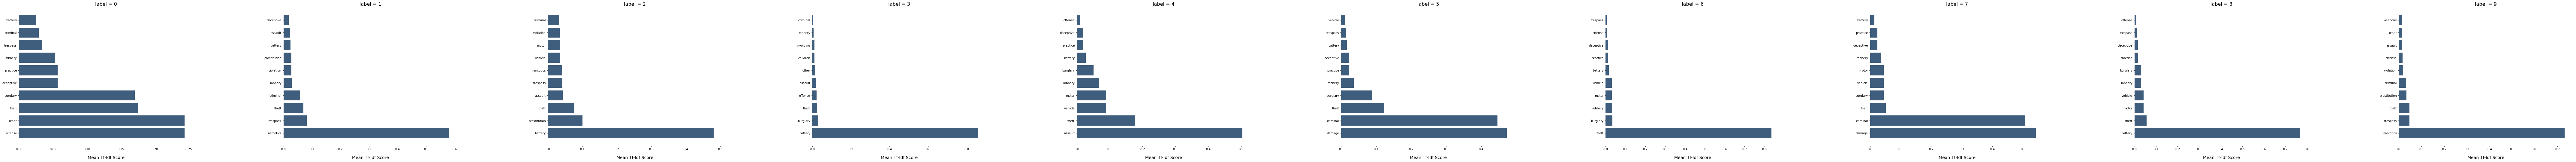

IUCR     Primary Type                   Description Location Description  \
0  2820    OTHER OFFENSE              TELEPHONE THREAT            RESIDENCE   
1  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
2   460          BATTERY                        SIMPLE               STREET   
3   486          BATTERY       DOMESTIC BATTERY SIMPLE            APARTMENT   
4   560          ASSAULT                        SIMPLE               STREET   
5  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
6   820            THEFT                $500 AND UNDER               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   460          BATTERY                        SIMPLE               STREET   
9  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      16.0  2007.0      4    9    20  
1   True    False      11.0  2007.0      1    2    19  
2   True    False      25.0  2007.0      4   17    19  
3  False     True      25.0  2007.0      2   17    18  
4  False    False      15.0  2007.0      1   20    23  
5  False    False       3.0  2007.0      6   12    19  
6  False    False       6.0  2007.0      5    6    16  
7  False    False       8.0  2007.0     12   23     0  
8  False    False      12.0  2007.0      2   28    15  
9   True    False       7.0  2007.0      6   28    13

District
The test has an accuracy of: 
0.200834422331


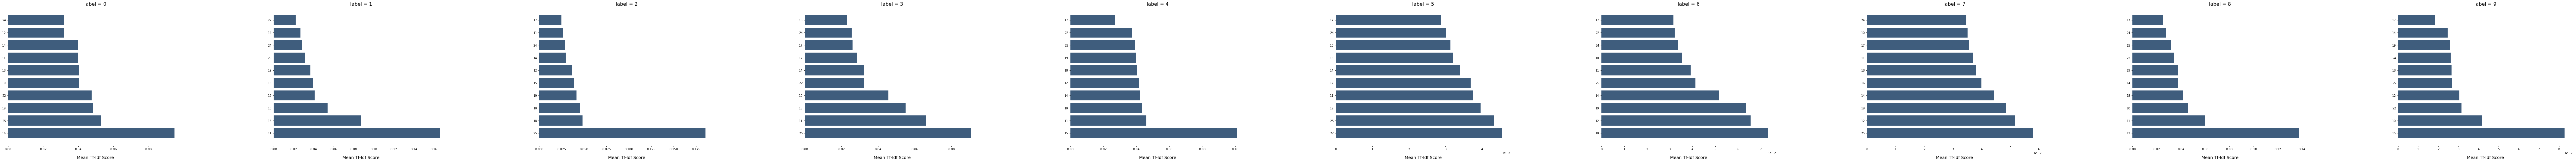

IUCR     Primary Type                   Description Location Description  \
0  2820    OTHER OFFENSE              TELEPHONE THREAT            RESIDENCE   
1  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
2   460          BATTERY                        SIMPLE               STREET   
3   486          BATTERY       DOMESTIC BATTERY SIMPLE            APARTMENT   
4   560          ASSAULT                        SIMPLE               STREET   
5  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
6   820            THEFT                $500 AND UNDER               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   460          BATTERY                        SIMPLE               STREET   
9  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      16.0  2007.0      4    9    20  
1   True    False      11.0  2007.0      1    2    19  
2   True    False      25.0  2007.0      4   17    19  
3  False     True      25.0  2007.0      2   17    18  
4  False    False      15.0  2007.0      1   20    23  
5  False    False       3.0  2007.0      6   12    19  
6  False    False       6.0  2007.0      5    6    16  
7  False    False       8.0  2007.0     12   23     0  
8  False    False      12.0  2007.0      2   28    15  
9   True    False       7.0  2007.0      6   28    13

Day
The test has an accuracy of: 
0.171179759635


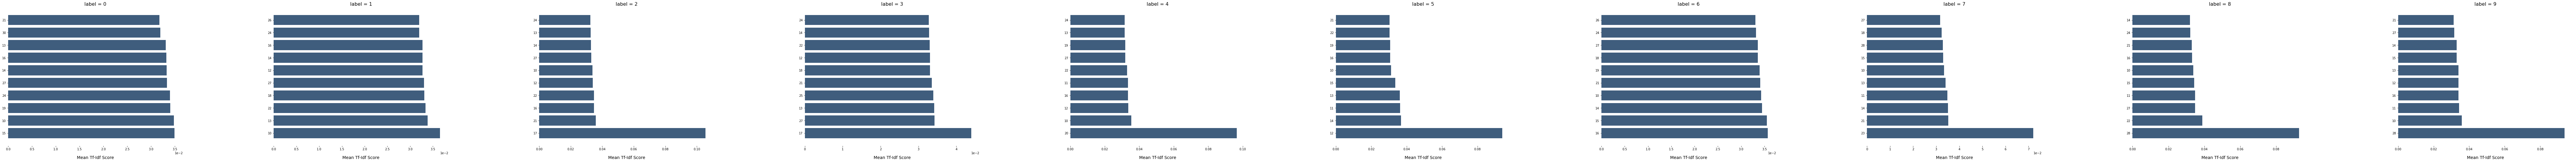

IUCR     Primary Type                   Description Location Description  \
0  2820    OTHER OFFENSE              TELEPHONE THREAT            RESIDENCE   
1  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
2   460          BATTERY                        SIMPLE               STREET   
3   486          BATTERY       DOMESTIC BATTERY SIMPLE            APARTMENT   
4   560          ASSAULT                        SIMPLE               STREET   
5  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
6   820            THEFT                $500 AND UNDER               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   460          BATTERY                        SIMPLE               STREET   
9  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      16.0  2007.0      4    9    20  
1   True    False      11.0  2007.0      1    2    19  
2   True    False      25.0  2007.0      4   17    19  
3  False     True      25.0  2007.0      2   17    18  
4  False    False      15.0  2007.0      1   20    23  
5  False    False       3.0  2007.0      6   12    19  
6  False    False       6.0  2007.0      5    6    16  
7  False    False       8.0  2007.0     12   23     0  
8  False    False      12.0  2007.0      2   28    15  
9   True    False       7.0  2007.0      6   28    13

Hour
The test has an accuracy of: 
0.199672229482


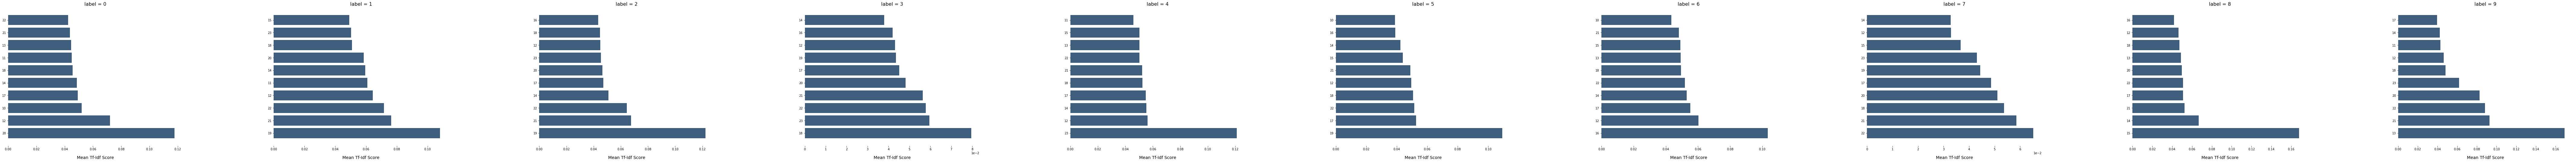

IUCR     Primary Type                   Description Location Description  \
0  2820    OTHER OFFENSE              TELEPHONE THREAT            RESIDENCE   
1  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
2   460          BATTERY                        SIMPLE               STREET   
3   486          BATTERY       DOMESTIC BATTERY SIMPLE            APARTMENT   
4   560          ASSAULT                        SIMPLE               STREET   
5  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
6   820            THEFT                $500 AND UNDER               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   460          BATTERY                        SIMPLE               STREET   
9  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      16.0  2007.0      4    9    20  
1   True    False      11.0  2007.0      1    2    19  
2   True    False      25.0  2007.0      4   17    19  
3  False     True      25.0  2007.0      2   17    18  
4  False    False      15.0  2007.0      1   20    23  
5  False    False       3.0  2007.0      6   12    19  
6  False    False       6.0  2007.0      5    6    16  
7  False    False       8.0  2007.0     12   23     0  
8  False    False      12.0  2007.0      2   28    15  
9   True    False       7.0  2007.0      6   28    13

In [78]:
getTfidf(2007)

//anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


   IUCR Primary Type          Description Location Description Arrest  \
0  0110     HOMICIDE  FIRST DEGREE MURDER                ALLEY   True   
1  0110     HOMICIDE  FIRST DEGREE MURDER               STREET   True   
2  0110     HOMICIDE  FIRST DEGREE MURDER        PARK PROPERTY  False   
3  0110     HOMICIDE  FIRST DEGREE MURDER           RESTAURANT  False   
4  0110     HOMICIDE  FIRST DEGREE MURDER               GARAGE  False   

  Domestic  District    Year  Month  Day  Hour  clusters_10  
0    False       3.0  2008.0     10    7    12            2  
1    False      15.0  2008.0     10    9     3            7  
2    False       8.0  2008.0     10    9     8            7  
3    False      15.0  2008.0     10   10     2            7  
4     True      10.0  2008.0     10   10    12            2  
(852053, 12)
   IUCR     Primary Type              Description Location Description Arrest  \
0   560          ASSAULT                   SIMPLE            RESIDENCE  False   
1  1320  CRIMI

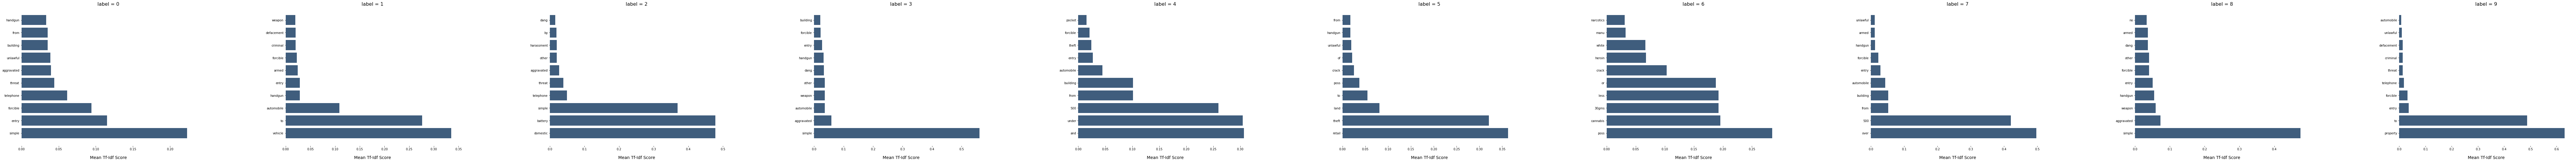

IUCR     Primary Type                   Description Location Description  \
0   560          ASSAULT                        SIMPLE            RESIDENCE   
1  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
2   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
3   460          BATTERY                        SIMPLE               STREET   
4   820            THEFT                $500 AND UNDER               STREET   
5   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   
6  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
7   810            THEFT                     OVER $500               STREET   
8   460          BATTERY                        SIMPLE             SIDEWALK   
9  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       8.0  2008.0      9    4    15  
1  False    False       6.0  2008.0      6    1    20  
2  False     True       7.0  2008.0     10   12    21  
3  False    False      22.0  2008.0      6   11    14  
4  False    False      19.0  2008.0      5   27    22  
5   True    False      12.0  2008.0      2   12    22  
6   True    False      11.0  2008.0     12   22    21  
7  False    False      24.0  2008.0     10   29    18  
8  False    False      17.0  2008.0      1   29    17  
9  False    False       7.0  2008.0      9   23    22

Location Description
The test has an accuracy of: 
0.345429185979


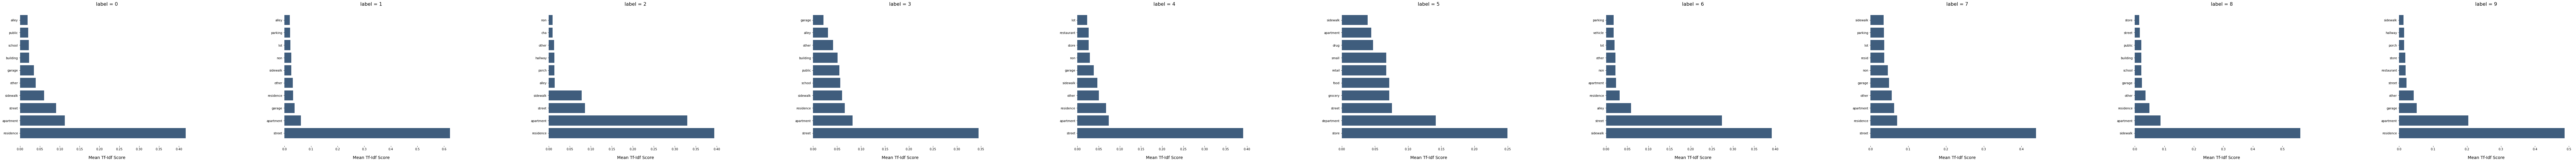

IUCR     Primary Type                   Description Location Description  \
0   560          ASSAULT                        SIMPLE            RESIDENCE   
1  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
2   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
3   460          BATTERY                        SIMPLE               STREET   
4   820            THEFT                $500 AND UNDER               STREET   
5   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   
6  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
7   810            THEFT                     OVER $500               STREET   
8   460          BATTERY                        SIMPLE             SIDEWALK   
9  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       8.0  2008.0      9    4    15  
1  False    False       6.0  2008.0      6    1    20  
2  False     True       7.0  2008.0     10   12    21  
3  False    False      22.0  2008.0      6   11    14  
4  False    False      19.0  2008.0      5   27    22  
5   True    False      12.0  2008.0      2   12    22  
6   True    False      11.0  2008.0     12   22    21  
7  False    False      24.0  2008.0     10   29    18  
8  False    False      17.0  2008.0      1   29    17  
9  False    False       7.0  2008.0      9   23    22

Primary Type
The test has an accuracy of: 
0.506262757651


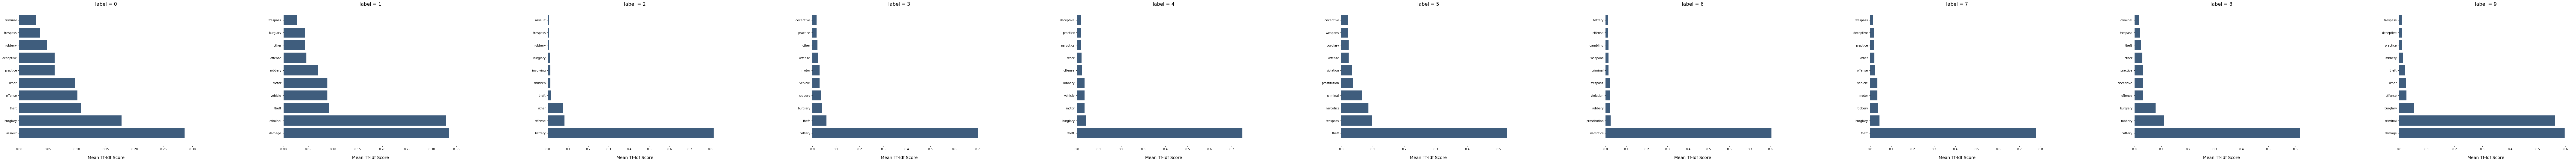

IUCR     Primary Type                   Description Location Description  \
0   560          ASSAULT                        SIMPLE            RESIDENCE   
1  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
2   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
3   460          BATTERY                        SIMPLE               STREET   
4   820            THEFT                $500 AND UNDER               STREET   
5   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   
6  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
7   810            THEFT                     OVER $500               STREET   
8   460          BATTERY                        SIMPLE             SIDEWALK   
9  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       8.0  2008.0      9    4    15  
1  False    False       6.0  2008.0      6    1    20  
2  False     True       7.0  2008.0     10   12    21  
3  False    False      22.0  2008.0      6   11    14  
4  False    False      19.0  2008.0      5   27    22  
5   True    False      12.0  2008.0      2   12    22  
6   True    False      11.0  2008.0     12   22    21  
7  False    False      24.0  2008.0     10   29    18  
8  False    False      17.0  2008.0      1   29    17  
9  False    False       7.0  2008.0      9   23    22

District
The test has an accuracy of: 
0.227629790118


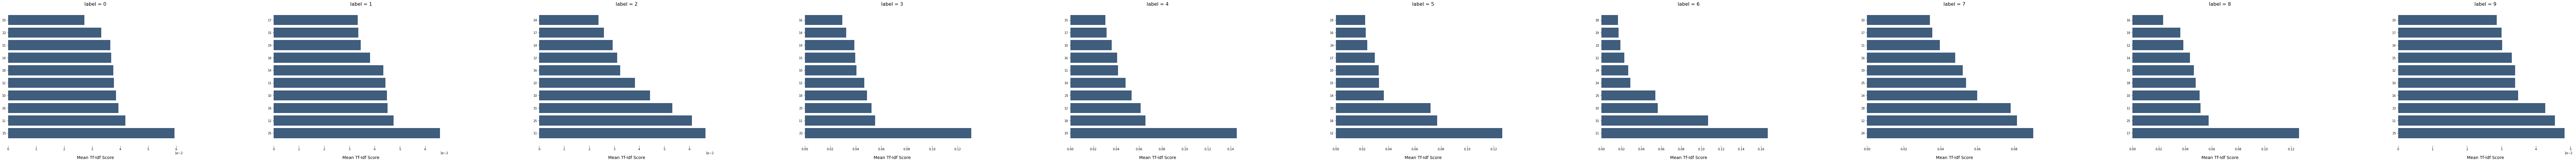

IUCR     Primary Type                   Description Location Description  \
0   560          ASSAULT                        SIMPLE            RESIDENCE   
1  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
2   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
3   460          BATTERY                        SIMPLE               STREET   
4   820            THEFT                $500 AND UNDER               STREET   
5   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   
6  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
7   810            THEFT                     OVER $500               STREET   
8   460          BATTERY                        SIMPLE             SIDEWALK   
9  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       8.0  2008.0      9    4    15  
1  False    False       6.0  2008.0      6    1    20  
2  False     True       7.0  2008.0     10   12    21  
3  False    False      22.0  2008.0      6   11    14  
4  False    False      19.0  2008.0      5   27    22  
5   True    False      12.0  2008.0      2   12    22  
6   True    False      11.0  2008.0     12   22    21  
7  False    False      24.0  2008.0     10   29    18  
8  False    False      17.0  2008.0      1   29    17  
9  False    False       7.0  2008.0      9   23    22

Day
The test has an accuracy of: 
0.20790318094


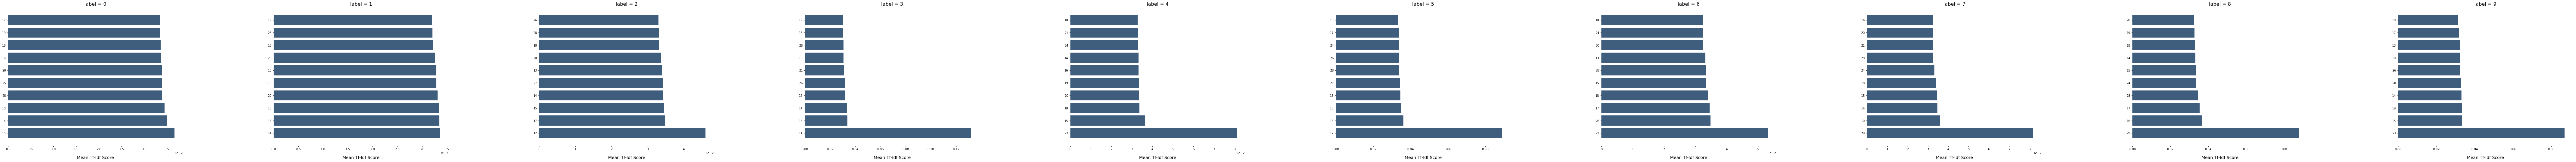

IUCR     Primary Type                   Description Location Description  \
0   560          ASSAULT                        SIMPLE            RESIDENCE   
1  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
2   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
3   460          BATTERY                        SIMPLE               STREET   
4   820            THEFT                $500 AND UNDER               STREET   
5   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   
6  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
7   810            THEFT                     OVER $500               STREET   
8   460          BATTERY                        SIMPLE             SIDEWALK   
9  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       8.0  2008.0      9    4    15  
1  False    False       6.0  2008.0      6    1    20  
2  False     True       7.0  2008.0     10   12    21  
3  False    False      22.0  2008.0      6   11    14  
4  False    False      19.0  2008.0      5   27    22  
5   True    False      12.0  2008.0      2   12    22  
6   True    False      11.0  2008.0     12   22    21  
7  False    False      24.0  2008.0     10   29    18  
8  False    False      17.0  2008.0      1   29    17  
9  False    False       7.0  2008.0      9   23    22

Hour
The test has an accuracy of: 
0.239931985316


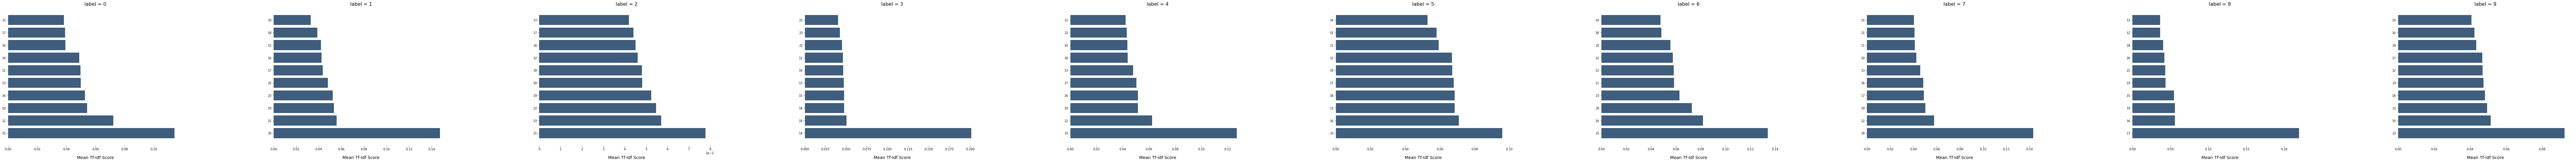

IUCR     Primary Type                   Description Location Description  \
0   560          ASSAULT                        SIMPLE            RESIDENCE   
1  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
2   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
3   460          BATTERY                        SIMPLE               STREET   
4   820            THEFT                $500 AND UNDER               STREET   
5   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   
6  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
7   810            THEFT                     OVER $500               STREET   
8   460          BATTERY                        SIMPLE             SIDEWALK   
9  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       8.0  2008.0      9    4    15  
1  False    False       6.0  2008.0      6    1    20  
2  False     True       7.0  2008.0     10   12    21  
3  False    False      22.0  2008.0      6   11    14  
4  False    False      19.0  2008.0      5   27    22  
5   True    False      12.0  2008.0      2   12    22  
6   True    False      11.0  2008.0     12   22    21  
7  False    False      24.0  2008.0     10   29    18  
8  False    False      17.0  2008.0      1   29    17  
9  False    False       7.0  2008.0      9   23    22

In [79]:
getTfidf(2008)

   IUCR Primary Type                Description Location Description Arrest  \
0  1562  SEX OFFENSE  AGG CRIMINAL SEXUAL ABUSE            RESIDENCE   True   
1  0110     HOMICIDE        FIRST DEGREE MURDER               STREET   True   
2  0110     HOMICIDE        FIRST DEGREE MURDER                ALLEY  False   
3  0110     HOMICIDE        FIRST DEGREE MURDER               STREET   True   
4  0110     HOMICIDE        FIRST DEGREE MURDER               STREET   True   

  Domestic  District    Year  Month  Day  Hour  clusters_10  
0    False      25.0  2009.0      1    1     0            6  
1    False      12.0  2009.0      1    1     5            0  
2    False      22.0  2009.0      1    3     4            4  
3    False       3.0  2009.0      1    3    18            0  
4    False       4.0  2009.0      1    4    16            5  
(783900, 12)
   IUCR     Primary Type                   Description Location Description  \
0  1320  CRIMINAL DAMAGE                    TO VEHICLE       

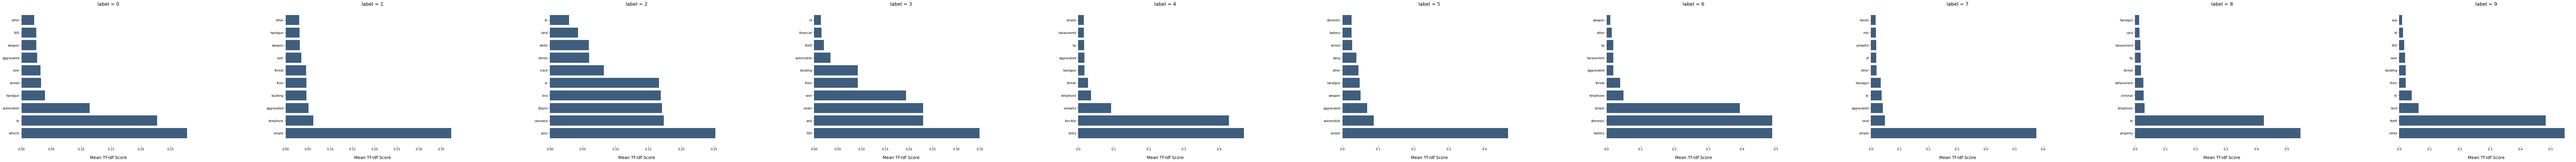

IUCR     Primary Type                   Description Location Description  \
0  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
1   460          BATTERY                        SIMPLE            RESIDENCE   
2  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
3   820            THEFT                $500 AND UNDER               STREET   
4   610         BURGLARY                FORCIBLE ENTRY            APARTMENT   
5   460          BATTERY                        SIMPLE               STREET   
6   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
7   560          ASSAULT                        SIMPLE            RESIDENCE   
8  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
9   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       5.0  2009.0      2   25     8  
1  False    False       3.0  2009.0      5   22    13  
2   True    False      11.0  2009.0      6   17    19  
3  False    False      19.0  2009.0      9   13     0  
4  False    False      15.0  2009.0      6    3    15  
5  False    False      11.0  2009.0     10    9    16  
6  False     True       7.0  2009.0      1   23    20  
7   True    False       4.0  2009.0      5   24    10  
8  False    False       8.0  2009.0      7    5     0  
9   True    False       1.0  2009.0      9   26    16

Location Description
The test has an accuracy of: 
0.342708608763


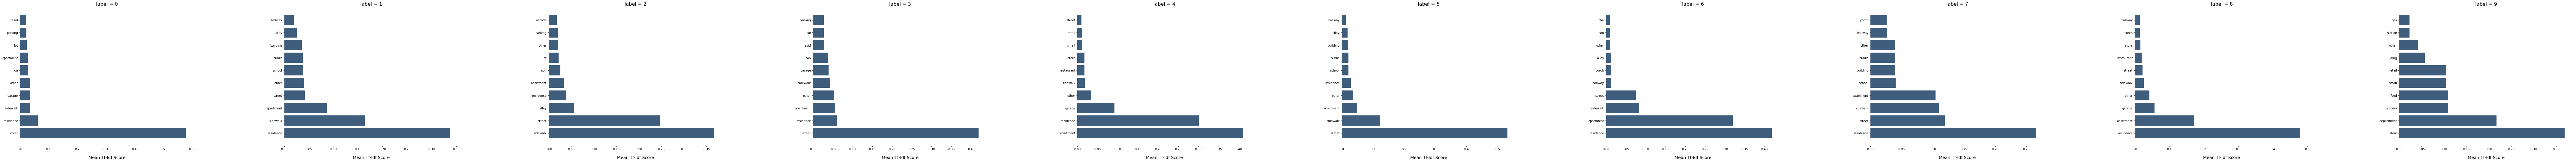

IUCR     Primary Type                   Description Location Description  \
0  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
1   460          BATTERY                        SIMPLE            RESIDENCE   
2  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
3   820            THEFT                $500 AND UNDER               STREET   
4   610         BURGLARY                FORCIBLE ENTRY            APARTMENT   
5   460          BATTERY                        SIMPLE               STREET   
6   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
7   560          ASSAULT                        SIMPLE            RESIDENCE   
8  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
9   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       5.0  2009.0      2   25     8  
1  False    False       3.0  2009.0      5   22    13  
2   True    False      11.0  2009.0      6   17    19  
3  False    False      19.0  2009.0      9   13     0  
4  False    False      15.0  2009.0      6    3    15  
5  False    False      11.0  2009.0     10    9    16  
6  False     True       7.0  2009.0      1   23    20  
7   True    False       4.0  2009.0      5   24    10  
8  False    False       8.0  2009.0      7    5     0  
9   True    False       1.0  2009.0      9   26    16

Primary Type
The test has an accuracy of: 
0.553590467499


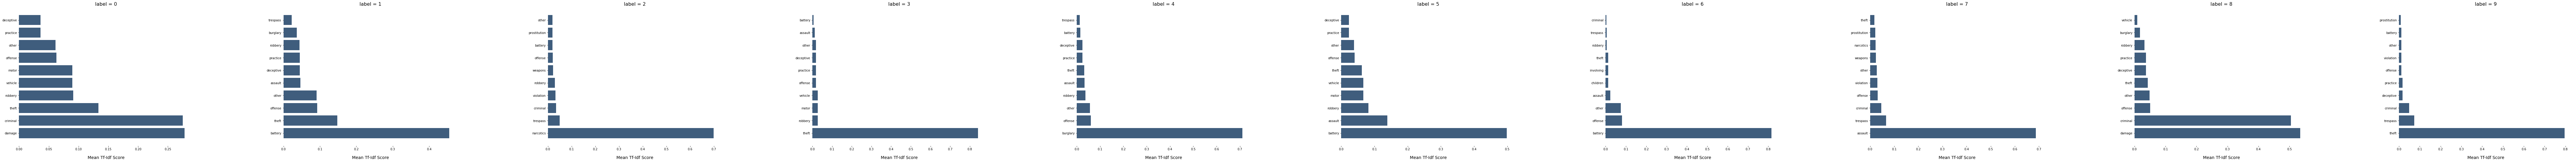

IUCR     Primary Type                   Description Location Description  \
0  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
1   460          BATTERY                        SIMPLE            RESIDENCE   
2  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
3   820            THEFT                $500 AND UNDER               STREET   
4   610         BURGLARY                FORCIBLE ENTRY            APARTMENT   
5   460          BATTERY                        SIMPLE               STREET   
6   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
7   560          ASSAULT                        SIMPLE            RESIDENCE   
8  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
9   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       5.0  2009.0      2   25     8  
1  False    False       3.0  2009.0      5   22    13  
2   True    False      11.0  2009.0      6   17    19  
3  False    False      19.0  2009.0      9   13     0  
4  False    False      15.0  2009.0      6    3    15  
5  False    False      11.0  2009.0     10    9    16  
6  False     True       7.0  2009.0      1   23    20  
7   True    False       4.0  2009.0      5   24    10  
8  False    False       8.0  2009.0      7    5     0  
9   True    False       1.0  2009.0      9   26    16

District
The test has an accuracy of: 
0.214174222328


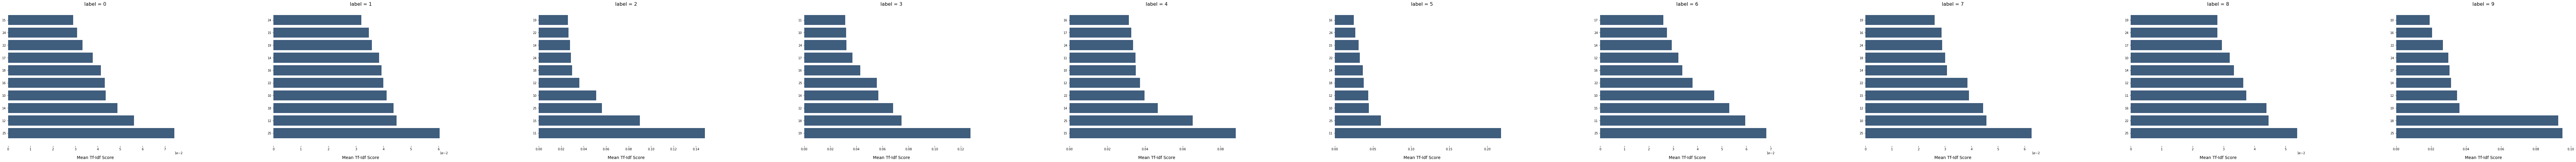

IUCR     Primary Type                   Description Location Description  \
0  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
1   460          BATTERY                        SIMPLE            RESIDENCE   
2  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
3   820            THEFT                $500 AND UNDER               STREET   
4   610         BURGLARY                FORCIBLE ENTRY            APARTMENT   
5   460          BATTERY                        SIMPLE               STREET   
6   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
7   560          ASSAULT                        SIMPLE            RESIDENCE   
8  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
9   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       5.0  2009.0      2   25     8  
1  False    False       3.0  2009.0      5   22    13  
2   True    False      11.0  2009.0      6   17    19  
3  False    False      19.0  2009.0      9   13     0  
4  False    False      15.0  2009.0      6    3    15  
5  False    False      11.0  2009.0     10    9    16  
6  False     True       7.0  2009.0      1   23    20  
7   True    False       4.0  2009.0      5   24    10  
8  False    False       8.0  2009.0      7    5     0  
9   True    False       1.0  2009.0      9   26    16

Day
The test has an accuracy of: 
0.18363029998


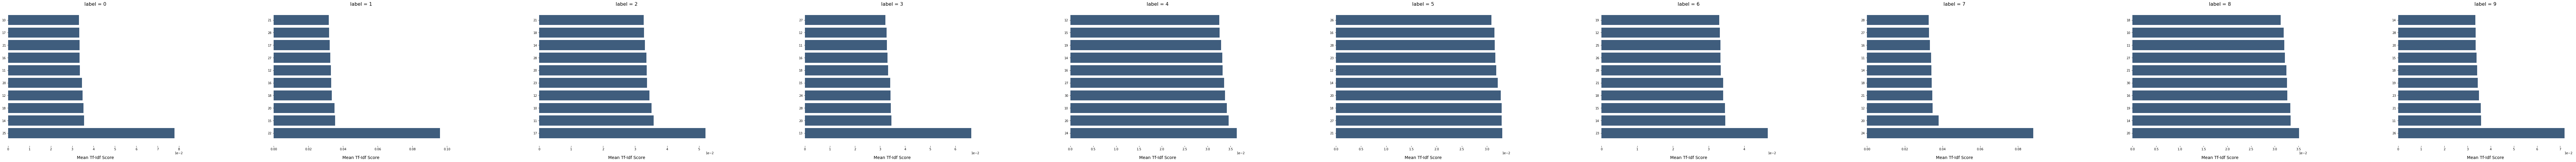

IUCR     Primary Type                   Description Location Description  \
0  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
1   460          BATTERY                        SIMPLE            RESIDENCE   
2  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
3   820            THEFT                $500 AND UNDER               STREET   
4   610         BURGLARY                FORCIBLE ENTRY            APARTMENT   
5   460          BATTERY                        SIMPLE               STREET   
6   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
7   560          ASSAULT                        SIMPLE            RESIDENCE   
8  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
9   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       5.0  2009.0      2   25     8  
1  False    False       3.0  2009.0      5   22    13  
2   True    False      11.0  2009.0      6   17    19  
3  False    False      19.0  2009.0      9   13     0  
4  False    False      15.0  2009.0      6    3    15  
5  False    False      11.0  2009.0     10    9    16  
6  False     True       7.0  2009.0      1   23    20  
7   True    False       4.0  2009.0      5   24    10  
8  False    False       8.0  2009.0      7    5     0  
9   True    False       1.0  2009.0      9   26    16

Hour
The test has an accuracy of: 
0.207209935091


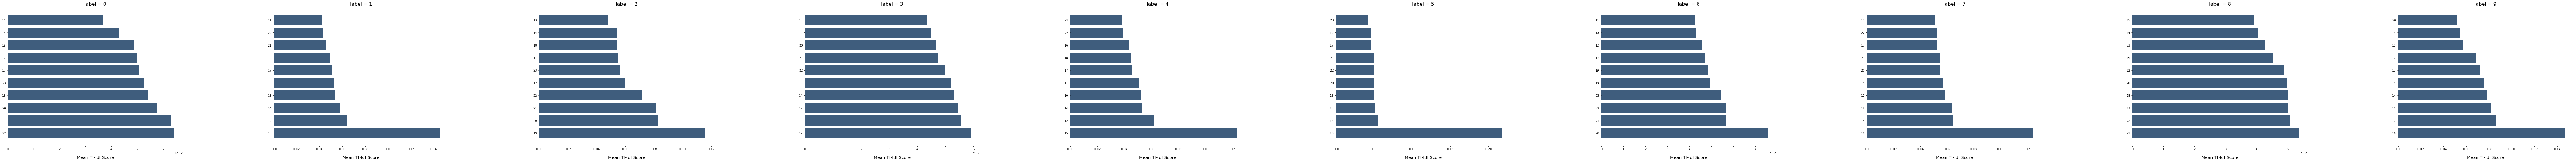

IUCR     Primary Type                   Description Location Description  \
0  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
1   460          BATTERY                        SIMPLE            RESIDENCE   
2  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
3   820            THEFT                $500 AND UNDER               STREET   
4   610         BURGLARY                FORCIBLE ENTRY            APARTMENT   
5   460          BATTERY                        SIMPLE               STREET   
6   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
7   560          ASSAULT                        SIMPLE            RESIDENCE   
8  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
9   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False       5.0  2009.0      2   25     8  
1  False    False       3.0  2009.0      5   22    13  
2   True    False      11.0  2009.0      6   17    19  
3  False    False      19.0  2009.0      9   13     0  
4  False    False      15.0  2009.0      6    3    15  
5  False    False      11.0  2009.0     10    9    16  
6  False     True       7.0  2009.0      1   23    20  
7   True    False       4.0  2009.0      5   24    10  
8  False    False       8.0  2009.0      7    5     0  
9   True    False       1.0  2009.0      9   26    16

In [80]:
getTfidf(2009)

   IUCR        Primary Type                                     Description  \
0  1153  DECEPTIVE PRACTICE             FINANCIAL IDENTITY THEFT OVER $ 300   
1  1153  DECEPTIVE PRACTICE             FINANCIAL IDENTITY THEFT OVER $ 300   
2  0497             BATTERY  AGGRAVATED DOMESTIC BATTERY: OTHER DANG WEAPON   
3  0486             BATTERY                         DOMESTIC BATTERY SIMPLE   
4  2820       OTHER OFFENSE                                TELEPHONE THREAT   

              Location Description Arrest Domestic  District    Year  Month  \
0                        RESIDENCE  False    False      10.0  2010.0      2   
1                        APARTMENT  False    False      24.0  2010.0      9   
2                        RESIDENCE  False     True      16.0  2010.0      1   
3                        RESIDENCE  False    False      16.0  2010.0      2   
4  POLICE FACILITY/VEH PARKING LOT  False     True       2.0  2010.0      3   

   Day  Hour  clusters_10  
0    1     0          

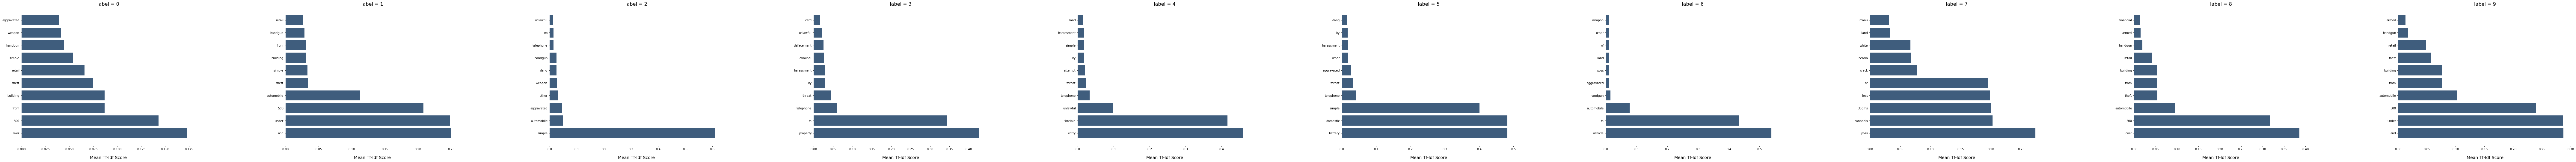

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500             SIDEWALK   
1   820            THEFT                $500 AND UNDER               STREET   
2   460          BATTERY                        SIMPLE               STREET   
3  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
4   610         BURGLARY                FORCIBLE ENTRY            RESIDENCE   
5   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
6  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
7  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
8   810            THEFT                     OVER $500               STREET   
9   820            THEFT                $500 AND UNDER               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2010.0      9   24    18  
1  False    False       5.0  2010.0     11    2    16  
2  False    False      14.0  2010.0      6    1    17  
3  False    False       9.0  2010.0      4    8    11  
4  False    False      22.0  2010.0      8   16     9  
5  False     True       8.0  2010.0     10   18    22  
6  False    False       9.0  2010.0      5   16    10  
7   True    False      11.0  2010.0      4    7    19  
8  False    False       8.0  2010.0      7   12     9  
9  False    False      12.0  2010.0      6    7    22

Location Description
The test has an accuracy of: 
0.293991477408


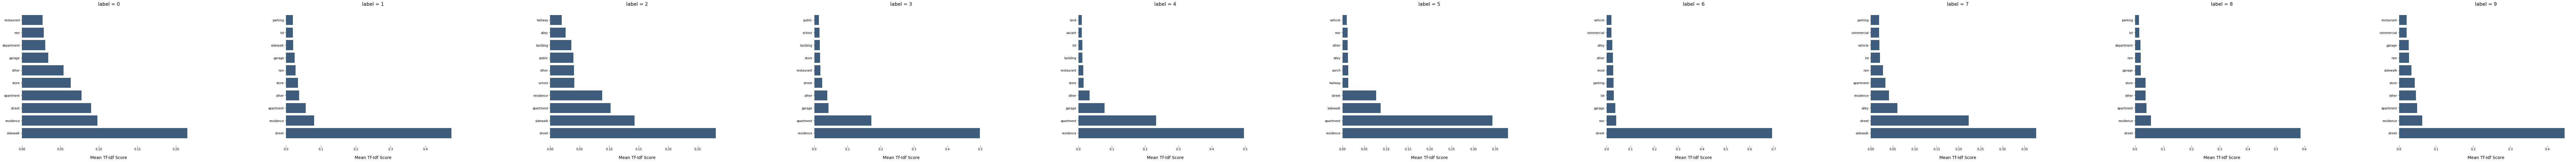

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500             SIDEWALK   
1   820            THEFT                $500 AND UNDER               STREET   
2   460          BATTERY                        SIMPLE               STREET   
3  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
4   610         BURGLARY                FORCIBLE ENTRY            RESIDENCE   
5   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
6  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
7  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
8   810            THEFT                     OVER $500               STREET   
9   820            THEFT                $500 AND UNDER               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2010.0      9   24    18  
1  False    False       5.0  2010.0     11    2    16  
2  False    False      14.0  2010.0      6    1    17  
3  False    False       9.0  2010.0      4    8    11  
4  False    False      22.0  2010.0      8   16     9  
5  False     True       8.0  2010.0     10   18    22  
6  False    False       9.0  2010.0      5   16    10  
7   True    False      11.0  2010.0      4    7    19  
8  False    False       8.0  2010.0      7   12     9  
9  False    False      12.0  2010.0      6    7    22

Primary Type
The test has an accuracy of: 
0.478043410176


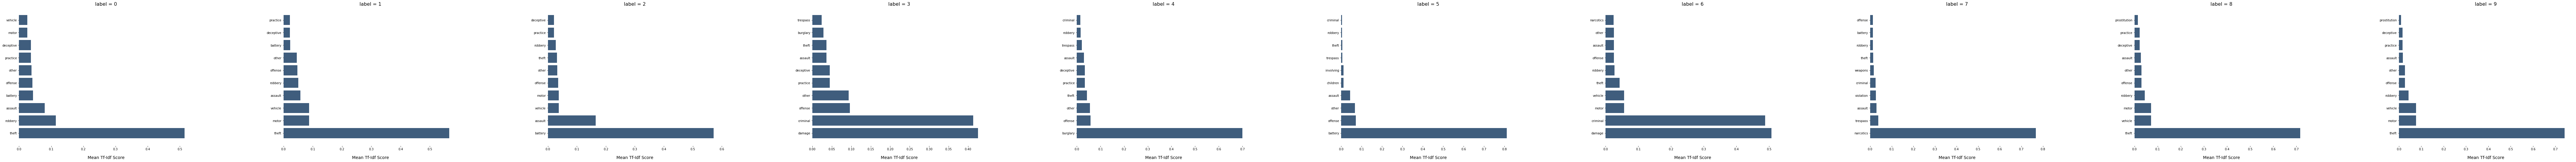

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500             SIDEWALK   
1   820            THEFT                $500 AND UNDER               STREET   
2   460          BATTERY                        SIMPLE               STREET   
3  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
4   610         BURGLARY                FORCIBLE ENTRY            RESIDENCE   
5   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
6  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
7  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
8   810            THEFT                     OVER $500               STREET   
9   820            THEFT                $500 AND UNDER               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2010.0      9   24    18  
1  False    False       5.0  2010.0     11    2    16  
2  False    False      14.0  2010.0      6    1    17  
3  False    False       9.0  2010.0      4    8    11  
4  False    False      22.0  2010.0      8   16     9  
5  False     True       8.0  2010.0     10   18    22  
6  False    False       9.0  2010.0      5   16    10  
7   True    False      11.0  2010.0      4    7    19  
8  False    False       8.0  2010.0      7   12     9  
9  False    False      12.0  2010.0      6    7    22

District
The test has an accuracy of: 
0.194937693965


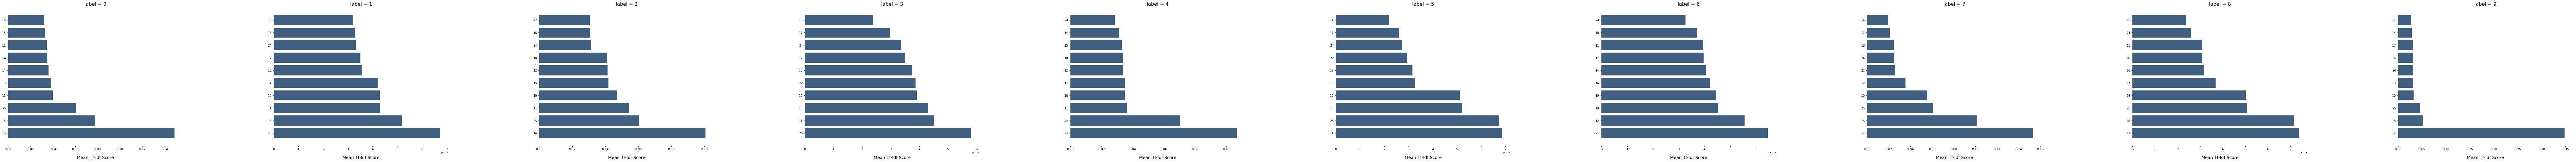

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500             SIDEWALK   
1   820            THEFT                $500 AND UNDER               STREET   
2   460          BATTERY                        SIMPLE               STREET   
3  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
4   610         BURGLARY                FORCIBLE ENTRY            RESIDENCE   
5   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
6  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
7  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
8   810            THEFT                     OVER $500               STREET   
9   820            THEFT                $500 AND UNDER               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2010.0      9   24    18  
1  False    False       5.0  2010.0     11    2    16  
2  False    False      14.0  2010.0      6    1    17  
3  False    False       9.0  2010.0      4    8    11  
4  False    False      22.0  2010.0      8   16     9  
5  False     True       8.0  2010.0     10   18    22  
6  False    False       9.0  2010.0      5   16    10  
7   True    False      11.0  2010.0      4    7    19  
8  False    False       8.0  2010.0      7   12     9  
9  False    False      12.0  2010.0      6    7    22

Day
The test has an accuracy of: 
0.155342754373


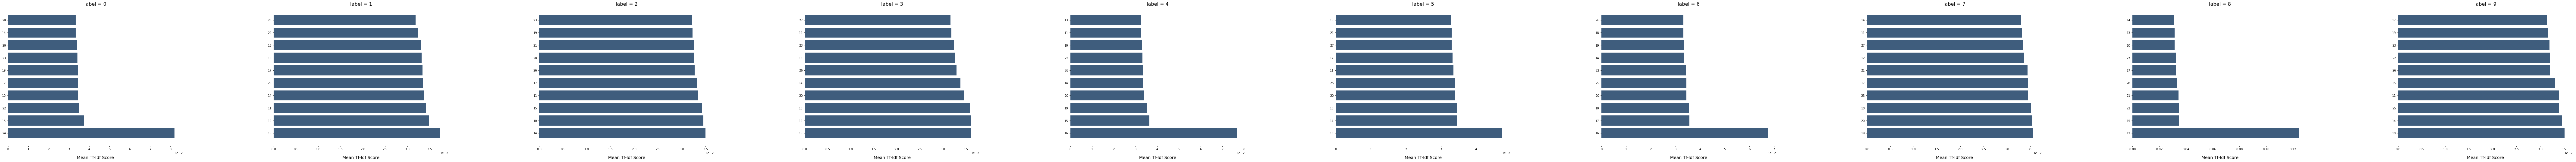

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500             SIDEWALK   
1   820            THEFT                $500 AND UNDER               STREET   
2   460          BATTERY                        SIMPLE               STREET   
3  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
4   610         BURGLARY                FORCIBLE ENTRY            RESIDENCE   
5   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
6  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
7  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
8   810            THEFT                     OVER $500               STREET   
9   820            THEFT                $500 AND UNDER               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2010.0      9   24    18  
1  False    False       5.0  2010.0     11    2    16  
2  False    False      14.0  2010.0      6    1    17  
3  False    False       9.0  2010.0      4    8    11  
4  False    False      22.0  2010.0      8   16     9  
5  False     True       8.0  2010.0     10   18    22  
6  False    False       9.0  2010.0      5   16    10  
7   True    False      11.0  2010.0      4    7    19  
8  False    False       8.0  2010.0      7   12     9  
9  False    False      12.0  2010.0      6    7    22

Hour
The test has an accuracy of: 
0.2093017738


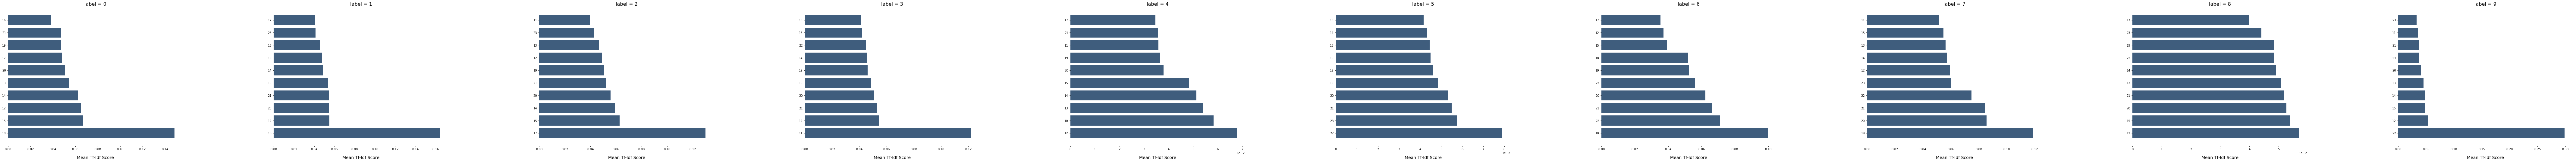

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500             SIDEWALK   
1   820            THEFT                $500 AND UNDER               STREET   
2   460          BATTERY                        SIMPLE               STREET   
3  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
4   610         BURGLARY                FORCIBLE ENTRY            RESIDENCE   
5   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
6  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
7  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
8   810            THEFT                     OVER $500               STREET   
9   820            THEFT                $500 AND UNDER               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2010.0      9   24    18  
1  False    False       5.0  2010.0     11    2    16  
2  False    False      14.0  2010.0      6    1    17  
3  False    False       9.0  2010.0      4    8    11  
4  False    False      22.0  2010.0      8   16     9  
5  False     True       8.0  2010.0     10   18    22  
6  False    False       9.0  2010.0      5   16    10  
7   True    False      11.0  2010.0      4    7    19  
8  False    False       8.0  2010.0      7   12     9  
9  False    False      12.0  2010.0      6    7    22

In [81]:
getTfidf(2010)

   IUCR         Primary Type                         Description  \
0  1156   DECEPTIVE PRACTICE  ATTEMPT - FINANCIAL IDENTITY THEFT   
1  0265  CRIM SEXUAL ASSAULT                   AGGRAVATED: OTHER   
2  0454              BATTERY          AGG PO HANDS NO/MIN INJURY   
3  0486              BATTERY             DOMESTIC BATTERY SIMPLE   
4  0917  MOTOR VEHICLE THEFT          CYCLE, SCOOTER, BIKE W-VIN   

             Location Description Arrest Domestic  District    Year  Month  \
0                       APARTMENT  False    False      22.0  2011.0      7   
1                       APARTMENT  False    False      25.0  2011.0      3   
2  LAKEFRONT/WATERFRONT/RIVERBANK  False    False      14.0  2011.0     11   
3                       RESIDENCE  False     True      16.0  2011.0     11   
4                          STREET  False    False      15.0  2011.0     12   

   Day  Hour  clusters_10  
0    1     1            9  
1   11    19            0  
2    1     1            0  
3   18    

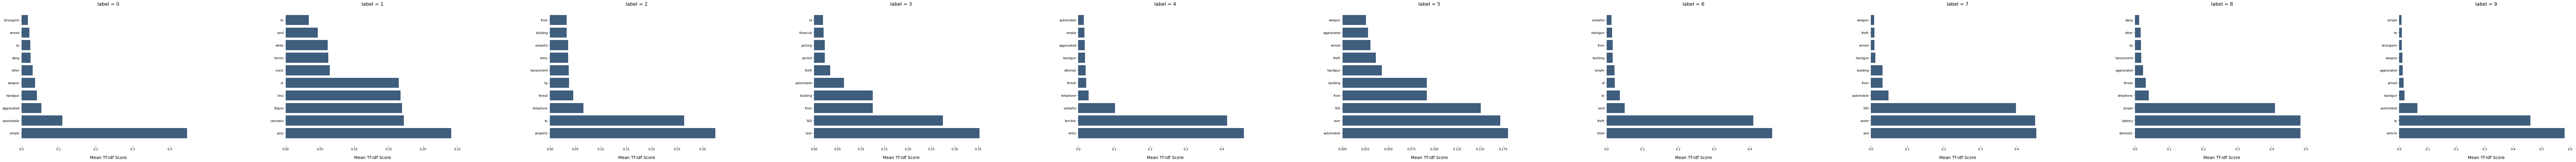

IUCR     Primary Type                   Description Location Description  \
0   460          BATTERY                        SIMPLE               STREET   
1  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
2  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
3   810            THEFT                     OVER $500               STREET   
4   610         BURGLARY                FORCIBLE ENTRY            APARTMENT   
5   810            THEFT                     OVER $500               STREET   
6   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   
7   820            THEFT                $500 AND UNDER               STREET   
8   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
9  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2011.0      3    2    22  
1   True    False      11.0  2011.0     11    4    20  
2  False    False       8.0  2011.0      5   29    14  
3  False    False       1.0  2011.0      1    4    13  
4  False    False       7.0  2011.0     10   23     9  
5  False    False       1.0  2011.0      5   19    23  
6   True    False       9.0  2011.0      9   29    16  
7  False    False       8.0  2011.0      8   17    11  
8  False     True       4.0  2011.0     12    6    21  
9  False    False      22.0  2011.0      4   15    19

Location Description
The test has an accuracy of: 
0.338057216378


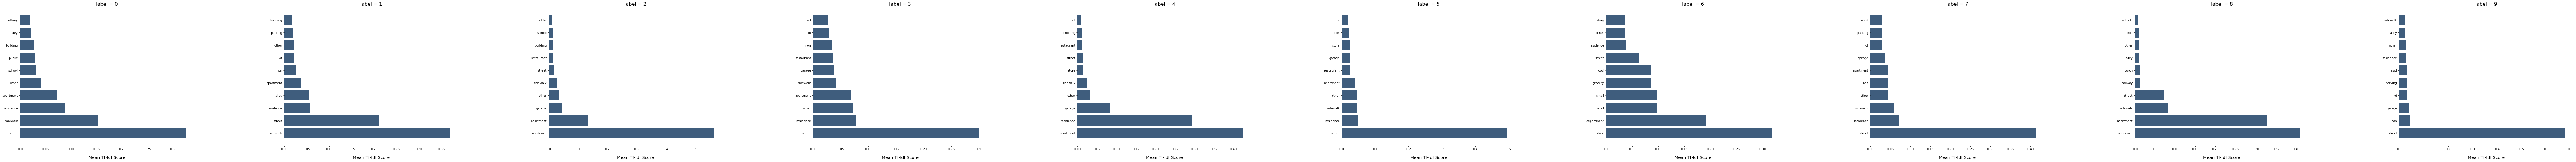

IUCR     Primary Type                   Description Location Description  \
0   460          BATTERY                        SIMPLE               STREET   
1  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
2  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
3   810            THEFT                     OVER $500               STREET   
4   610         BURGLARY                FORCIBLE ENTRY            APARTMENT   
5   810            THEFT                     OVER $500               STREET   
6   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   
7   820            THEFT                $500 AND UNDER               STREET   
8   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
9  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2011.0      3    2    22  
1   True    False      11.0  2011.0     11    4    20  
2  False    False       8.0  2011.0      5   29    14  
3  False    False       1.0  2011.0      1    4    13  
4  False    False       7.0  2011.0     10   23     9  
5  False    False       1.0  2011.0      5   19    23  
6   True    False       9.0  2011.0      9   29    16  
7  False    False       8.0  2011.0      8   17    11  
8  False     True       4.0  2011.0     12    6    21  
9  False    False      22.0  2011.0      4   15    19

Primary Type
The test has an accuracy of: 
0.524294255657


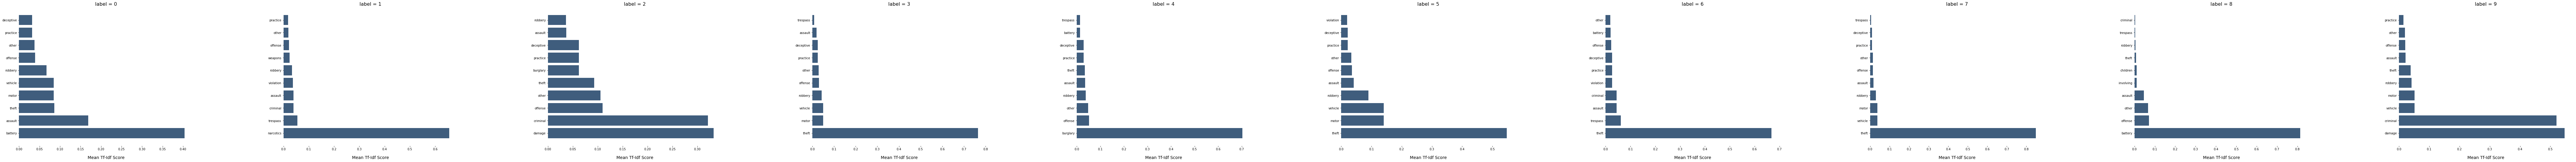

IUCR     Primary Type                   Description Location Description  \
0   460          BATTERY                        SIMPLE               STREET   
1  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
2  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
3   810            THEFT                     OVER $500               STREET   
4   610         BURGLARY                FORCIBLE ENTRY            APARTMENT   
5   810            THEFT                     OVER $500               STREET   
6   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   
7   820            THEFT                $500 AND UNDER               STREET   
8   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
9  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2011.0      3    2    22  
1   True    False      11.0  2011.0     11    4    20  
2  False    False       8.0  2011.0      5   29    14  
3  False    False       1.0  2011.0      1    4    13  
4  False    False       7.0  2011.0     10   23     9  
5  False    False       1.0  2011.0      5   19    23  
6   True    False       9.0  2011.0      9   29    16  
7  False    False       8.0  2011.0      8   17    11  
8  False     True       4.0  2011.0     12    6    21  
9  False    False      22.0  2011.0      4   15    19

District
The test has an accuracy of: 
0.215318247181


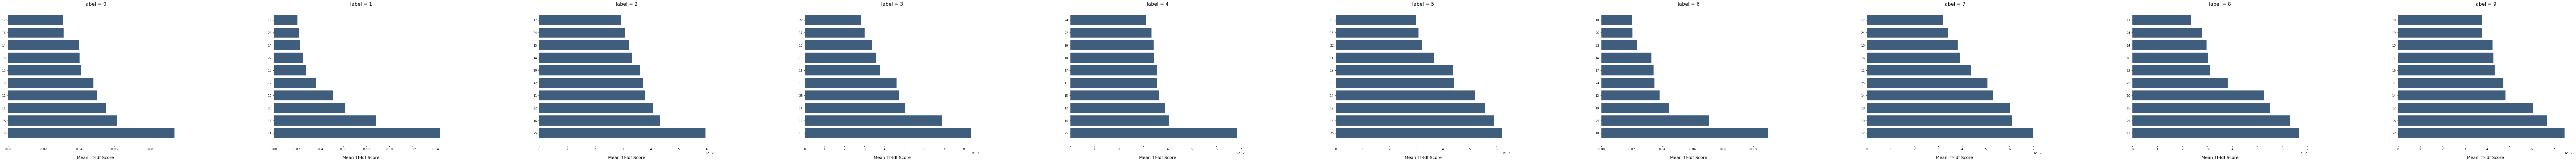

IUCR     Primary Type                   Description Location Description  \
0   460          BATTERY                        SIMPLE               STREET   
1  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
2  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
3   810            THEFT                     OVER $500               STREET   
4   610         BURGLARY                FORCIBLE ENTRY            APARTMENT   
5   810            THEFT                     OVER $500               STREET   
6   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   
7   820            THEFT                $500 AND UNDER               STREET   
8   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
9  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2011.0      3    2    22  
1   True    False      11.0  2011.0     11    4    20  
2  False    False       8.0  2011.0      5   29    14  
3  False    False       1.0  2011.0      1    4    13  
4  False    False       7.0  2011.0     10   23     9  
5  False    False       1.0  2011.0      5   19    23  
6   True    False       9.0  2011.0      9   29    16  
7  False    False       8.0  2011.0      8   17    11  
8  False     True       4.0  2011.0     12    6    21  
9  False    False      22.0  2011.0      4   15    19

Day
The test has an accuracy of: 
0.205961931431


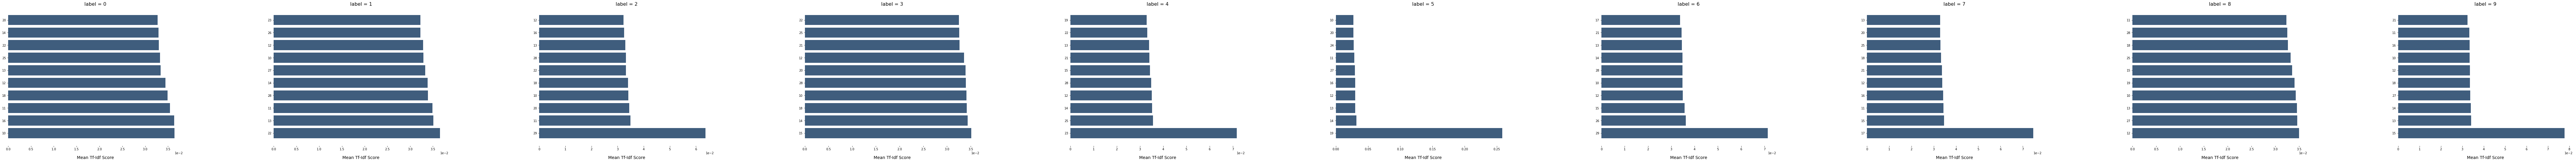

IUCR     Primary Type                   Description Location Description  \
0   460          BATTERY                        SIMPLE               STREET   
1  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
2  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
3   810            THEFT                     OVER $500               STREET   
4   610         BURGLARY                FORCIBLE ENTRY            APARTMENT   
5   810            THEFT                     OVER $500               STREET   
6   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   
7   820            THEFT                $500 AND UNDER               STREET   
8   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
9  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2011.0      3    2    22  
1   True    False      11.0  2011.0     11    4    20  
2  False    False       8.0  2011.0      5   29    14  
3  False    False       1.0  2011.0      1    4    13  
4  False    False       7.0  2011.0     10   23     9  
5  False    False       1.0  2011.0      5   19    23  
6   True    False       9.0  2011.0      9   29    16  
7  False    False       8.0  2011.0      8   17    11  
8  False     True       4.0  2011.0     12    6    21  
9  False    False      22.0  2011.0      4   15    19

Hour
The test has an accuracy of: 
0.231552259139


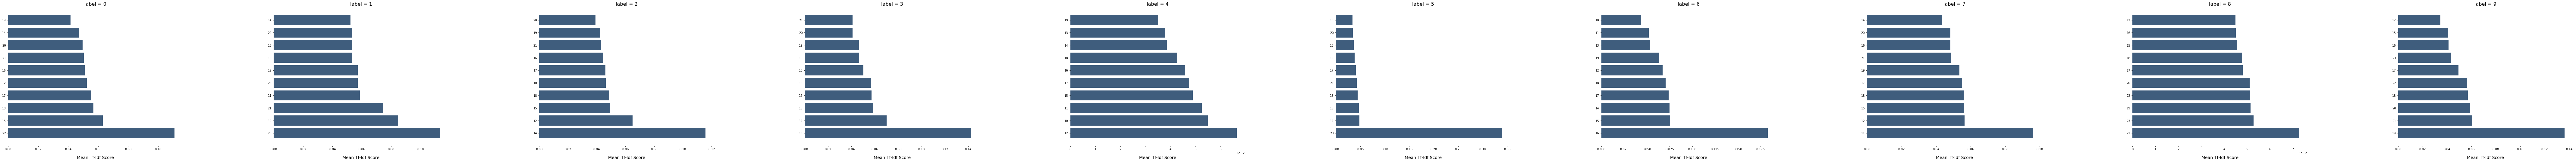

IUCR     Primary Type                   Description Location Description  \
0   460          BATTERY                        SIMPLE               STREET   
1  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS             SIDEWALK   
2  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
3   810            THEFT                     OVER $500               STREET   
4   610         BURGLARY                FORCIBLE ENTRY            APARTMENT   
5   810            THEFT                     OVER $500               STREET   
6   860            THEFT                  RETAIL THEFT     DEPARTMENT STORE   
7   820            THEFT                $500 AND UNDER               STREET   
8   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
9  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2011.0      3    2    22  
1   True    False      11.0  2011.0     11    4    20  
2  False    False       8.0  2011.0      5   29    14  
3  False    False       1.0  2011.0      1    4    13  
4  False    False       7.0  2011.0     10   23     9  
5  False    False       1.0  2011.0      5   19    23  
6   True    False       9.0  2011.0      9   29    16  
7  False    False       8.0  2011.0      8   17    11  
8  False     True       4.0  2011.0     12    6    21  
9  False    False      22.0  2011.0      4   15    19

In [82]:
getTfidf(2011)

   IUCR        Primary Type                              Description  \
0  1562         SEX OFFENSE                AGG CRIMINAL SEXUAL ABUSE   
1  1544         SEX OFFENSE           SEXUAL EXPLOITATION OF A CHILD   
2  1154  DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT $300 AND UNDER   
3  1563         SEX OFFENSE                    CRIMINAL SEXUAL ABUSE   
4  1130  DECEPTIVE PRACTICE                 FRAUD OR CONFIDENCE GAME   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  \
0            RESIDENCE   True    False      25.0  2012.0      1    1     0   
1            RESIDENCE   True    False      25.0  2012.0      1    1     0   
2            APARTMENT  False    False       3.0  2012.0      4   13     0   
3            RESIDENCE  False     True      10.0  2012.0      8   12    12   
4                OTHER  False    False       8.0  2012.0      2   13    19   

   clusters_10  
0            0  
1            0  
2            9  
3            1  
4            

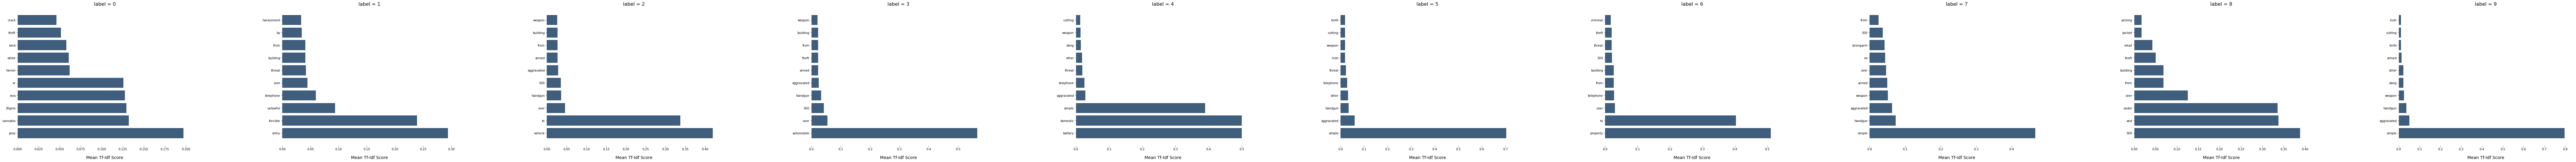

IUCR         Primary Type                   Description  \
0  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
1   610             BURGLARY                FORCIBLE ENTRY   
2  1320      CRIMINAL DAMAGE                    TO VEHICLE   
3   910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
4   486              BATTERY       DOMESTIC BATTERY SIMPLE   
5   560              ASSAULT                        SIMPLE   
6  1310      CRIMINAL DAMAGE                   TO PROPERTY   
7   560              ASSAULT                        SIMPLE   
8   820                THEFT                $500 AND UNDER   
9   460              BATTERY                        SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0             SIDEWALK   True    False      11.0  2012.0      3    7    19  
1            RESIDENCE  False    False       4.0  2012.0      2    3     9  
2               STREET  False    False      16.0  2012.0      5   14    14  
3               STREET  False    False      10.0  2012.0     10   13    22  
4            APARTMENT  False     True       7.0  2012.0      6   24     0  
5               STREET  False     True      11.0  2012.0     11    4    19  
6            RESIDENCE  False    False       8.0  2012.0      5    6    11  
7             SIDEWALK  False    False       6.0  2012.0      6   24    18  
8               STREET  False    False      18.0  2012.0     11    1    12  
9             SIDEWALK  False    False      11.0  2012.0      6    5     0

Location Description
The test has an accuracy of: 
0.343612685158


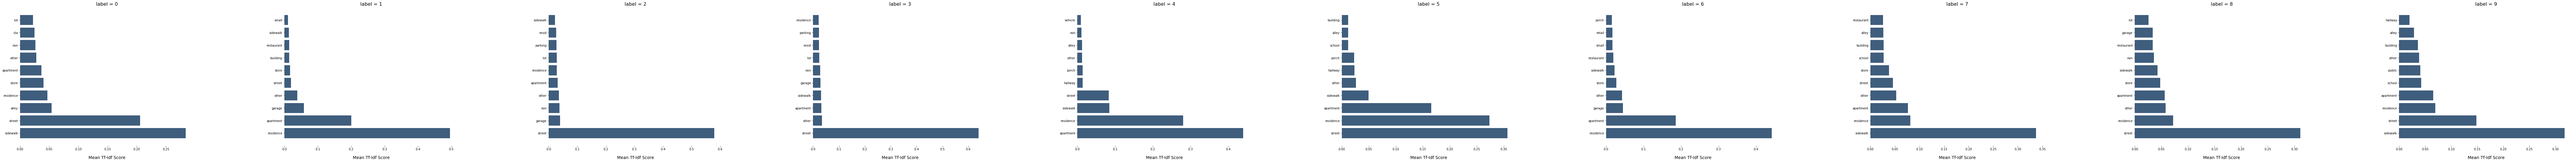

IUCR         Primary Type                   Description  \
0  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
1   610             BURGLARY                FORCIBLE ENTRY   
2  1320      CRIMINAL DAMAGE                    TO VEHICLE   
3   910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
4   486              BATTERY       DOMESTIC BATTERY SIMPLE   
5   560              ASSAULT                        SIMPLE   
6  1310      CRIMINAL DAMAGE                   TO PROPERTY   
7   560              ASSAULT                        SIMPLE   
8   820                THEFT                $500 AND UNDER   
9   460              BATTERY                        SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0             SIDEWALK   True    False      11.0  2012.0      3    7    19  
1            RESIDENCE  False    False       4.0  2012.0      2    3     9  
2               STREET  False    False      16.0  2012.0      5   14    14  
3               STREET  False    False      10.0  2012.0     10   13    22  
4            APARTMENT  False     True       7.0  2012.0      6   24     0  
5               STREET  False     True      11.0  2012.0     11    4    19  
6            RESIDENCE  False    False       8.0  2012.0      5    6    11  
7             SIDEWALK  False    False       6.0  2012.0      6   24    18  
8               STREET  False    False      18.0  2012.0     11    1    12  
9             SIDEWALK  False    False      11.0  2012.0      6    5     0

Primary Type
The test has an accuracy of: 
0.621393776717


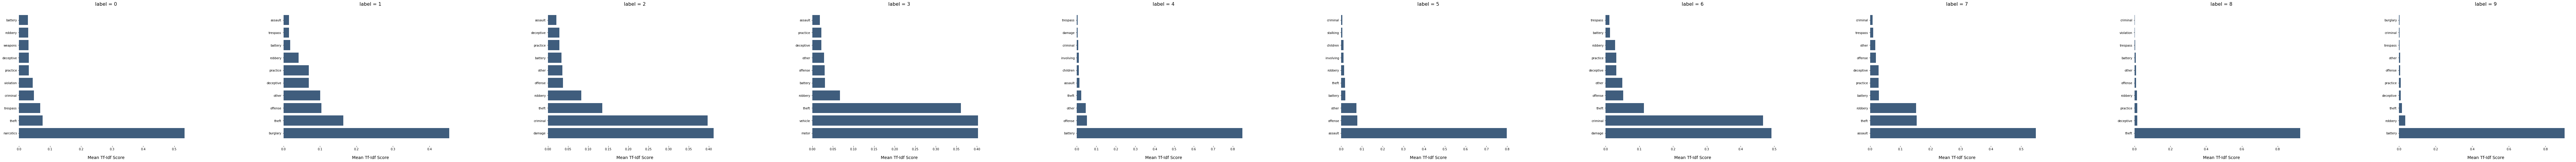

IUCR         Primary Type                   Description  \
0  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
1   610             BURGLARY                FORCIBLE ENTRY   
2  1320      CRIMINAL DAMAGE                    TO VEHICLE   
3   910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
4   486              BATTERY       DOMESTIC BATTERY SIMPLE   
5   560              ASSAULT                        SIMPLE   
6  1310      CRIMINAL DAMAGE                   TO PROPERTY   
7   560              ASSAULT                        SIMPLE   
8   820                THEFT                $500 AND UNDER   
9   460              BATTERY                        SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0             SIDEWALK   True    False      11.0  2012.0      3    7    19  
1            RESIDENCE  False    False       4.0  2012.0      2    3     9  
2               STREET  False    False      16.0  2012.0      5   14    14  
3               STREET  False    False      10.0  2012.0     10   13    22  
4            APARTMENT  False     True       7.0  2012.0      6   24     0  
5               STREET  False     True      11.0  2012.0     11    4    19  
6            RESIDENCE  False    False       8.0  2012.0      5    6    11  
7             SIDEWALK  False    False       6.0  2012.0      6   24    18  
8               STREET  False    False      18.0  2012.0     11    1    12  
9             SIDEWALK  False    False      11.0  2012.0      6    5     0

District
The test has an accuracy of: 
0.230321105478


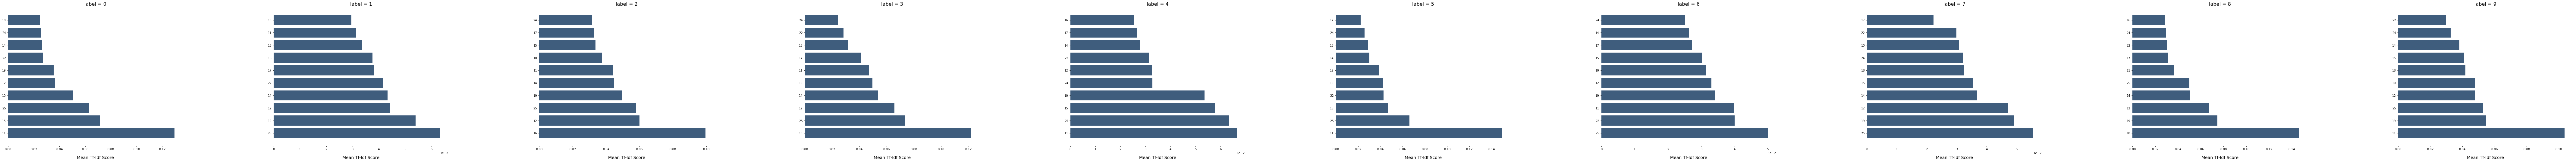

IUCR         Primary Type                   Description  \
0  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
1   610             BURGLARY                FORCIBLE ENTRY   
2  1320      CRIMINAL DAMAGE                    TO VEHICLE   
3   910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
4   486              BATTERY       DOMESTIC BATTERY SIMPLE   
5   560              ASSAULT                        SIMPLE   
6  1310      CRIMINAL DAMAGE                   TO PROPERTY   
7   560              ASSAULT                        SIMPLE   
8   820                THEFT                $500 AND UNDER   
9   460              BATTERY                        SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0             SIDEWALK   True    False      11.0  2012.0      3    7    19  
1            RESIDENCE  False    False       4.0  2012.0      2    3     9  
2               STREET  False    False      16.0  2012.0      5   14    14  
3               STREET  False    False      10.0  2012.0     10   13    22  
4            APARTMENT  False     True       7.0  2012.0      6   24     0  
5               STREET  False     True      11.0  2012.0     11    4    19  
6            RESIDENCE  False    False       8.0  2012.0      5    6    11  
7             SIDEWALK  False    False       6.0  2012.0      6   24    18  
8               STREET  False    False      18.0  2012.0     11    1    12  
9             SIDEWALK  False    False      11.0  2012.0      6    5     0

Day
The test has an accuracy of: 
0.198777214435


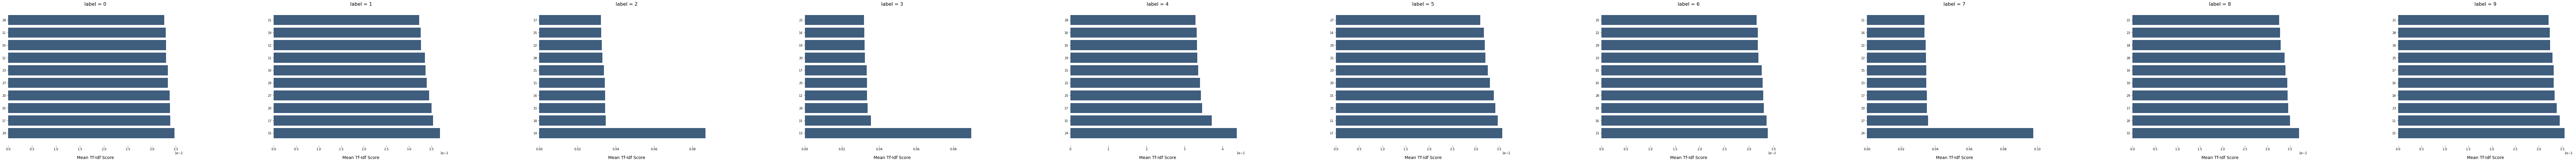

IUCR         Primary Type                   Description  \
0  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
1   610             BURGLARY                FORCIBLE ENTRY   
2  1320      CRIMINAL DAMAGE                    TO VEHICLE   
3   910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
4   486              BATTERY       DOMESTIC BATTERY SIMPLE   
5   560              ASSAULT                        SIMPLE   
6  1310      CRIMINAL DAMAGE                   TO PROPERTY   
7   560              ASSAULT                        SIMPLE   
8   820                THEFT                $500 AND UNDER   
9   460              BATTERY                        SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0             SIDEWALK   True    False      11.0  2012.0      3    7    19  
1            RESIDENCE  False    False       4.0  2012.0      2    3     9  
2               STREET  False    False      16.0  2012.0      5   14    14  
3               STREET  False    False      10.0  2012.0     10   13    22  
4            APARTMENT  False     True       7.0  2012.0      6   24     0  
5               STREET  False     True      11.0  2012.0     11    4    19  
6            RESIDENCE  False    False       8.0  2012.0      5    6    11  
7             SIDEWALK  False    False       6.0  2012.0      6   24    18  
8               STREET  False    False      18.0  2012.0     11    1    12  
9             SIDEWALK  False    False      11.0  2012.0      6    5     0

Hour
The test has an accuracy of: 
0.202385923054


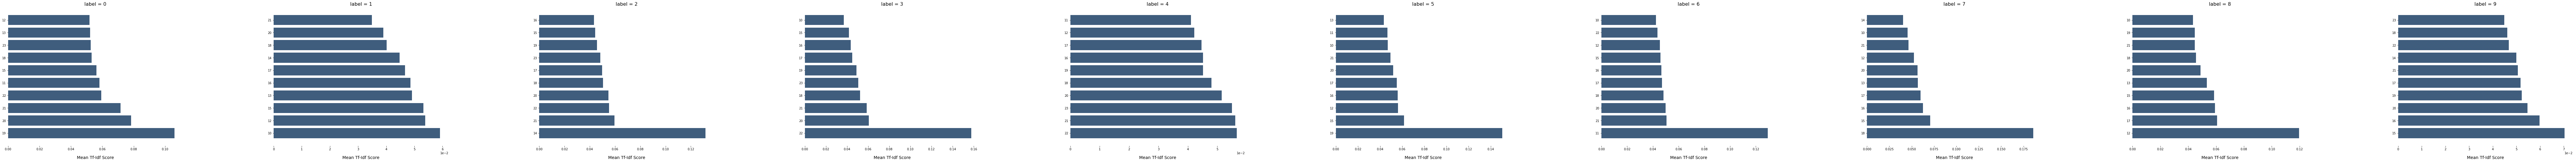

IUCR         Primary Type                   Description  \
0  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
1   610             BURGLARY                FORCIBLE ENTRY   
2  1320      CRIMINAL DAMAGE                    TO VEHICLE   
3   910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
4   486              BATTERY       DOMESTIC BATTERY SIMPLE   
5   560              ASSAULT                        SIMPLE   
6  1310      CRIMINAL DAMAGE                   TO PROPERTY   
7   560              ASSAULT                        SIMPLE   
8   820                THEFT                $500 AND UNDER   
9   460              BATTERY                        SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0             SIDEWALK   True    False      11.0  2012.0      3    7    19  
1            RESIDENCE  False    False       4.0  2012.0      2    3     9  
2               STREET  False    False      16.0  2012.0      5   14    14  
3               STREET  False    False      10.0  2012.0     10   13    22  
4            APARTMENT  False     True       7.0  2012.0      6   24     0  
5               STREET  False     True      11.0  2012.0     11    4    19  
6            RESIDENCE  False    False       8.0  2012.0      5    6    11  
7             SIDEWALK  False    False       6.0  2012.0      6   24    18  
8               STREET  False    False      18.0  2012.0     11    1    12  
9             SIDEWALK  False    False      11.0  2012.0      6    5     0

In [83]:
getTfidf(2012)

   IUCR         Primary Type                          Description  \
0  0110             HOMICIDE                  FIRST DEGREE MURDER   
1  0266  CRIM SEXUAL ASSAULT                            PREDATORY   
2  1153   DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
3  1153   DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
4  0266  CRIM SEXUAL ASSAULT                            PREDATORY   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  \
0                ALLEY   True    False      10.0  2013.0      5    1     1   
1            RESIDENCE  False    False       9.0  2013.0      5   10    11   
2              UNKNOWN  False    False      18.0  2013.0      3   18    10   
3            RESIDENCE  False    False      15.0  2013.0     12    5     1   
4            RESIDENCE   True     True      16.0  2013.0      7   31     0   

   clusters_10  
0            3  
1            8  
2            2  
3            5  
4            1  
(306703, 12)
 

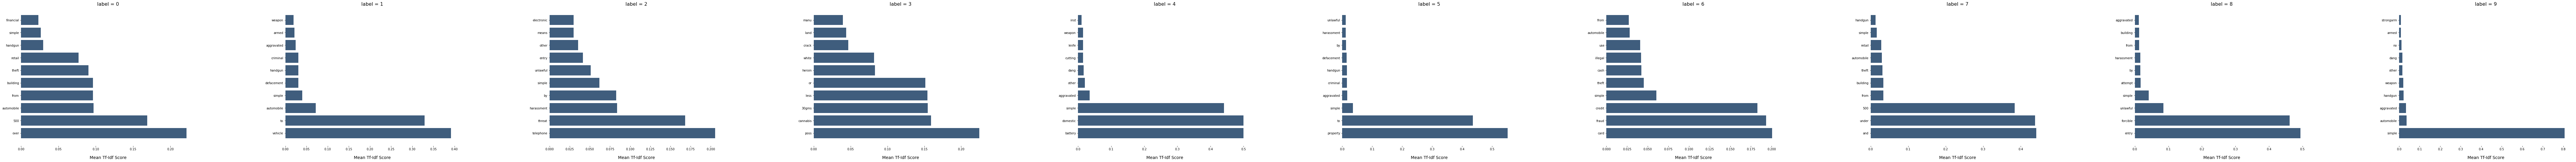

IUCR        Primary Type                   Description  \
0   810               THEFT                     OVER $500   
1  1320     CRIMINAL DAMAGE                    TO VEHICLE   
2  2820       OTHER OFFENSE              TELEPHONE THREAT   
3  1811           NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
4   486             BATTERY       DOMESTIC BATTERY SIMPLE   
5  1310     CRIMINAL DAMAGE                   TO PROPERTY   
6  1150  DECEPTIVE PRACTICE             CREDIT CARD FRAUD   
7   820               THEFT                $500 AND UNDER   
8   610            BURGLARY                FORCIBLE ENTRY   
9   460             BATTERY                        SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0               STREET  False    False       2.0  2013.0      2   15    16  
1               STREET  False    False      12.0  2013.0     11   23    22  
2            APARTMENT  False    False      18.0  2013.0     12   18     9  
3             SIDEWALK   True    False      11.0  2013.0      4   17    19  
4            APARTMENT  False     True       7.0  2013.0     10    6    22  
5            RESIDENCE  False    False      11.0  2013.0      2    2     1  
6                OTHER  False    False      12.0  2013.0      1    9    12  
7               STREET  False    False       5.0  2013.0      8   16    15  
8            RESIDENCE  False    False       4.0  2013.0      4   22    11  
9               STREET  False    False      17.0  2013.0      7   12    15

Location Description
The test has an accuracy of: 
0.312152510594


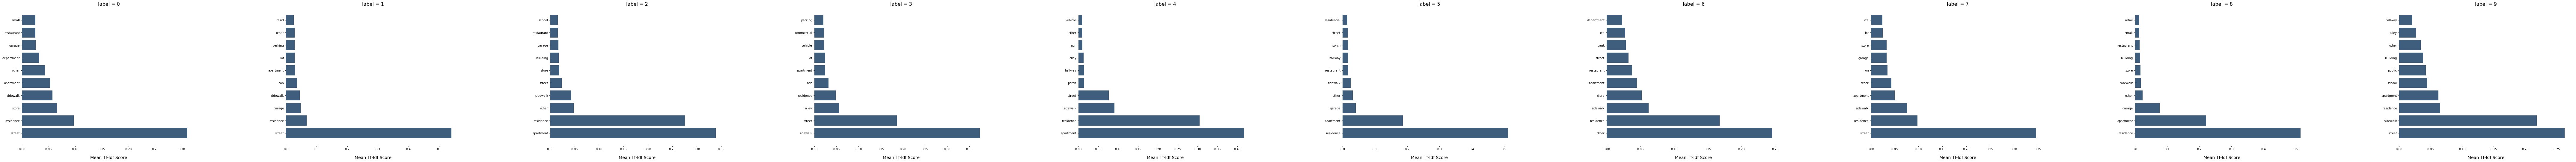

IUCR        Primary Type                   Description  \
0   810               THEFT                     OVER $500   
1  1320     CRIMINAL DAMAGE                    TO VEHICLE   
2  2820       OTHER OFFENSE              TELEPHONE THREAT   
3  1811           NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
4   486             BATTERY       DOMESTIC BATTERY SIMPLE   
5  1310     CRIMINAL DAMAGE                   TO PROPERTY   
6  1150  DECEPTIVE PRACTICE             CREDIT CARD FRAUD   
7   820               THEFT                $500 AND UNDER   
8   610            BURGLARY                FORCIBLE ENTRY   
9   460             BATTERY                        SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0               STREET  False    False       2.0  2013.0      2   15    16  
1               STREET  False    False      12.0  2013.0     11   23    22  
2            APARTMENT  False    False      18.0  2013.0     12   18     9  
3             SIDEWALK   True    False      11.0  2013.0      4   17    19  
4            APARTMENT  False     True       7.0  2013.0     10    6    22  
5            RESIDENCE  False    False      11.0  2013.0      2    2     1  
6                OTHER  False    False      12.0  2013.0      1    9    12  
7               STREET  False    False       5.0  2013.0      8   16    15  
8            RESIDENCE  False    False       4.0  2013.0      4   22    11  
9               STREET  False    False      17.0  2013.0      7   12    15

Primary Type
The test has an accuracy of: 
0.536854198051


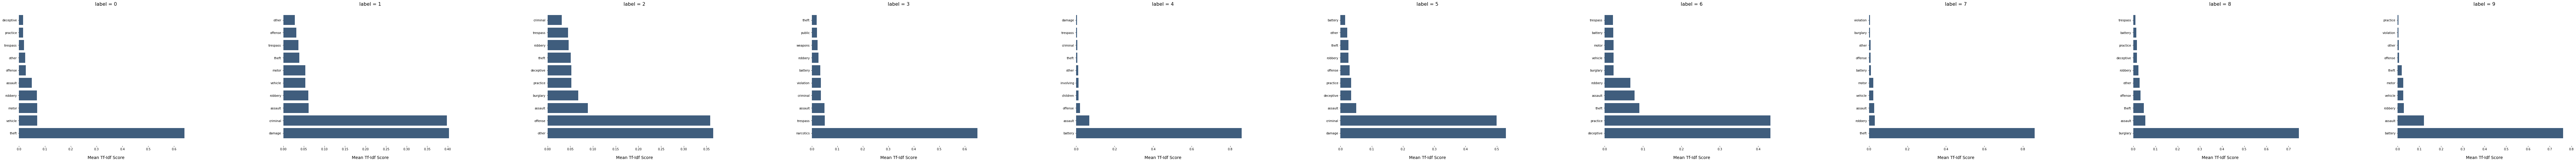

IUCR        Primary Type                   Description  \
0   810               THEFT                     OVER $500   
1  1320     CRIMINAL DAMAGE                    TO VEHICLE   
2  2820       OTHER OFFENSE              TELEPHONE THREAT   
3  1811           NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
4   486             BATTERY       DOMESTIC BATTERY SIMPLE   
5  1310     CRIMINAL DAMAGE                   TO PROPERTY   
6  1150  DECEPTIVE PRACTICE             CREDIT CARD FRAUD   
7   820               THEFT                $500 AND UNDER   
8   610            BURGLARY                FORCIBLE ENTRY   
9   460             BATTERY                        SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0               STREET  False    False       2.0  2013.0      2   15    16  
1               STREET  False    False      12.0  2013.0     11   23    22  
2            APARTMENT  False    False      18.0  2013.0     12   18     9  
3             SIDEWALK   True    False      11.0  2013.0      4   17    19  
4            APARTMENT  False     True       7.0  2013.0     10    6    22  
5            RESIDENCE  False    False      11.0  2013.0      2    2     1  
6                OTHER  False    False      12.0  2013.0      1    9    12  
7               STREET  False    False       5.0  2013.0      8   16    15  
8            RESIDENCE  False    False       4.0  2013.0      4   22    11  
9               STREET  False    False      17.0  2013.0      7   12    15

District
The test has an accuracy of: 
0.232537471957


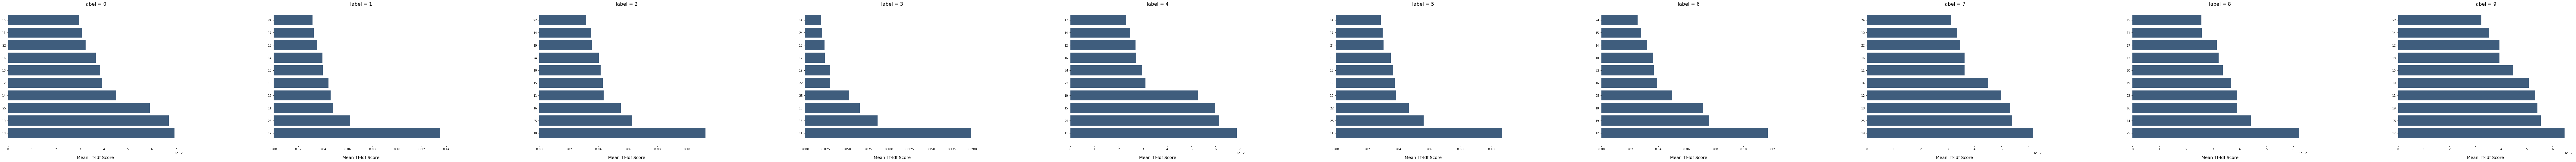

IUCR        Primary Type                   Description  \
0   810               THEFT                     OVER $500   
1  1320     CRIMINAL DAMAGE                    TO VEHICLE   
2  2820       OTHER OFFENSE              TELEPHONE THREAT   
3  1811           NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
4   486             BATTERY       DOMESTIC BATTERY SIMPLE   
5  1310     CRIMINAL DAMAGE                   TO PROPERTY   
6  1150  DECEPTIVE PRACTICE             CREDIT CARD FRAUD   
7   820               THEFT                $500 AND UNDER   
8   610            BURGLARY                FORCIBLE ENTRY   
9   460             BATTERY                        SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0               STREET  False    False       2.0  2013.0      2   15    16  
1               STREET  False    False      12.0  2013.0     11   23    22  
2            APARTMENT  False    False      18.0  2013.0     12   18     9  
3             SIDEWALK   True    False      11.0  2013.0      4   17    19  
4            APARTMENT  False     True       7.0  2013.0     10    6    22  
5            RESIDENCE  False    False      11.0  2013.0      2    2     1  
6                OTHER  False    False      12.0  2013.0      1    9    12  
7               STREET  False    False       5.0  2013.0      8   16    15  
8            RESIDENCE  False    False       4.0  2013.0      4   22    11  
9               STREET  False    False      17.0  2013.0      7   12    15

Day
The test has an accuracy of: 
0.20479250886


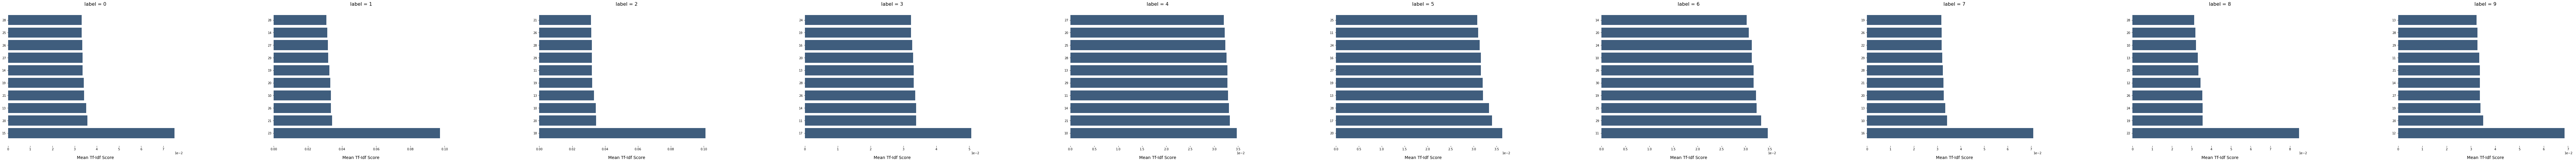

IUCR        Primary Type                   Description  \
0   810               THEFT                     OVER $500   
1  1320     CRIMINAL DAMAGE                    TO VEHICLE   
2  2820       OTHER OFFENSE              TELEPHONE THREAT   
3  1811           NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
4   486             BATTERY       DOMESTIC BATTERY SIMPLE   
5  1310     CRIMINAL DAMAGE                   TO PROPERTY   
6  1150  DECEPTIVE PRACTICE             CREDIT CARD FRAUD   
7   820               THEFT                $500 AND UNDER   
8   610            BURGLARY                FORCIBLE ENTRY   
9   460             BATTERY                        SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0               STREET  False    False       2.0  2013.0      2   15    16  
1               STREET  False    False      12.0  2013.0     11   23    22  
2            APARTMENT  False    False      18.0  2013.0     12   18     9  
3             SIDEWALK   True    False      11.0  2013.0      4   17    19  
4            APARTMENT  False     True       7.0  2013.0     10    6    22  
5            RESIDENCE  False    False      11.0  2013.0      2    2     1  
6                OTHER  False    False      12.0  2013.0      1    9    12  
7               STREET  False    False       5.0  2013.0      8   16    15  
8            RESIDENCE  False    False       4.0  2013.0      4   22    11  
9               STREET  False    False      17.0  2013.0      7   12    15

Hour
The test has an accuracy of: 
0.228895945551


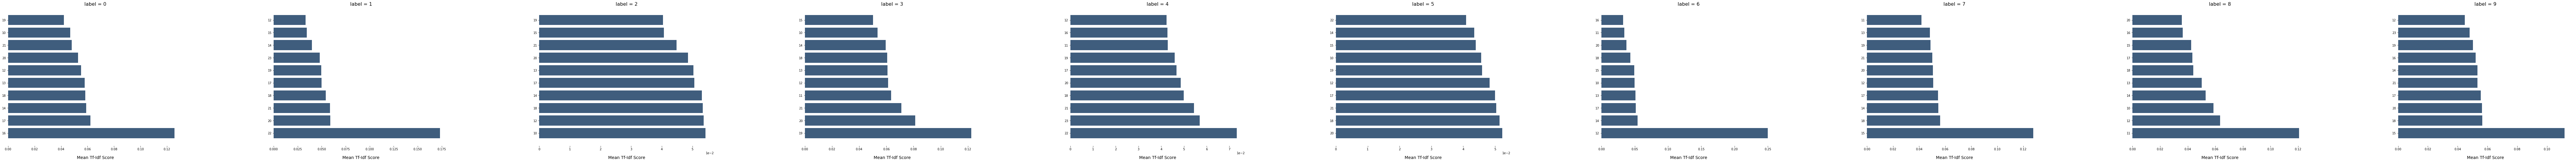

IUCR        Primary Type                   Description  \
0   810               THEFT                     OVER $500   
1  1320     CRIMINAL DAMAGE                    TO VEHICLE   
2  2820       OTHER OFFENSE              TELEPHONE THREAT   
3  1811           NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
4   486             BATTERY       DOMESTIC BATTERY SIMPLE   
5  1310     CRIMINAL DAMAGE                   TO PROPERTY   
6  1150  DECEPTIVE PRACTICE             CREDIT CARD FRAUD   
7   820               THEFT                $500 AND UNDER   
8   610            BURGLARY                FORCIBLE ENTRY   
9   460             BATTERY                        SIMPLE   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0               STREET  False    False       2.0  2013.0      2   15    16  
1               STREET  False    False      12.0  2013.0     11   23    22  
2            APARTMENT  False    False      18.0  2013.0     12   18     9  
3             SIDEWALK   True    False      11.0  2013.0      4   17    19  
4            APARTMENT  False     True       7.0  2013.0     10    6    22  
5            RESIDENCE  False    False      11.0  2013.0      2    2     1  
6                OTHER  False    False      12.0  2013.0      1    9    12  
7               STREET  False    False       5.0  2013.0      8   16    15  
8            RESIDENCE  False    False       4.0  2013.0      4   22    11  
9               STREET  False    False      17.0  2013.0      7   12    15

In [84]:
getTfidf(2013)

   IUCR        Primary Type                          Description  \
0  1152  DECEPTIVE PRACTICE                ILLEGAL USE CASH CARD   
1  1153  DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
2  1153  DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
3  1153  DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
4  1153  DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   

             Location Description Arrest Domestic  District    Year  Month  \
0  ATM (AUTOMATIC TELLER MACHINE)  False    False      18.0  2014.0     11   
1                       RESIDENCE  False    False       8.0  2014.0     12   
2                       RESIDENCE  False    False      14.0  2014.0      1   
3                         UNKNOWN  False    False       1.0  2014.0      2   
4                       RESIDENCE  False    False       4.0  2014.0      7   

   Day  Hour  clusters_10  
0    1     9            3  
1   10    12            1  
2    1     9            6  
3   26    

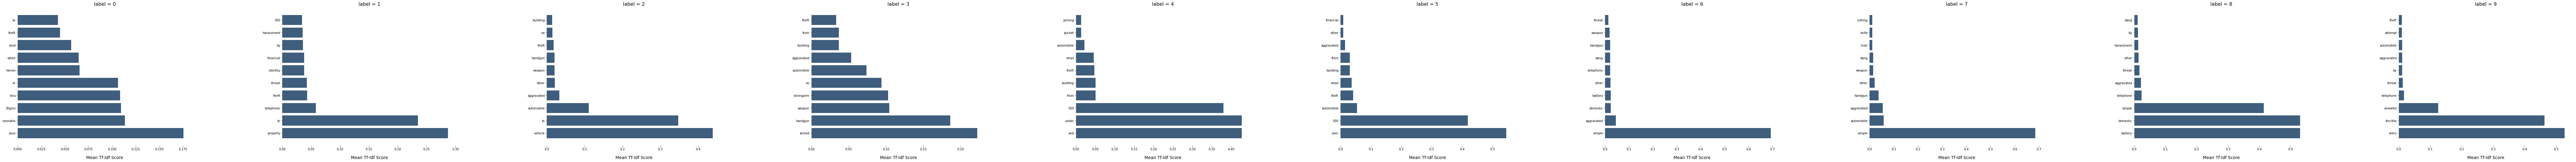

IUCR     Primary Type                   Description Location Description  \
0  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
1  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
2  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
3  031A          ROBBERY                ARMED: HANDGUN               STREET   
4  0820            THEFT                $500 AND UNDER               STREET   
5  0810            THEFT                     OVER $500               STREET   
6  0460          BATTERY                        SIMPLE            RESIDENCE   
7  0560          ASSAULT                        SIMPLE               STREET   
8  0486          BATTERY       DOMESTIC BATTERY SIMPLE            APARTMENT   
9  0610         BURGLARY                FORCIBLE ENTRY            APARTMENT   

  Arrest Domestic  District    Year  Month  Day  Hour  
0   True    False      11.0  2014.0      5    9    19  
1  False    False       6.0  2014.0     12   29    18  
2  False    False       4.0  2014.0      4   21    19  
3  False    False       1.0  2014.0     11   30     2  
4  False    False      18.0  2014.0      1   15    11  
5  False    False      12.0  2014.0      2   25    20  
6  False    False       7.0  2014.0      1   26    15  
7  False    False      11.0  2014.0     10   17    21  
8  False     True       6.0  2014.0      3    2    22  
9  False    False       9.0  2014.0      7    8    20

Location Description
The test has an accuracy of: 
0.323444941288


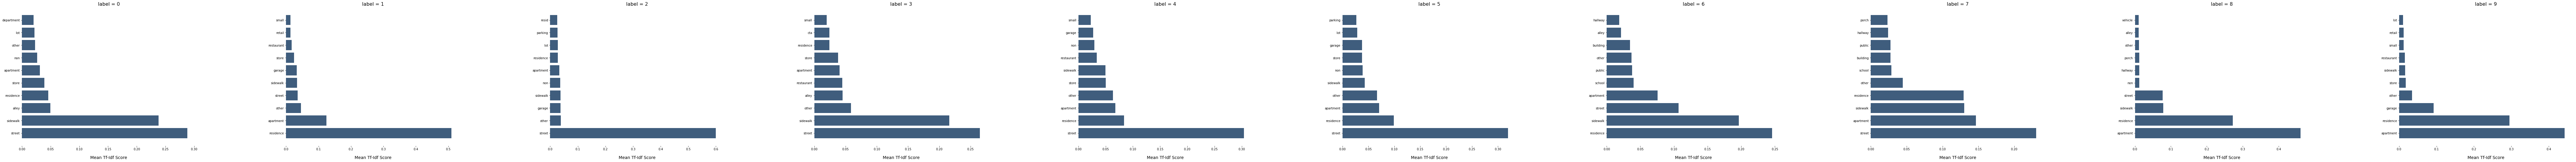

IUCR     Primary Type                   Description Location Description  \
0  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
1  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
2  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
3  031A          ROBBERY                ARMED: HANDGUN               STREET   
4  0820            THEFT                $500 AND UNDER               STREET   
5  0810            THEFT                     OVER $500               STREET   
6  0460          BATTERY                        SIMPLE            RESIDENCE   
7  0560          ASSAULT                        SIMPLE               STREET   
8  0486          BATTERY       DOMESTIC BATTERY SIMPLE            APARTMENT   
9  0610         BURGLARY                FORCIBLE ENTRY            APARTMENT   

  Arrest Domestic  District    Year  Month  Day  Hour  
0   True    False      11.0  2014.0      5    9    19  
1  False    False       6.0  2014.0     12   29    18  
2  False    False       4.0  2014.0      4   21    19  
3  False    False       1.0  2014.0     11   30     2  
4  False    False      18.0  2014.0      1   15    11  
5  False    False      12.0  2014.0      2   25    20  
6  False    False       7.0  2014.0      1   26    15  
7  False    False      11.0  2014.0     10   17    21  
8  False     True       6.0  2014.0      3    2    22  
9  False    False       9.0  2014.0      7    8    20

Primary Type
The test has an accuracy of: 
0.586747615758


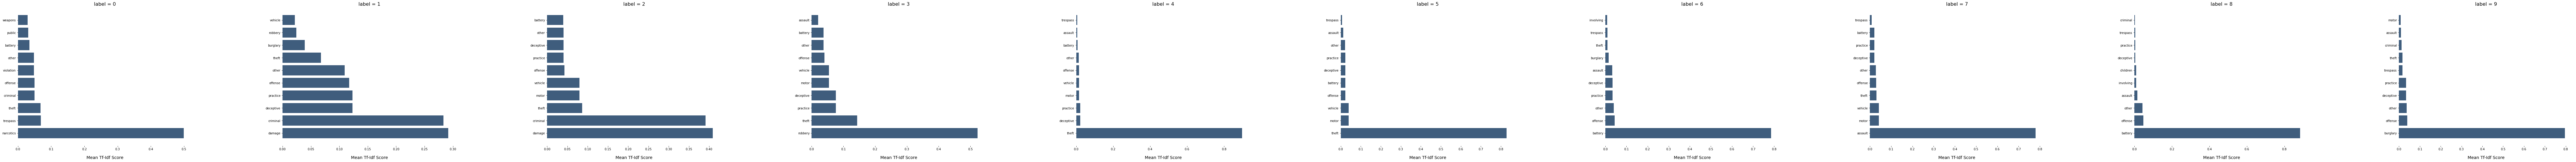

IUCR     Primary Type                   Description Location Description  \
0  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
1  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
2  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
3  031A          ROBBERY                ARMED: HANDGUN               STREET   
4  0820            THEFT                $500 AND UNDER               STREET   
5  0810            THEFT                     OVER $500               STREET   
6  0460          BATTERY                        SIMPLE            RESIDENCE   
7  0560          ASSAULT                        SIMPLE               STREET   
8  0486          BATTERY       DOMESTIC BATTERY SIMPLE            APARTMENT   
9  0610         BURGLARY                FORCIBLE ENTRY            APARTMENT   

  Arrest Domestic  District    Year  Month  Day  Hour  
0   True    False      11.0  2014.0      5    9    19  
1  False    False       6.0  2014.0     12   29    18  
2  False    False       4.0  2014.0      4   21    19  
3  False    False       1.0  2014.0     11   30     2  
4  False    False      18.0  2014.0      1   15    11  
5  False    False      12.0  2014.0      2   25    20  
6  False    False       7.0  2014.0      1   26    15  
7  False    False      11.0  2014.0     10   17    21  
8  False     True       6.0  2014.0      3    2    22  
9  False    False       9.0  2014.0      7    8    20

District
The test has an accuracy of: 
0.237054810291


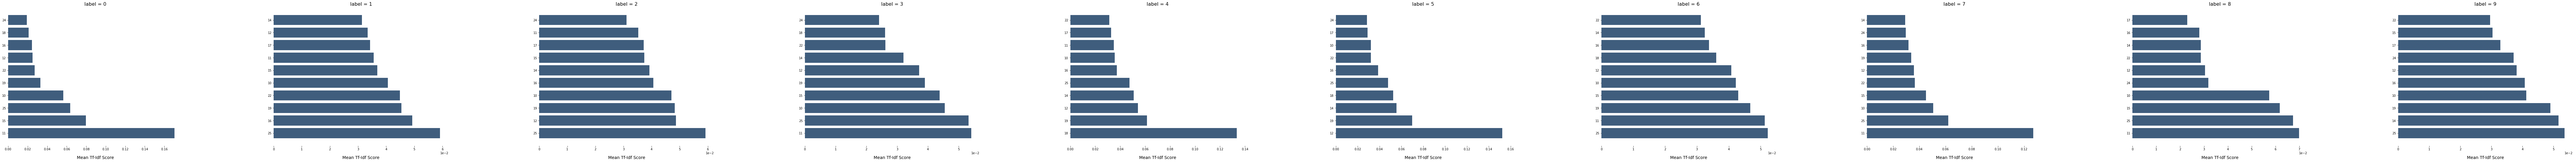

IUCR     Primary Type                   Description Location Description  \
0  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
1  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
2  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
3  031A          ROBBERY                ARMED: HANDGUN               STREET   
4  0820            THEFT                $500 AND UNDER               STREET   
5  0810            THEFT                     OVER $500               STREET   
6  0460          BATTERY                        SIMPLE            RESIDENCE   
7  0560          ASSAULT                        SIMPLE               STREET   
8  0486          BATTERY       DOMESTIC BATTERY SIMPLE            APARTMENT   
9  0610         BURGLARY                FORCIBLE ENTRY            APARTMENT   

  Arrest Domestic  District    Year  Month  Day  Hour  
0   True    False      11.0  2014.0      5    9    19  
1  False    False       6.0  2014.0     12   29    18  
2  False    False       4.0  2014.0      4   21    19  
3  False    False       1.0  2014.0     11   30     2  
4  False    False      18.0  2014.0      1   15    11  
5  False    False      12.0  2014.0      2   25    20  
6  False    False       7.0  2014.0      1   26    15  
7  False    False      11.0  2014.0     10   17    21  
8  False     True       6.0  2014.0      3    2    22  
9  False    False       9.0  2014.0      7    8    20

Day
The test has an accuracy of: 
0.217387089347


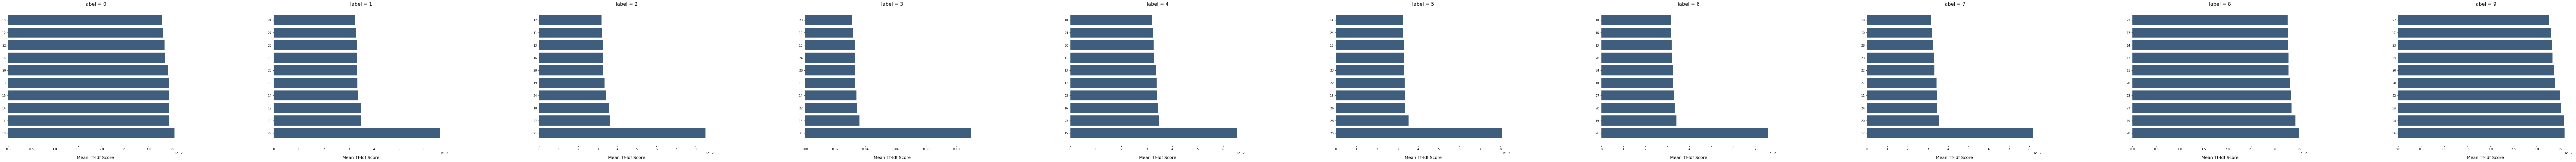

IUCR     Primary Type                   Description Location Description  \
0  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
1  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
2  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
3  031A          ROBBERY                ARMED: HANDGUN               STREET   
4  0820            THEFT                $500 AND UNDER               STREET   
5  0810            THEFT                     OVER $500               STREET   
6  0460          BATTERY                        SIMPLE            RESIDENCE   
7  0560          ASSAULT                        SIMPLE               STREET   
8  0486          BATTERY       DOMESTIC BATTERY SIMPLE            APARTMENT   
9  0610         BURGLARY                FORCIBLE ENTRY            APARTMENT   

  Arrest Domestic  District    Year  Month  Day  Hour  
0   True    False      11.0  2014.0      5    9    19  
1  False    False       6.0  2014.0     12   29    18  
2  False    False       4.0  2014.0      4   21    19  
3  False    False       1.0  2014.0     11   30     2  
4  False    False      18.0  2014.0      1   15    11  
5  False    False      12.0  2014.0      2   25    20  
6  False    False       7.0  2014.0      1   26    15  
7  False    False      11.0  2014.0     10   17    21  
8  False     True       6.0  2014.0      3    2    22  
9  False    False       9.0  2014.0      7    8    20

Hour
The test has an accuracy of: 
0.215060408866


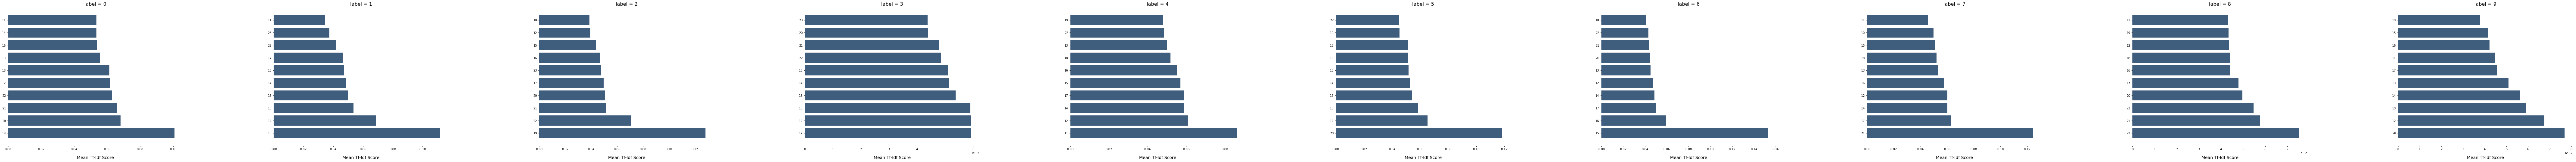

IUCR     Primary Type                   Description Location Description  \
0  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
1  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
2  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
3  031A          ROBBERY                ARMED: HANDGUN               STREET   
4  0820            THEFT                $500 AND UNDER               STREET   
5  0810            THEFT                     OVER $500               STREET   
6  0460          BATTERY                        SIMPLE            RESIDENCE   
7  0560          ASSAULT                        SIMPLE               STREET   
8  0486          BATTERY       DOMESTIC BATTERY SIMPLE            APARTMENT   
9  0610         BURGLARY                FORCIBLE ENTRY            APARTMENT   

  Arrest Domestic  District    Year  Month  Day  Hour  
0   True    False      11.0  2014.0      5    9    19  
1  False    False       6.0  2014.0     12   29    18  
2  False    False       4.0  2014.0      4   21    19  
3  False    False       1.0  2014.0     11   30     2  
4  False    False      18.0  2014.0      1   15    11  
5  False    False      12.0  2014.0      2   25    20  
6  False    False       7.0  2014.0      1   26    15  
7  False    False      11.0  2014.0     10   17    21  
8  False     True       6.0  2014.0      3    2    22  
9  False    False       9.0  2014.0      7    8    20

In [85]:
getTfidf(2014)

   IUCR         Primary Type                   Description  \
0  0281  CRIM SEXUAL ASSAULT                NON-AGGRAVATED   
1  0820                THEFT                $500 AND UNDER   
2  0560              ASSAULT                        SIMPLE   
3  0266  CRIM SEXUAL ASSAULT                     PREDATORY   
4  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   

           Location Description Arrest Domestic  District    Year  Month  Day  \
0  NURSING HOME/RETIREMENT HOME  False    False       3.0  2015.0      1    1   
1                     RESIDENCE  False    False      11.0  2015.0     11   24   
2                     APARTMENT   True    False      19.0  2015.0      5   19   
3                     RESIDENCE   True     True      25.0  2015.0      1    1   
4                     RESIDENCE   True    False      16.0  2015.0      6   24   

   Hour  clusters_10  
0     0            1  
1    17            9  
2     1            3  
3     0            4  
4     6            6  
(2

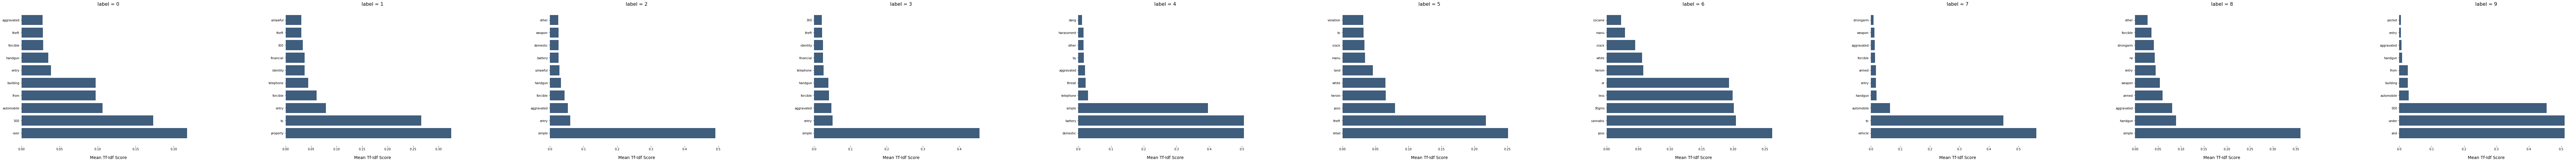

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500               STREET   
1  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
2   460          BATTERY                        SIMPLE            APARTMENT   
3   560          ASSAULT                        SIMPLE            RESIDENCE   
4   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
5   860            THEFT                  RETAIL THEFT             SIDEWALK   
6  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   560          ASSAULT                        SIMPLE             SIDEWALK   
9   820            THEFT                $500 AND UNDER               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2015.0      6   29    18  
1  False    False       3.0  2015.0      8   17    13  
2  False    False       7.0  2015.0      3   11    20  
3  False    False      22.0  2015.0     10   25    15  
4  False     True       4.0  2015.0      5   15    22  
5   True    False      11.0  2015.0      8    2    19  
6   True    False       4.0  2015.0      5   18    19  
7  False    False      12.0  2015.0      1   26    16  
8  False    False       6.0  2015.0      7   10    10  
9  False    False       5.0  2015.0      8   14    10

Location Description
The test has an accuracy of: 
0.294577566357


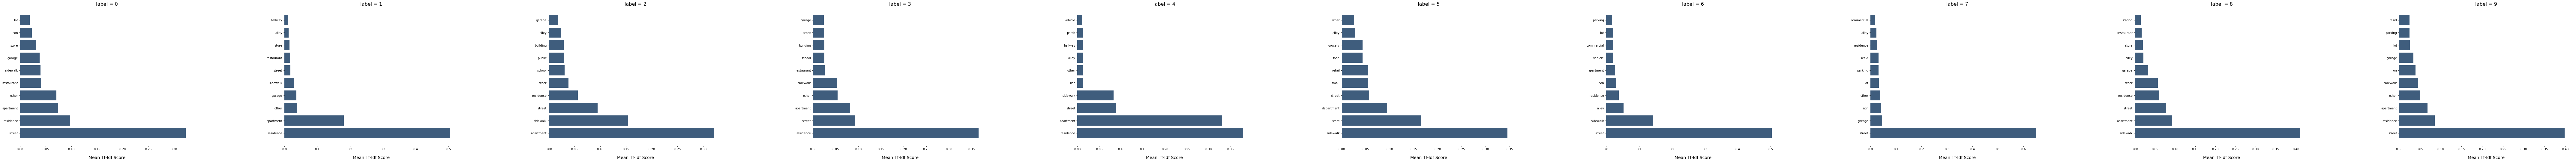

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500               STREET   
1  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
2   460          BATTERY                        SIMPLE            APARTMENT   
3   560          ASSAULT                        SIMPLE            RESIDENCE   
4   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
5   860            THEFT                  RETAIL THEFT             SIDEWALK   
6  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   560          ASSAULT                        SIMPLE             SIDEWALK   
9   820            THEFT                $500 AND UNDER               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2015.0      6   29    18  
1  False    False       3.0  2015.0      8   17    13  
2  False    False       7.0  2015.0      3   11    20  
3  False    False      22.0  2015.0     10   25    15  
4  False     True       4.0  2015.0      5   15    22  
5   True    False      11.0  2015.0      8    2    19  
6   True    False       4.0  2015.0      5   18    19  
7  False    False      12.0  2015.0      1   26    16  
8  False    False       6.0  2015.0      7   10    10  
9  False    False       5.0  2015.0      8   14    10

Primary Type
The test has an accuracy of: 
0.446813086713


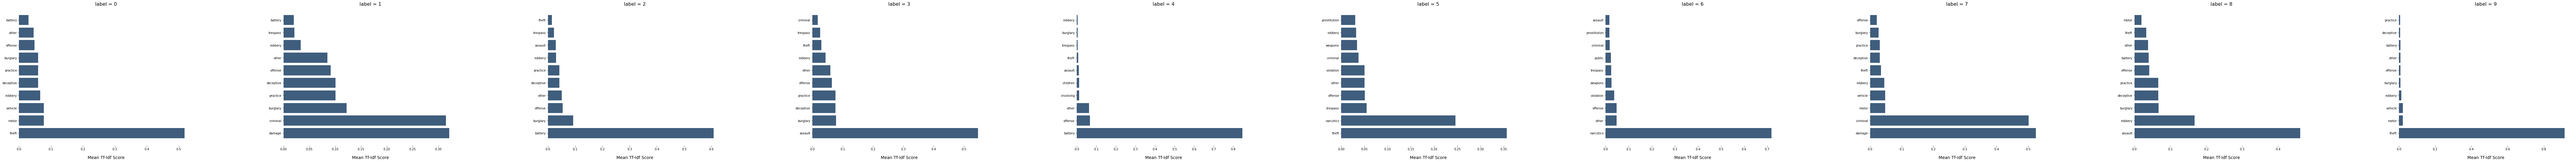

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500               STREET   
1  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
2   460          BATTERY                        SIMPLE            APARTMENT   
3   560          ASSAULT                        SIMPLE            RESIDENCE   
4   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
5   860            THEFT                  RETAIL THEFT             SIDEWALK   
6  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   560          ASSAULT                        SIMPLE             SIDEWALK   
9   820            THEFT                $500 AND UNDER               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2015.0      6   29    18  
1  False    False       3.0  2015.0      8   17    13  
2  False    False       7.0  2015.0      3   11    20  
3  False    False      22.0  2015.0     10   25    15  
4  False     True       4.0  2015.0      5   15    22  
5   True    False      11.0  2015.0      8    2    19  
6   True    False       4.0  2015.0      5   18    19  
7  False    False      12.0  2015.0      1   26    16  
8  False    False       6.0  2015.0      7   10    10  
9  False    False       5.0  2015.0      8   14    10

District
The test has an accuracy of: 
0.200994408036


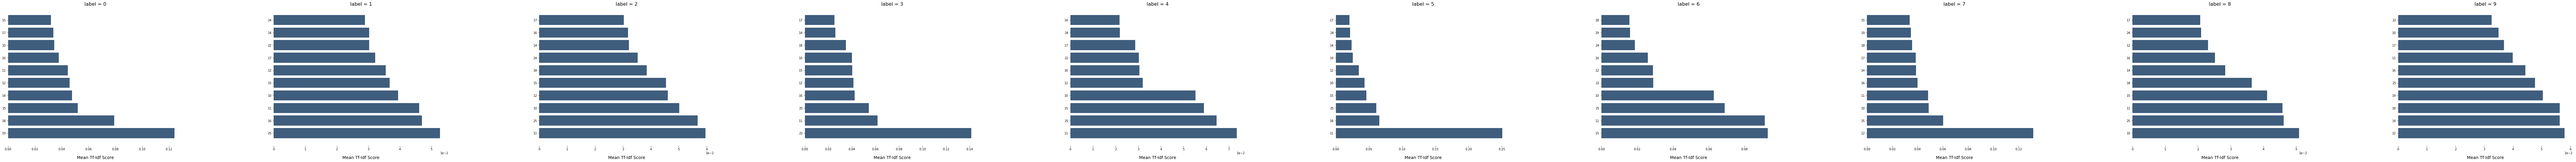

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500               STREET   
1  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
2   460          BATTERY                        SIMPLE            APARTMENT   
3   560          ASSAULT                        SIMPLE            RESIDENCE   
4   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
5   860            THEFT                  RETAIL THEFT             SIDEWALK   
6  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   560          ASSAULT                        SIMPLE             SIDEWALK   
9   820            THEFT                $500 AND UNDER               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2015.0      6   29    18  
1  False    False       3.0  2015.0      8   17    13  
2  False    False       7.0  2015.0      3   11    20  
3  False    False      22.0  2015.0     10   25    15  
4  False     True       4.0  2015.0      5   15    22  
5   True    False      11.0  2015.0      8    2    19  
6   True    False       4.0  2015.0      5   18    19  
7  False    False      12.0  2015.0      1   26    16  
8  False    False       6.0  2015.0      7   10    10  
9  False    False       5.0  2015.0      8   14    10

Day
The test has an accuracy of: 
0.198033956631


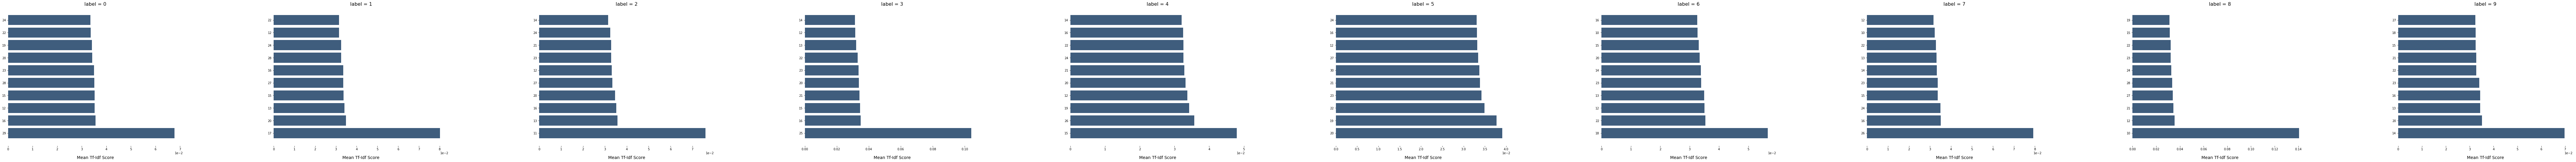

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500               STREET   
1  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
2   460          BATTERY                        SIMPLE            APARTMENT   
3   560          ASSAULT                        SIMPLE            RESIDENCE   
4   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
5   860            THEFT                  RETAIL THEFT             SIDEWALK   
6  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   560          ASSAULT                        SIMPLE             SIDEWALK   
9   820            THEFT                $500 AND UNDER               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2015.0      6   29    18  
1  False    False       3.0  2015.0      8   17    13  
2  False    False       7.0  2015.0      3   11    20  
3  False    False      22.0  2015.0     10   25    15  
4  False     True       4.0  2015.0      5   15    22  
5   True    False      11.0  2015.0      8    2    19  
6   True    False       4.0  2015.0      5   18    19  
7  False    False      12.0  2015.0      1   26    16  
8  False    False       6.0  2015.0      7   10    10  
9  False    False       5.0  2015.0      8   14    10

Hour
The test has an accuracy of: 
0.205460388148


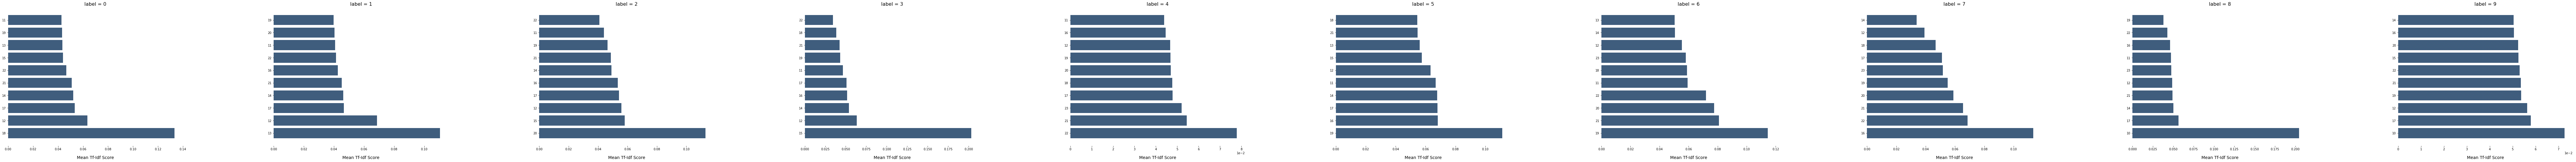

IUCR     Primary Type                   Description Location Description  \
0   810            THEFT                     OVER $500               STREET   
1  1310  CRIMINAL DAMAGE                   TO PROPERTY            RESIDENCE   
2   460          BATTERY                        SIMPLE            APARTMENT   
3   560          ASSAULT                        SIMPLE            RESIDENCE   
4   486          BATTERY       DOMESTIC BATTERY SIMPLE            RESIDENCE   
5   860            THEFT                  RETAIL THEFT             SIDEWALK   
6  1811        NARCOTICS  POSS: CANNABIS 30GMS OR LESS               STREET   
7  1320  CRIMINAL DAMAGE                    TO VEHICLE               STREET   
8   560          ASSAULT                        SIMPLE             SIDEWALK   
9   820            THEFT                $500 AND UNDER               STREET   

  Arrest Domestic  District    Year  Month  Day  Hour  
0  False    False      19.0  2015.0      6   29    18  
1  False    False       3.0  2015.0      8   17    13  
2  False    False       7.0  2015.0      3   11    20  
3  False    False      22.0  2015.0     10   25    15  
4  False     True       4.0  2015.0      5   15    22  
5   True    False      11.0  2015.0      8    2    19  
6   True    False       4.0  2015.0      5   18    19  
7  False    False      12.0  2015.0      1   26    16  
8  False    False       6.0  2015.0      7   10    10  
9  False    False       5.0  2015.0      8   14    10

In [86]:
getTfidf(2015)

   IUCR            Primary Type              Description Location Description  \
0  0486                 BATTERY  DOMESTIC BATTERY SIMPLE            APARTMENT   
1  0486                 BATTERY  DOMESTIC BATTERY SIMPLE            RESIDENCE   
2  0470  PUBLIC PEACE VIOLATION         RECKLESS CONDUCT               STREET   
3  0460                 BATTERY                   SIMPLE             SIDEWALK   
4  0820                   THEFT           $500 AND UNDER            RESIDENCE   

  Arrest Domestic  District    Year  Month  Day  Hour  clusters_10  
0   True     True      10.0  2016.0      5    3    23            0  
1  False     True       3.0  2016.0      5    3    21            0  
2  False    False      15.0  2016.0      5    3    23            0  
3  False    False      15.0  2016.0      5    3    22            3  
4  False     True      15.0  2016.0      5    3    22            1  
(265462, 12)
   IUCR       Primary Type               Description Location Description  \
0  0486  

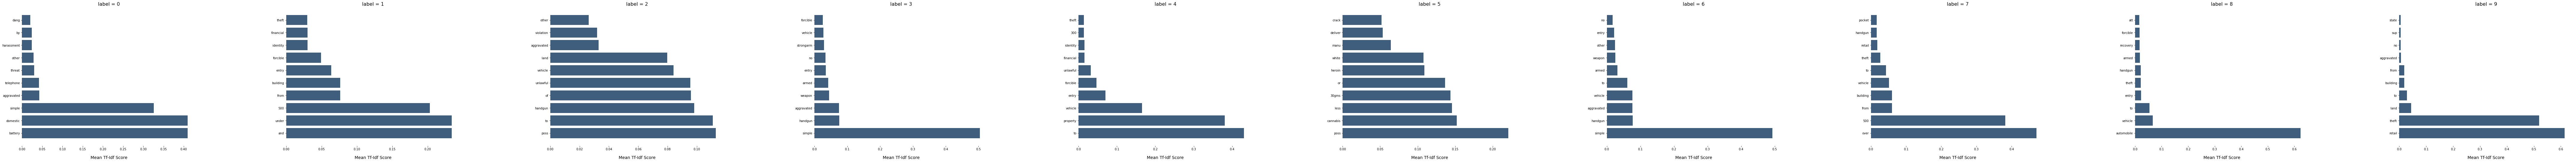

IUCR         Primary Type                   Description  \
0  0486              BATTERY       DOMESTIC BATTERY SIMPLE   
1  0820                THEFT                $500 AND UNDER   
2  143A    WEAPONS VIOLATION      UNLAWFUL POSS OF HANDGUN   
3  0460              BATTERY                        SIMPLE   
4  1310      CRIMINAL DAMAGE                   TO PROPERTY   
5  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
6  0560              ASSAULT                        SIMPLE   
7  0810                THEFT                     OVER $500   
8  0910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
9  0860                THEFT                  RETAIL THEFT   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0            APARTMENT  False     True       4.0  2016.0      5    2    23  
1            RESIDENCE  False    False      11.0  2016.0      5    2    20  
2               STREET   True    False       5.0  2016.0      9    4    21  
3             SIDEWALK  False    False       8.0  2016.0      9   28    15  
4            APARTMENT  False    False      19.0  2016.0      5    4    15  
5             SIDEWALK   True    False      11.0  2016.0      1   20    12  
6               STREET  False    False       7.0  2016.0      7    9    17  
7               STREET  False    False      18.0  2016.0      8   10     1  
8               STREET  False    False      10.0  2016.0     11   13    12  
9     DEPARTMENT STORE   True    False       1.0  2016.0      5   26    16

Location Description
The test has an accuracy of: 
0.327147886883


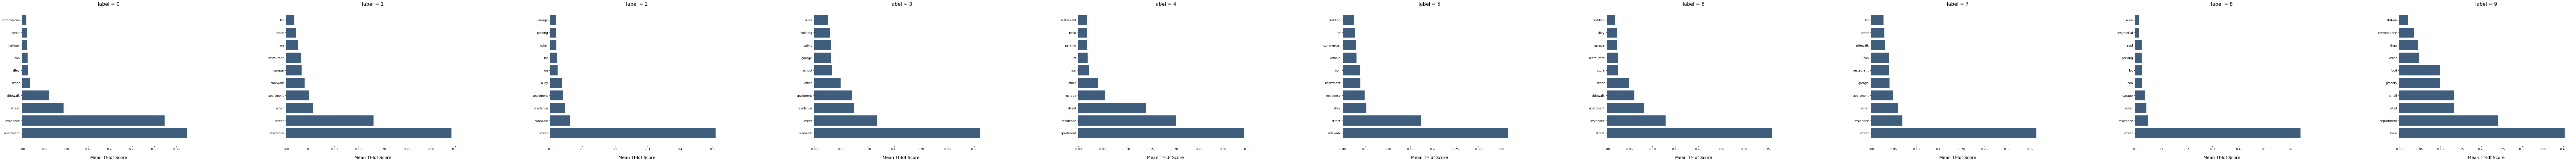

IUCR         Primary Type                   Description  \
0  0486              BATTERY       DOMESTIC BATTERY SIMPLE   
1  0820                THEFT                $500 AND UNDER   
2  143A    WEAPONS VIOLATION      UNLAWFUL POSS OF HANDGUN   
3  0460              BATTERY                        SIMPLE   
4  1310      CRIMINAL DAMAGE                   TO PROPERTY   
5  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
6  0560              ASSAULT                        SIMPLE   
7  0810                THEFT                     OVER $500   
8  0910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
9  0860                THEFT                  RETAIL THEFT   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0            APARTMENT  False     True       4.0  2016.0      5    2    23  
1            RESIDENCE  False    False      11.0  2016.0      5    2    20  
2               STREET   True    False       5.0  2016.0      9    4    21  
3             SIDEWALK  False    False       8.0  2016.0      9   28    15  
4            APARTMENT  False    False      19.0  2016.0      5    4    15  
5             SIDEWALK   True    False      11.0  2016.0      1   20    12  
6               STREET  False    False       7.0  2016.0      7    9    17  
7               STREET  False    False      18.0  2016.0      8   10     1  
8               STREET  False    False      10.0  2016.0     11   13    12  
9     DEPARTMENT STORE   True    False       1.0  2016.0      5   26    16

Primary Type
The test has an accuracy of: 
0.557116186992


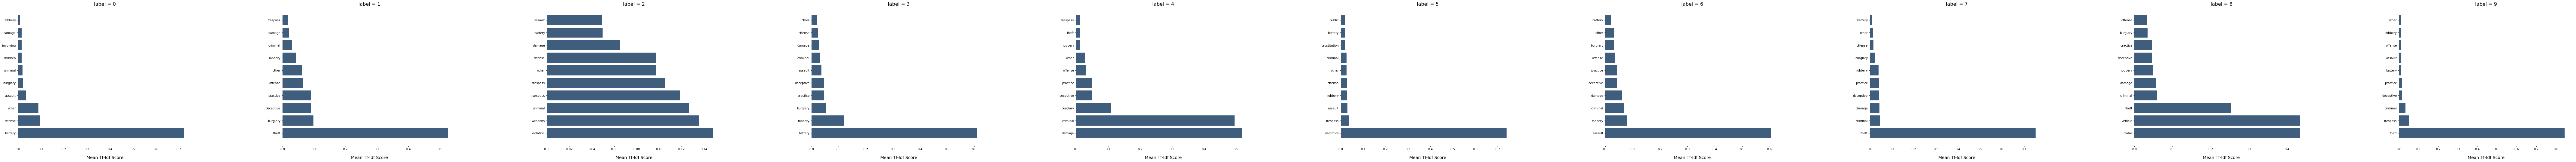

IUCR         Primary Type                   Description  \
0  0486              BATTERY       DOMESTIC BATTERY SIMPLE   
1  0820                THEFT                $500 AND UNDER   
2  143A    WEAPONS VIOLATION      UNLAWFUL POSS OF HANDGUN   
3  0460              BATTERY                        SIMPLE   
4  1310      CRIMINAL DAMAGE                   TO PROPERTY   
5  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
6  0560              ASSAULT                        SIMPLE   
7  0810                THEFT                     OVER $500   
8  0910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
9  0860                THEFT                  RETAIL THEFT   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0            APARTMENT  False     True       4.0  2016.0      5    2    23  
1            RESIDENCE  False    False      11.0  2016.0      5    2    20  
2               STREET   True    False       5.0  2016.0      9    4    21  
3             SIDEWALK  False    False       8.0  2016.0      9   28    15  
4            APARTMENT  False    False      19.0  2016.0      5    4    15  
5             SIDEWALK   True    False      11.0  2016.0      1   20    12  
6               STREET  False    False       7.0  2016.0      7    9    17  
7               STREET  False    False      18.0  2016.0      8   10     1  
8               STREET  False    False      10.0  2016.0     11   13    12  
9     DEPARTMENT STORE   True    False       1.0  2016.0      5   26    16

District
The test has an accuracy of: 
0.248750172282


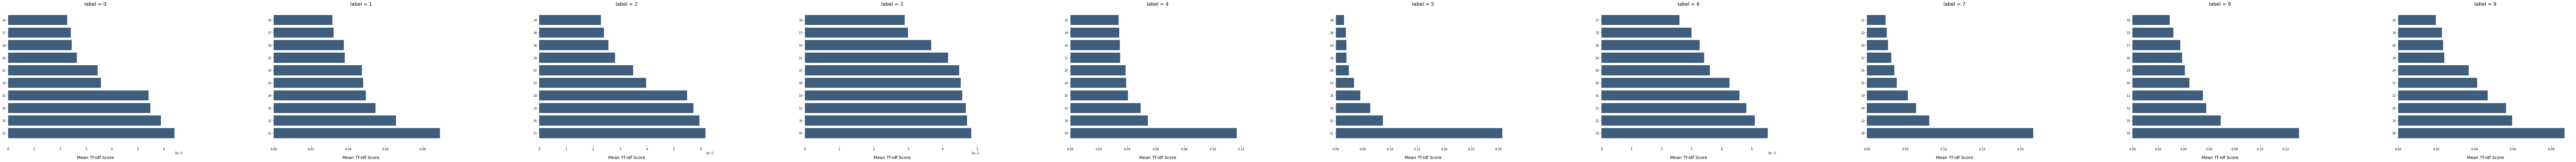

IUCR         Primary Type                   Description  \
0  0486              BATTERY       DOMESTIC BATTERY SIMPLE   
1  0820                THEFT                $500 AND UNDER   
2  143A    WEAPONS VIOLATION      UNLAWFUL POSS OF HANDGUN   
3  0460              BATTERY                        SIMPLE   
4  1310      CRIMINAL DAMAGE                   TO PROPERTY   
5  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
6  0560              ASSAULT                        SIMPLE   
7  0810                THEFT                     OVER $500   
8  0910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
9  0860                THEFT                  RETAIL THEFT   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0            APARTMENT  False     True       4.0  2016.0      5    2    23  
1            RESIDENCE  False    False      11.0  2016.0      5    2    20  
2               STREET   True    False       5.0  2016.0      9    4    21  
3             SIDEWALK  False    False       8.0  2016.0      9   28    15  
4            APARTMENT  False    False      19.0  2016.0      5    4    15  
5             SIDEWALK   True    False      11.0  2016.0      1   20    12  
6               STREET  False    False       7.0  2016.0      7    9    17  
7               STREET  False    False      18.0  2016.0      8   10     1  
8               STREET  False    False      10.0  2016.0     11   13    12  
9     DEPARTMENT STORE   True    False       1.0  2016.0      5   26    16

Day
The test has an accuracy of: 
0.239290323389


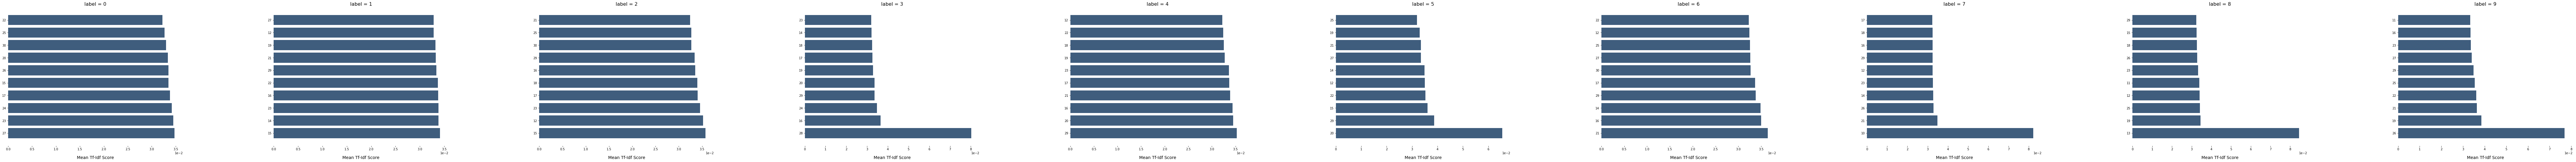

IUCR         Primary Type                   Description  \
0  0486              BATTERY       DOMESTIC BATTERY SIMPLE   
1  0820                THEFT                $500 AND UNDER   
2  143A    WEAPONS VIOLATION      UNLAWFUL POSS OF HANDGUN   
3  0460              BATTERY                        SIMPLE   
4  1310      CRIMINAL DAMAGE                   TO PROPERTY   
5  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
6  0560              ASSAULT                        SIMPLE   
7  0810                THEFT                     OVER $500   
8  0910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
9  0860                THEFT                  RETAIL THEFT   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0            APARTMENT  False     True       4.0  2016.0      5    2    23  
1            RESIDENCE  False    False      11.0  2016.0      5    2    20  
2               STREET   True    False       5.0  2016.0      9    4    21  
3             SIDEWALK  False    False       8.0  2016.0      9   28    15  
4            APARTMENT  False    False      19.0  2016.0      5    4    15  
5             SIDEWALK   True    False      11.0  2016.0      1   20    12  
6               STREET  False    False       7.0  2016.0      7    9    17  
7               STREET  False    False      18.0  2016.0      8   10     1  
8               STREET  False    False      10.0  2016.0     11   13    12  
9     DEPARTMENT STORE   True    False       1.0  2016.0      5   26    16

Hour
The test has an accuracy of: 
0.245279472754


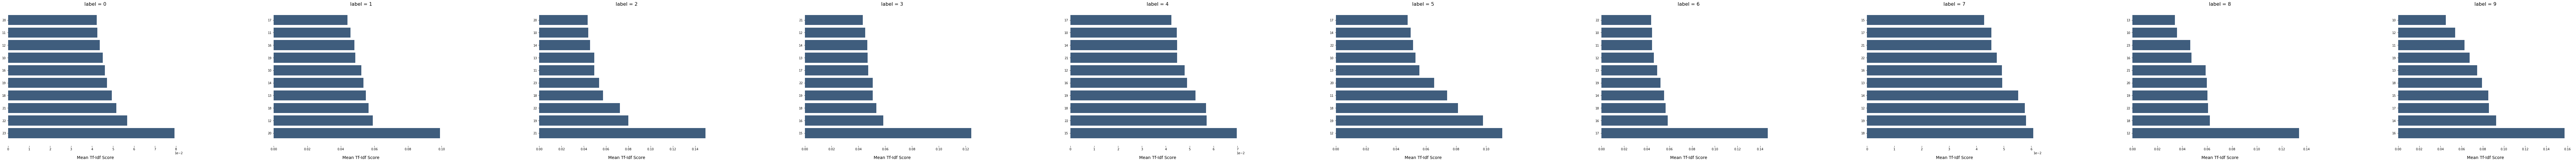

IUCR         Primary Type                   Description  \
0  0486              BATTERY       DOMESTIC BATTERY SIMPLE   
1  0820                THEFT                $500 AND UNDER   
2  143A    WEAPONS VIOLATION      UNLAWFUL POSS OF HANDGUN   
3  0460              BATTERY                        SIMPLE   
4  1310      CRIMINAL DAMAGE                   TO PROPERTY   
5  1811            NARCOTICS  POSS: CANNABIS 30GMS OR LESS   
6  0560              ASSAULT                        SIMPLE   
7  0810                THEFT                     OVER $500   
8  0910  MOTOR VEHICLE THEFT                    AUTOMOBILE   
9  0860                THEFT                  RETAIL THEFT   

  Location Description Arrest Domestic  District    Year  Month  Day  Hour  
0            APARTMENT  False     True       4.0  2016.0      5    2    23  
1            RESIDENCE  False    False      11.0  2016.0      5    2    20  
2               STREET   True    False       5.0  2016.0      9    4    21  
3             SIDEWALK  False    False       8.0  2016.0      9   28    15  
4            APARTMENT  False    False      19.0  2016.0      5    4    15  
5             SIDEWALK   True    False      11.0  2016.0      1   20    12  
6               STREET  False    False       7.0  2016.0      7    9    17  
7               STREET  False    False      18.0  2016.0      8   10     1  
8               STREET  False    False      10.0  2016.0     11   13    12  
9     DEPARTMENT STORE   True    False       1.0  2016.0      5   26    16

In [87]:
getTfidf(2016)